In [1]:
SF = 10
schema   = f'DS{SF:02d}'
max_size = 10 * (1024 ** 3) 
ttl_second = 300

In [2]:
table_path_abfss = 'abfss://melbourne@onelake.dfs.fabric.microsoft.com/data.Lakehouse/Tables'
result_path_abfss = table_path_abfss + '/dbo/tpcds'

In [3]:
import os
def refresh_token():
    try:
     #!pip install     azure-identity
     from   azure.identity import InteractiveBrowserCredential
     os.environ['azure_storage_token'.upper()] = InteractiveBrowserCredential().get_token("https://storage.azure.com/.default").token
    except:
     os.environ['azure_storage_token'] = notebookutils.credentials.getToken('storage')
    print(' all good you are in fabric notebook')
    return "done"

In [4]:
!pip install -q duckdb    --upgrade
!pip install -q deltalake --upgrade

**<mark><u>Import</u></mark>**

In [5]:
import duckdb
from   deltalake import  DeltaTable
import time
import pandas as pd
from   deltalake.writer import write_deltalake
from   datetime import datetime
from   sqlglot import parse_one, exp
from   psutil import *
from   cachetools import cached, TTLCache
from   deltalake.query import QueryBuilder

In [6]:
core=cpu_count()
core

2

In [7]:
tpcds_tables = ['web_site','web_sales','web_returns','web_page','warehouse','time_dim','store_sales','store_returns',\
      'store','ship_mode','reason','promotion','item','inventory','income_band','household_demographics','date_dim','customer_demographics',\
      'customer_address','customer','catalog_sales','catalog_returns','catalog_page','call_center']

# Generate Delta

In [8]:
%%time
import uuid
db_path = f'tpcds{str(uuid.uuid4())}.duckdb'
RG = 8_000_000
try :
  DeltaTable(f'{table_path_abfss}/{schema}/call_center')
  print("Already Generated")
except:
  con = duckdb.connect(db_path)
  con.sql(f"CALL dsdgen(sf={SF})")
  refresh_token()
  for tbl in tpcds_tables :
      print(tbl)
      write_deltalake(f'{table_path_abfss}/{schema}/{tbl}',
      con.sql(f"""SELECT * FROM {tbl} """).record_batch(),
      max_rows_per_file=RG, max_rows_per_group=RG, min_rows_per_group=RG, 
      mode="overwrite",engine='pyarrow')
  con.close()
  if os.path.isfile(db_path):
    os.remove(db_path)
  else:
    print("File does not exist")

 all good you are in fabric notebook
Already Generated
CPU times: user 225 ms, sys: 19.3 ms, total: 244 ms
Wall time: 1.39 s


<mark>**Check File size output**</mark>

In [9]:
def get_stats(Source,Destination):
    appended_data = []
    List_tables = [ f.name for f in os.scandir(Source) if f.is_dir() ]
    stat_table = os.path.basename(os.path.normpath(Destination))
    if stat_table in List_tables: List_tables.remove(stat_table)
    for tbl in List_tables :
        dt = DeltaTable(Source+ tbl)
        xx= dt.get_add_actions(flatten=True).to_pandas()
        if 'tags.VORDER' in xx.columns:
             vorder =True
        else :
             vorder =False
        deltalog=pd.DataFrame([[tbl,xx['size_bytes'].sum(),vorder]],columns=['tbl','size_bytes','vorder'])
        delta = [Source+tbl + "/" + i for i in dt.files()]
        duckdb.sql(f'from parquet_scan({delta})').to_view(tbl)
        print(tbl)
        df= duckdb.sql(f'''
        with x as (
        select file_name,num_rows,num_row_groups, '{tbl}' as tbl from parquet_file_metadata({delta})
        )
        select x.tbl, file_name,num_rows,num_row_groups, ceil(size_bytes/(1024*1024)) as size,vorder from x
        left join deltalog as y
        on x.tbl=y.tbl
         ''').df()
        appended_data.append(df)
    appended_data = pd.concat(appended_data,ignore_index=True)
    appended_data['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    write_deltalake(Destination,appended_data,mode="overwrite",storage_options={"allow_unsafe_rename":"true"})

    dt = DeltaTable(Destination)
    delta = [Destination + "/" + i for i in dt.files()]
    duckdb.sql(f'from parquet_scan({delta})').to_view("xxx")

    duckdb.sql('''
    select tbl,
    sum(num_rows) as total_rows,
    count(*) as num_files,
    sum(num_row_groups) as num_row_group,
    cast(ceil(total_rows/num_row_group) as integer) as Average_row_group,
    min(size) as file_size_MB,
    vorder
    from xxx
    group by all
    order by file_size_MB ASC
    ''').show()

In [10]:
get_stats(f"/lakehouse/default/Tables/{schema}/","/lakehouse/default/Tables/dbo/xx_deltastats")

call_center
catalog_page
catalog_returns
catalog_sales
customer
customer_address
customer_demographics
date_dim
household_demographics
income_band
inventory


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

item
promotion
reason
ship_mode
store
store_returns
store_sales


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

time_dim
warehouse
web_page
web_returns
web_sales
web_site
┌────────────────────────┬────────────┬───────────┬───────────────┬───────────────────┬──────────────┬─────────┐
│          tbl           │ total_rows │ num_files │ num_row_group │ Average_row_group │ file_size_MB │ vorder  │
│        varchar         │   int128   │   int64   │    int128     │       int32       │    double    │ boolean │
├────────────────────────┼────────────┼───────────┼───────────────┼───────────────────┼──────────────┼─────────┤
│ call_center            │         24 │         1 │             1 │                24 │          1.0 │ false   │
│ income_band            │         20 │         1 │             1 │                20 │          1.0 │ false   │
│ ship_mode              │         20 │         1 │             1 │                20 │          1.0 │ false   │
│ store                  │        102 │         1 │             1 │               102 │          1.0 │ false   │
│ web_site               │         42

# SQL Query

In [11]:
sql=("""
WITH  customer_total_return  AS
    (SELECT  sr_customer_sk  AS  ctr_customer_sk,
                    sr_store_sk  AS  ctr_store_sk,
                    sum(sr_return_amt)  AS  ctr_total_return
      FROM  store_returns,
                date_dim
      WHERE  sr_returned_date_sk  =  d_date_sk
          AND  d_year  =  2000
      GROUP  BY  sr_customer_sk,
                        sr_store_sk)
SELECT  c_customer_id
FROM  customer_total_return  ctr1,
          store,
          customer
WHERE  ctr1.ctr_total_return  >
        (SELECT  avg(ctr_total_return)*1.2
          FROM  customer_total_return  ctr2
          WHERE  ctr1.ctr_store_sk  =  ctr2.ctr_store_sk)
    AND  s_store_sk  =  ctr1.ctr_store_sk
    AND  s_state  =  'TN'
    AND  ctr1.ctr_customer_sk  =  c_customer_sk
ORDER  BY  c_customer_id
LIMIT  100;


WITH  wscs  AS
    (SELECT  sold_date_sk,
                    sales_price
      FROM
          (SELECT  ws_sold_date_sk  sold_date_sk,
                          ws_ext_sales_price  sales_price
            FROM  web_sales
            UNION  ALL  SELECT  cs_sold_date_sk  sold_date_sk,
                                              cs_ext_sales_price  sales_price
            FROM  catalog_sales)  sq1),
          wswscs  AS
    (SELECT  d_week_seq,
                    sum(CASE
                                    WHEN  (d_day_name='Sunday')  THEN  sales_price
                                    ELSE  NULL
                            END)  sun_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Monday')  THEN  sales_price
                                    ELSE  NULL
                            END)  mon_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Tuesday')  THEN  sales_price
                                    ELSE  NULL
                            END)  tue_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Wednesday')  THEN  sales_price
                                    ELSE  NULL
                            END)  wed_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Thursday')  THEN  sales_price
                                    ELSE  NULL
                            END)  thu_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Friday')  THEN  sales_price
                                    ELSE  NULL
                            END)  fri_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Saturday')  THEN  sales_price
                                    ELSE  NULL
                            END)  sat_sales
      FROM  wscs,
                date_dim
      WHERE  d_date_sk  =  sold_date_sk
      GROUP  BY  d_week_seq)
SELECT  d_week_seq1,
              round(sun_sales1/sun_sales2,  2)  r1,
              round(mon_sales1/mon_sales2,  2)  r2,
              round(tue_sales1/tue_sales2,  2)  r3,
              round(wed_sales1/wed_sales2,  2)  r4,
              round(thu_sales1/thu_sales2,  2)  r5,
              round(fri_sales1/fri_sales2,  2)  r6,
              round(sat_sales1/sat_sales2,  2)
FROM
    (SELECT  wswscs.d_week_seq  d_week_seq1,
                    sun_sales  sun_sales1,
                    mon_sales  mon_sales1,
                    tue_sales  tue_sales1,
                    wed_sales  wed_sales1,
                    thu_sales  thu_sales1,
                    fri_sales  fri_sales1,
                    sat_sales  sat_sales1
      FROM  wswscs,
                date_dim
      WHERE  date_dim.d_week_seq  =  wswscs.d_week_seq
          AND  d_year  =  2001)  y,
    (SELECT  wswscs.d_week_seq  d_week_seq2,
                    sun_sales  sun_sales2,
                    mon_sales  mon_sales2,
                    tue_sales  tue_sales2,
                    wed_sales  wed_sales2,
                    thu_sales  thu_sales2,
                    fri_sales  fri_sales2,
                    sat_sales  sat_sales2
      FROM  wswscs,
                date_dim
      WHERE  date_dim.d_week_seq  =  wswscs.d_week_seq
          AND  d_year  =  2001+1)  z
WHERE  d_week_seq1  =  d_week_seq2-53
ORDER  BY  d_week_seq1  NULLS  FIRST;

SELECT  dt.d_year,
              item.i_brand_id  brand_id,
              item.i_brand  brand,
              sum(ss_ext_sales_price)  sum_agg
FROM  date_dim  dt,
          store_sales,
          item
WHERE  dt.d_date_sk  =  store_sales.ss_sold_date_sk
    AND  store_sales.ss_item_sk  =  item.i_item_sk
    AND  item.i_manufact_id  =  128
    AND  dt.d_moy=11
GROUP  BY  dt.d_year,
                  item.i_brand,
                  item.i_brand_id
ORDER  BY  dt.d_year,
                  sum_agg  DESC,
                  brand_id
LIMIT  100;


WITH  year_total  AS
    (SELECT  c_customer_id  customer_id,
                    c_first_name  customer_first_name,
                    c_last_name  customer_last_name,
                    c_preferred_cust_flag  customer_preferred_cust_flag,
                    c_birth_country  customer_birth_country,
                    c_login  customer_login,
                    c_email_address  customer_email_address,
                    d_year  dyear,
                    sum(((ss_ext_list_price-ss_ext_wholesale_cost-ss_ext_discount_amt)+ss_ext_sales_price)/2)  year_total,
                    's'  sale_type
      FROM  customer,
                store_sales,
                date_dim
      WHERE  c_customer_sk  =  ss_customer_sk
          AND  ss_sold_date_sk  =  d_date_sk
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        c_preferred_cust_flag,
                        c_birth_country,
                        c_login,
                        c_email_address,
                        d_year
      UNION  ALL  SELECT  c_customer_id  customer_id,
                                        c_first_name  customer_first_name,
                                        c_last_name  customer_last_name,
                                        c_preferred_cust_flag  customer_preferred_cust_flag,
                                        c_birth_country  customer_birth_country,
                                        c_login  customer_login,
                                        c_email_address  customer_email_address,
                                        d_year  dyear,
                                        sum((((cs_ext_list_price-cs_ext_wholesale_cost-cs_ext_discount_amt)+cs_ext_sales_price)/2))  year_total,
                                        'c'  sale_type
      FROM  customer,
                catalog_sales,
                date_dim
      WHERE  c_customer_sk  =  cs_bill_customer_sk
          AND  cs_sold_date_sk  =  d_date_sk
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        c_preferred_cust_flag,
                        c_birth_country,
                        c_login,
                        c_email_address,
                        d_year
      UNION  ALL  SELECT  c_customer_id  customer_id,
                                        c_first_name  customer_first_name,
                                        c_last_name  customer_last_name,
                                        c_preferred_cust_flag  customer_preferred_cust_flag,
                                        c_birth_country  customer_birth_country,
                                        c_login  customer_login,
                                        c_email_address  customer_email_address,
                                        d_year  dyear,
                                        sum((((ws_ext_list_price-ws_ext_wholesale_cost-ws_ext_discount_amt)+ws_ext_sales_price)/2))  year_total,
                                        'w'  sale_type
      FROM  customer,
                web_sales,
                date_dim
      WHERE  c_customer_sk  =  ws_bill_customer_sk
          AND  ws_sold_date_sk  =  d_date_sk
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        c_preferred_cust_flag,
                        c_birth_country,
                        c_login,
                        c_email_address,
                        d_year)
SELECT  t_s_secyear.customer_id,
              t_s_secyear.customer_first_name,
              t_s_secyear.customer_last_name,
              t_s_secyear.customer_preferred_cust_flag
FROM  year_total  t_s_firstyear,
          year_total  t_s_secyear,
          year_total  t_c_firstyear,
          year_total  t_c_secyear,
          year_total  t_w_firstyear,
          year_total  t_w_secyear
WHERE  t_s_secyear.customer_id  =  t_s_firstyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_c_secyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_c_firstyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_firstyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_secyear.customer_id
    AND  t_s_firstyear.sale_type  =  's'
    AND  t_c_firstyear.sale_type  =  'c'
    AND  t_w_firstyear.sale_type  =  'w'
    AND  t_s_secyear.sale_type  =  's'
    AND  t_c_secyear.sale_type  =  'c'
    AND  t_w_secyear.sale_type  =  'w'
    AND  t_s_firstyear.dyear  =  2001
    AND  t_s_secyear.dyear  =  2001+1
    AND  t_c_firstyear.dyear  =  2001
    AND  t_c_secyear.dyear  =  2001+1
    AND  t_w_firstyear.dyear  =  2001
    AND  t_w_secyear.dyear  =  2001+1
    AND  t_s_firstyear.year_total  >  0
    AND  t_c_firstyear.year_total  >  0
    AND  t_w_firstyear.year_total  >  0
    AND  CASE
                    WHEN  t_c_firstyear.year_total  >  0  THEN  t_c_secyear.year_total  /  t_c_firstyear.year_total
                    ELSE  NULL
            END  >  CASE
                                WHEN  t_s_firstyear.year_total  >  0  THEN  t_s_secyear.year_total  /  t_s_firstyear.year_total
                                ELSE  NULL
                        END
    AND  CASE
                    WHEN  t_c_firstyear.year_total  >  0  THEN  t_c_secyear.year_total  /  t_c_firstyear.year_total
                    ELSE  NULL
            END  >  CASE
                                WHEN  t_w_firstyear.year_total  >  0  THEN  t_w_secyear.year_total  /  t_w_firstyear.year_total
                                ELSE  NULL
                        END
ORDER  BY  t_s_secyear.customer_id  NULLS  FIRST,
                  t_s_secyear.customer_first_name  NULLS  FIRST,
                  t_s_secyear.customer_last_name  NULLS  FIRST,
                  t_s_secyear.customer_preferred_cust_flag  NULLS  FIRST
LIMIT  100;


WITH  ssr  AS
    (SELECT  s_store_id,
                    sum(sales_price)  AS  sales,
                    sum(profit)  AS  profit,
                    sum(return_amt)  AS  returns_,
                    sum(net_loss)  AS  profit_loss
      FROM
          (SELECT  ss_store_sk  AS  store_sk,
                          ss_sold_date_sk  AS  date_sk,
                          ss_ext_sales_price  AS  sales_price,
                          ss_net_profit  AS  profit,
                          cast(0  AS  decimal(7,2))  AS  return_amt,
                          cast(0  AS  decimal(7,2))  AS  net_loss
            FROM  store_sales
            UNION  ALL  SELECT  sr_store_sk  AS  store_sk,
                                              sr_returned_date_sk  AS  date_sk,
                                              cast(0  AS  decimal(7,2))  AS  sales_price,
                                              cast(0  AS  decimal(7,2))  AS  profit,
                                              sr_return_amt  AS  return_amt,
                                              sr_net_loss  AS  net_loss
            FROM  store_returns  )  salesreturns,
                date_dim,
                store
      WHERE  date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-06'  AS  date)
          AND  store_sk  =  s_store_sk
      GROUP  BY  s_store_id)  ,
          csr  AS
    (SELECT  cp_catalog_page_id,
                    sum(sales_price)  AS  sales,
                    sum(profit)  AS  profit,
                    sum(return_amt)  AS  returns_,
                    sum(net_loss)  AS  profit_loss
      FROM
          (SELECT  cs_catalog_page_sk  AS  page_sk,
                          cs_sold_date_sk  AS  date_sk,
                          cs_ext_sales_price  AS  sales_price,
                          cs_net_profit  AS  profit,
                          cast(0  AS  decimal(7,2))  AS  return_amt,
                          cast(0  AS  decimal(7,2))  AS  net_loss
            FROM  catalog_sales
            UNION  ALL  SELECT  cr_catalog_page_sk  AS  page_sk,
                                              cr_returned_date_sk  AS  date_sk,
                                              cast(0  AS  decimal(7,2))  AS  sales_price,
                                              cast(0  AS  decimal(7,2))  AS  profit,
                                              cr_return_amount  AS  return_amt,
                                              cr_net_loss  AS  net_loss
            FROM  catalog_returns  )  salesreturns,
                date_dim,
                catalog_page
      WHERE  date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-06'  AS  date)
          AND  page_sk  =  cp_catalog_page_sk
      GROUP  BY  cp_catalog_page_id)  ,
          wsr  AS
    (SELECT  web_site_id,
                    sum(sales_price)  AS  sales,
                    sum(profit)  AS  profit,
                    sum(return_amt)  AS  returns_,
                    sum(net_loss)  AS  profit_loss
      FROM
          (SELECT  ws_web_site_sk  AS  wsr_web_site_sk,
                          ws_sold_date_sk  AS  date_sk,
                          ws_ext_sales_price  AS  sales_price,
                          ws_net_profit  AS  profit,
                          cast(0  AS  decimal(7,2))  AS  return_amt,
                          cast(0  AS  decimal(7,2))  AS  net_loss
            FROM  web_sales
            UNION  ALL  SELECT  ws_web_site_sk  AS  wsr_web_site_sk,
                                              wr_returned_date_sk  AS  date_sk,
                                              cast(0  AS  decimal(7,2))  AS  sales_price,
                                              cast(0  AS  decimal(7,2))  AS  profit,
                                              wr_return_amt  AS  return_amt,
                                              wr_net_loss  AS  net_loss
            FROM  web_returns
            LEFT  OUTER  JOIN  web_sales  ON  (wr_item_sk  =  ws_item_sk
                                                                        AND  wr_order_number  =  ws_order_number)  )  salesreturns,
                date_dim,
                web_site
      WHERE  date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-06'  AS  date)
          AND  wsr_web_site_sk  =  web_site_sk
      GROUP  BY  web_site_id)
SELECT  channel  ,
              id  ,
              sum(sales)  AS  sales  ,
              sum(returns_)  AS  returns_  ,
              sum(profit)  AS  profit
FROM
    (SELECT  'store  channel'  AS  channel  ,
                    concat('store',  s_store_id)  AS  id  ,
                    sales  ,
                    returns_  ,
                    (profit  -  profit_loss)  AS  profit
      FROM  ssr
      UNION  ALL  SELECT  'catalog  channel'  AS  channel  ,
                                        concat('catalog_page',  cp_catalog_page_id)  AS  id  ,
                                        sales  ,
                                        returns_  ,
                                        (profit  -  profit_loss)  AS  profit
      FROM  csr
      UNION  ALL  SELECT  'web  channel'  AS  channel  ,
                                        concat('web_site',  web_site_id)  AS  id  ,
                                        sales  ,
                                        returns_  ,
                                        (profit  -  profit_loss)  AS  profit
      FROM  wsr  )  x
GROUP  BY  ROLLUP  (channel,
                                  id)
ORDER  BY  channel  NULLS  FIRST,
                  id  NULLS  FIRST
LIMIT  100;

SELECT  a.ca_state  state,
              count(*)  cnt
FROM  customer_address  a  ,
          customer  c  ,
          store_sales  s  ,
          date_dim  d  ,
          item  i
WHERE  a.ca_address_sk  =  c.c_current_addr_sk
    AND  c.c_customer_sk  =  s.ss_customer_sk
    AND  s.ss_sold_date_sk  =  d.d_date_sk
    AND  s.ss_item_sk  =  i.i_item_sk
    AND  d.d_month_seq  =
        (SELECT  DISTINCT  (d_month_seq)
          FROM  date_dim
          WHERE  d_year  =  2001
              AND  d_moy  =  1  )
    AND  i.i_current_price  >  1.2  *
        (SELECT  avg(j.i_current_price)
          FROM  item  j
          WHERE  j.i_category  =  i.i_category)
GROUP  BY  a.ca_state
HAVING  count(*)  >=  10
ORDER  BY  cnt  NULLS  FIRST,
                  a.ca_state  NULLS  FIRST
LIMIT  100;


SELECT  i_item_id,
              avg(ss_quantity)  agg1,
              avg(ss_list_price)  agg2,
              avg(ss_coupon_amt)  agg3,
              avg(ss_sales_price)  agg4
FROM  store_sales,
          customer_demographics,
          date_dim,
          item,
          promotion
WHERE  ss_sold_date_sk  =  d_date_sk
    AND  ss_item_sk  =  i_item_sk
    AND  ss_cdemo_sk  =  cd_demo_sk
    AND  ss_promo_sk  =  p_promo_sk
    AND  cd_gender  =  'M'
    AND  cd_marital_status  =  'S'
    AND  cd_education_status  =  'College'
    AND  (p_channel_email  =  'N'
              OR  p_channel_event  =  'N')
    AND  d_year  =  2000
GROUP  BY  i_item_id
ORDER  BY  i_item_id
LIMIT  100;


SELECT  s_store_name,
              sum(ss_net_profit)
FROM  store_sales,
          date_dim,
          store,
    (SELECT  ca_zip
      FROM
          (SELECT  SUBSTRING(ca_zip,  1,  5)  ca_zip
            FROM  customer_address
            WHERE  SUBSTRING(ca_zip,  1,  5)  IN  ('24128',
                                                                          '76232',
                                                                          '65084',
                                                                          '87816',
                                                                          '83926',
                                                                          '77556',
                                                                          '20548',
                                                                          '26231',
                                                                          '43848',
                                                                          '15126',
                                                                          '91137',
                                                                          '61265',
                                                                          '98294',
                                                                          '25782',
                                                                          '17920',
                                                                          '18426',
                                                                          '98235',
                                                                          '40081',
                                                                          '84093',
                                                                          '28577',
                                                                          '55565',
                                                                          '17183',
                                                                          '54601',
                                                                          '67897',
                                                                          '22752',
                                                                          '86284',
                                                                          '18376',
                                                                          '38607',
                                                                          '45200',
                                                                          '21756',
                                                                          '29741',
                                                                          '96765',
                                                                          '23932',
                                                                          '89360',
                                                                          '29839',
                                                                          '25989',
                                                                          '28898',
                                                                          '91068',
                                                                          '72550',
                                                                          '10390',
                                                                          '18845',
                                                                          '47770',
                                                                          '82636',
                                                                          '41367',
                                                                          '76638',
                                                                          '86198',
                                                                          '81312',
                                                                          '37126',
                                                                          '39192',
                                                                          '88424',
                                                                          '72175',
                                                                          '81426',
                                                                          '53672',
                                                                          '10445',
                                                                          '42666',
                                                                          '66864',
                                                                          '66708',
                                                                          '41248',
                                                                          '48583',
                                                                          '82276',
                                                                          '18842',
                                                                          '78890',
                                                                          '49448',
                                                                          '14089',
                                                                          '38122',
                                                                          '34425',
                                                                          '79077',
                                                                          '19849',
                                                                          '43285',
                                                                          '39861',
                                                                          '66162',
                                                                          '77610',
                                                                          '13695',
                                                                          '99543',
                                                                          '83444',
                                                                          '83041',
                                                                          '12305',
                                                                          '57665',
                                                                          '68341',
                                                                          '25003',
                                                                          '57834',
                                                                          '62878',
                                                                          '49130',
                                                                          '81096',
                                                                          '18840',
                                                                          '27700',
                                                                          '23470',
                                                                          '50412',
                                                                          '21195',
                                                                          '16021',
                                                                          '76107',
                                                                          '71954',
                                                                          '68309',
                                                                          '18119',
                                                                          '98359',
                                                                          '64544',
                                                                          '10336',
                                                                          '86379',
                                                                          '27068',
                                                                          '39736',
                                                                          '98569',
                                                                          '28915',
                                                                          '24206',
                                                                          '56529',
                                                                          '57647',
                                                                          '54917',
                                                                          '42961',
                                                                          '91110',
                                                                          '63981',
                                                                          '14922',
                                                                          '36420',
                                                                          '23006',
                                                                          '67467',
                                                                          '32754',
                                                                          '30903',
                                                                          '20260',
                                                                          '31671',
                                                                          '51798',
                                                                          '72325',
                                                                          '85816',
                                                                          '68621',
                                                                          '13955',
                                                                          '36446',
                                                                          '41766',
                                                                          '68806',
                                                                          '16725',
                                                                          '15146',
                                                                          '22744',
                                                                          '35850',
                                                                          '88086',
                                                                          '51649',
                                                                          '18270',
                                                                          '52867',
                                                                          '39972',
                                                                          '96976',
                                                                          '63792',
                                                                          '11376',
                                                                          '94898',
                                                                          '13595',
                                                                          '10516',
                                                                          '90225',
                                                                          '58943',
                                                                          '39371',
                                                                          '94945',
                                                                          '28587',
                                                                          '96576',
                                                                          '57855',
                                                                          '28488',
                                                                          '26105',
                                                                          '83933',
                                                                          '25858',
                                                                          '34322',
                                                                          '44438',
                                                                          '73171',
                                                                          '30122',
                                                                          '34102',
                                                                          '22685',
                                                                          '71256',
                                                                          '78451',
                                                                          '54364',
                                                                          '13354',
                                                                          '45375',
                                                                          '40558',
                                                                          '56458',
                                                                          '28286',
                                                                          '45266',
                                                                          '47305',
                                                                          '69399',
                                                                          '83921',
                                                                          '26233',
                                                                          '11101',
                                                                          '15371',
                                                                          '69913',
                                                                          '35942',
                                                                          '15882',
                                                                          '25631',
                                                                          '24610',
                                                                          '44165',
                                                                          '99076',
                                                                          '33786',
                                                                          '70738',
                                                                          '26653',
                                                                          '14328',
                                                                          '72305',
                                                                          '62496',
                                                                          '22152',
                                                                          '10144',
                                                                          '64147',
                                                                          '48425',
                                                                          '14663',
                                                                          '21076',
                                                                          '18799',
                                                                          '30450',
                                                                          '63089',
                                                                          '81019',
                                                                          '68893',
                                                                          '24996',
                                                                          '51200',
                                                                          '51211',
                                                                          '45692',
                                                                          '92712',
                                                                          '70466',
                                                                          '79994',
                                                                          '22437',
                                                                          '25280',
                                                                          '38935',
                                                                          '71791',
                                                                          '73134',
                                                                          '56571',
                                                                          '14060',
                                                                          '19505',
                                                                          '72425',
                                                                          '56575',
                                                                          '74351',
                                                                          '68786',
                                                                          '51650',
                                                                          '20004',
                                                                          '18383',
                                                                          '76614',
                                                                          '11634',
                                                                          '18906',
                                                                          '15765',
                                                                          '41368',
                                                                          '73241',
                                                                          '76698',
                                                                          '78567',
                                                                          '97189',
                                                                          '28545',
                                                                          '76231',
                                                                          '75691',
                                                                          '22246',
                                                                          '51061',
                                                                          '90578',
                                                                          '56691',
                                                                          '68014',
                                                                          '51103',
                                                                          '94167',
                                                                          '57047',
                                                                          '14867',
                                                                          '73520',
                                                                          '15734',
                                                                          '63435',
                                                                          '25733',
                                                                          '35474',
                                                                          '24676',
                                                                          '94627',
                                                                          '53535',
                                                                          '17879',
                                                                          '15559',
                                                                          '53268',
                                                                          '59166',
                                                                          '11928',
                                                                          '59402',
                                                                          '33282',
                                                                          '45721',
                                                                          '43933',
                                                                          '68101',
                                                                          '33515',
                                                                          '36634',
                                                                          '71286',
                                                                          '19736',
                                                                          '58058',
                                                                          '55253',
                                                                          '67473',
                                                                          '41918',
                                                                          '19515',
                                                                          '36495',
                                                                          '19430',
                                                                          '22351',
                                                                          '77191',
                                                                          '91393',
                                                                          '49156',
                                                                          '50298',
                                                                          '87501',
                                                                          '18652',
                                                                          '53179',
                                                                          '18767',
                                                                          '63193',
                                                                          '23968',
                                                                          '65164',
                                                                          '68880',
                                                                          '21286',
                                                                          '72823',
                                                                          '58470',
                                                                          '67301',
                                                                          '13394',
                                                                          '31016',
                                                                          '70372',
                                                                          '67030',
                                                                          '40604',
                                                                          '24317',
                                                                          '45748',
                                                                          '39127',
                                                                          '26065',
                                                                          '77721',
                                                                          '31029',
                                                                          '31880',
                                                                          '60576',
                                                                          '24671',
                                                                          '45549',
                                                                          '13376',
                                                                          '50016',
                                                                          '33123',
                                                                          '19769',
                                                                          '22927',
                                                                          '97789',
                                                                          '46081',
                                                                          '72151',
                                                                          '15723',
                                                                          '46136',
                                                                          '51949',
                                                                          '68100',
                                                                          '96888',
                                                                          '64528',
                                                                          '14171',
                                                                          '79777',
                                                                          '28709',
                                                                          '11489',
                                                                          '25103',
                                                                          '32213',
                                                                          '78668',
                                                                          '22245',
                                                                          '15798',
                                                                          '27156',
                                                                          '37930',
                                                                          '62971',
                                                                          '21337',
                                                                          '51622',
                                                                          '67853',
                                                                          '10567',
                                                                          '38415',
                                                                          '15455',
                                                                          '58263',
                                                                          '42029',
                                                                          '60279',
                                                                          '37125',
                                                                          '56240',
                                                                          '88190',
                                                                          '50308',
                                                                          '26859',
                                                                          '64457',
                                                                          '89091',
                                                                          '82136',
                                                                          '62377',
                                                                          '36233',
                                                                          '63837',
                                                                          '58078',
                                                                          '17043',
                                                                          '30010',
                                                                          '60099',
                                                                          '28810',
                                                                          '98025',
                                                                          '29178',
                                                                          '87343',
                                                                          '73273',
                                                                          '30469',
                                                                          '64034',
                                                                          '39516',
                                                                          '86057',
                                                                          '21309',
                                                                          '90257',
                                                                          '67875',
                                                                          '40162',
                                                                          '11356',
                                                                          '73650',
                                                                          '61810',
                                                                          '72013',
                                                                          '30431',
                                                                          '22461',
                                                                          '19512',
                                                                          '13375',
                                                                          '55307',
                                                                          '30625',
                                                                          '83849',
                                                                          '68908',
                                                                          '26689',
                                                                          '96451',
                                                                          '38193',
                                                                          '46820',
                                                                          '88885',
                                                                          '84935',
                                                                          '69035',
                                                                          '83144',
                                                                          '47537',
                                                                          '56616',
                                                                          '94983',
                                                                          '48033',
                                                                          '69952',
                                                                          '25486',
                                                                          '61547',
                                                                          '27385',
                                                                          '61860',
                                                                          '58048',
                                                                          '56910',
                                                                          '16807',
                                                                          '17871',
                                                                          '35258',
                                                                          '31387',
                                                                          '35458',
                                                                          '35576')  INTERSECT
                SELECT  ca_zip
                FROM
                    (SELECT  SUBSTRING(ca_zip,  1,  5)  ca_zip,
                                    count(*)  cnt
                      FROM  customer_address,
                                customer
                      WHERE  ca_address_sk  =  c_current_addr_sk
                          AND  c_preferred_cust_flag='Y'
                      GROUP  BY  ca_zip
                      HAVING  count(*)  >  10)A1)A2)  V1
WHERE  ss_store_sk  =  s_store_sk
    AND  ss_sold_date_sk  =  d_date_sk
    AND  d_qoy  =  2
    AND  d_year  =  1998
    AND  (SUBSTRING(s_zip,  1,  2)  =  SUBSTRING(V1.ca_zip,  1,  2))
GROUP  BY  s_store_name
ORDER  BY  s_store_name
LIMIT  100;



SELECT  CASE
                      WHEN
                                    (SELECT  count(*)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  1  AND  20)  >  74129  THEN
                                    (SELECT  avg(ss_ext_discount_amt)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  1  AND  20)
                      ELSE
                                    (SELECT  avg(ss_net_paid)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  1  AND  20)
              END  bucket1,
              CASE
                      WHEN
                                    (SELECT  count(*)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  21  AND  40)  >  122840  THEN
                                    (SELECT  avg(ss_ext_discount_amt)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  21  AND  40)
                      ELSE
                                    (SELECT  avg(ss_net_paid)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  21  AND  40)
              END  bucket2,
              CASE
                      WHEN
                                    (SELECT  count(*)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  41  AND  60)  >  56580  THEN
                                    (SELECT  avg(ss_ext_discount_amt)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  41  AND  60)
                      ELSE
                                    (SELECT  avg(ss_net_paid)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  41  AND  60)
              END  bucket3,
              CASE
                      WHEN
                                    (SELECT  count(*)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  61  AND  80)  >  10097  THEN
                                    (SELECT  avg(ss_ext_discount_amt)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  61  AND  80)
                      ELSE
                                    (SELECT  avg(ss_net_paid)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  61  AND  80)
              END  bucket4,
              CASE
                      WHEN
                                    (SELECT  count(*)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  81  AND  100)  >  165306  THEN
                                    (SELECT  avg(ss_ext_discount_amt)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  81  AND  100)
                      ELSE
                                    (SELECT  avg(ss_net_paid)
                                      FROM  store_sales
                                      WHERE  ss_quantity  BETWEEN  81  AND  100)
              END  bucket5
FROM  reason
WHERE  r_reason_sk  =  1  ;


SELECT  cd_gender,
              cd_marital_status,
              cd_education_status,
              count(*)  cnt1,
              cd_purchase_estimate,
              count(*)  cnt2,
              cd_credit_rating,
              count(*)  cnt3,
              cd_dep_count,
              count(*)  cnt4,
              cd_dep_employed_count,
              count(*)  cnt5,
              cd_dep_college_count,
              count(*)  cnt6
FROM  customer  c,
          customer_address  ca,
          customer_demographics
WHERE  c.c_current_addr_sk  =  ca.ca_address_sk
    AND  ca_county  IN  ('Rush  County',
                                        'Toole  County',
                                        'Jefferson  County',
                                        'Dona  Ana  County',
                                        'La  Porte  County')
    AND  cd_demo_sk  =  c.c_current_cdemo_sk
    AND  EXISTS
        (SELECT  *
          FROM  store_sales,
                    date_dim
          WHERE  c.c_customer_sk  =  ss_customer_sk
              AND  ss_sold_date_sk  =  d_date_sk
              AND  d_year  =  2002
              AND  d_moy  BETWEEN  1  AND  1+3)
    AND  (EXISTS
                  (SELECT  *
                    FROM  web_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  ws_bill_customer_sk
                        AND  ws_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2002
                        AND  d_moy  BETWEEN  1  AND  1+3)
              OR  EXISTS
                  (SELECT  *
                    FROM  catalog_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  cs_ship_customer_sk
                        AND  cs_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2002
                        AND  d_moy  BETWEEN  1  AND  1+3))
GROUP  BY  cd_gender,
                  cd_marital_status,
                  cd_education_status,
                  cd_purchase_estimate,
                  cd_credit_rating,
                  cd_dep_count,
                  cd_dep_employed_count,
                  cd_dep_college_count
ORDER  BY  cd_gender,
                  cd_marital_status,
                  cd_education_status,
                  cd_purchase_estimate,
                  cd_credit_rating,
                  cd_dep_count,
                  cd_dep_employed_count,
                  cd_dep_college_count
LIMIT  100;


WITH  year_total  AS
    (SELECT  c_customer_id  customer_id,
                    c_first_name  customer_first_name,
                    c_last_name  customer_last_name,
                    c_preferred_cust_flag  customer_preferred_cust_flag,
                    c_birth_country  customer_birth_country,
                    c_login  customer_login,
                    c_email_address  customer_email_address,
                    d_year  dyear,
                    sum(ss_ext_list_price-ss_ext_discount_amt)  year_total,
                    's'  sale_type
      FROM  customer,
                store_sales,
                date_dim
      WHERE  c_customer_sk  =  ss_customer_sk
          AND  ss_sold_date_sk  =  d_date_sk
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        c_preferred_cust_flag,
                        c_birth_country,
                        c_login,
                        c_email_address,
                        d_year
      UNION  ALL  SELECT  c_customer_id  customer_id,
                                        c_first_name  customer_first_name,
                                        c_last_name  customer_last_name,
                                        c_preferred_cust_flag  customer_preferred_cust_flag,
                                        c_birth_country  customer_birth_country,
                                        c_login  customer_login,
                                        c_email_address  customer_email_address,
                                        d_year  dyear,
                                        sum(ws_ext_list_price-ws_ext_discount_amt)  year_total,
                                        'w'  sale_type
      FROM  customer,
                web_sales,
                date_dim
      WHERE  c_customer_sk  =  ws_bill_customer_sk
          AND  ws_sold_date_sk  =  d_date_sk
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        c_preferred_cust_flag,
                        c_birth_country,
                        c_login,
                        c_email_address,
                        d_year)
SELECT  t_s_secyear.customer_id,
              t_s_secyear.customer_first_name,
              t_s_secyear.customer_last_name,
              t_s_secyear.customer_preferred_cust_flag
FROM  year_total  t_s_firstyear,
          year_total  t_s_secyear,
          year_total  t_w_firstyear,
          year_total  t_w_secyear
WHERE  t_s_secyear.customer_id  =  t_s_firstyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_secyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_firstyear.customer_id
    AND  t_s_firstyear.sale_type  =  's'
    AND  t_w_firstyear.sale_type  =  'w'
    AND  t_s_secyear.sale_type  =  's'
    AND  t_w_secyear.sale_type  =  'w'
    AND  t_s_firstyear.dyear  =  2001
    AND  t_s_secyear.dyear  =  2001+1
    AND  t_w_firstyear.dyear  =  2001
    AND  t_w_secyear.dyear  =  2001+1
    AND  t_s_firstyear.year_total  >  0
    AND  t_w_firstyear.year_total  >  0
    AND  CASE
                    WHEN  t_w_firstyear.year_total  >  0  THEN  (t_w_secyear.year_total*1.0000)  /  t_w_firstyear.year_total
                    ELSE  0.0
            END  >  CASE
                                WHEN  t_s_firstyear.year_total  >  0  THEN  (t_s_secyear.year_total*1.0000)  /  t_s_firstyear.year_total
                                ELSE  0.0
                        END
ORDER  BY  t_s_secyear.customer_id  NULLS  FIRST,
                  t_s_secyear.customer_first_name  NULLS  FIRST,
                  t_s_secyear.customer_last_name  NULLS  FIRST,
                  t_s_secyear.customer_preferred_cust_flag  NULLS  FIRST
LIMIT  100;


SELECT  i_item_id,
              i_item_desc,
              i_category,
              i_class,
              i_current_price,
              sum(ws_ext_sales_price)  AS  itemrevenue,
              sum(ws_ext_sales_price)*100.0000/sum(sum(ws_ext_sales_price))  OVER  (PARTITION  BY  i_class)  AS  revenueratio
FROM  web_sales,
          item,
          date_dim
WHERE  ws_item_sk  =  i_item_sk
    AND  i_category  IN  ('Sports',
                                          'Books',
                                          'Home')
    AND  ws_sold_date_sk  =  d_date_sk
    AND  d_date  BETWEEN  cast('1999-02-22'  AS  date)  AND  cast('1999-03-24'  AS  date)
GROUP  BY  i_item_id,
                  i_item_desc,
                  i_category,
                  i_class,
                  i_current_price
ORDER  BY  i_category,
                  i_class,
                  i_item_id,
                  i_item_desc,
                  revenueratio
LIMIT  100;



SELECT  avg(ss_quantity)  avg1,
              avg(ss_ext_sales_price)  avg2,
              avg(ss_ext_wholesale_cost)  avg3,
              sum(ss_ext_wholesale_cost)
FROM  store_sales  ,
          store  ,
          customer_demographics  ,
          household_demographics  ,
          customer_address  ,
          date_dim
WHERE  s_store_sk  =  ss_store_sk
    AND  ss_sold_date_sk  =  d_date_sk
    AND  d_year  =  2001  and((ss_hdemo_sk=hd_demo_sk
                                                  AND  cd_demo_sk  =  ss_cdemo_sk
                                                  AND  cd_marital_status  =  'M'
                                                  AND  cd_education_status  =  'Advanced  Degree'
                                                  AND  ss_sales_price  BETWEEN  100.00  AND  150.00
                                                  AND  hd_dep_count  =  3)
                                                OR  (ss_hdemo_sk=hd_demo_sk
                                                        AND  cd_demo_sk  =  ss_cdemo_sk
                                                        AND  cd_marital_status  =  'S'
                                                        AND  cd_education_status  =  'College'
                                                        AND  ss_sales_price  BETWEEN  50.00  AND  100.00
                                                        AND  hd_dep_count  =  1  )
                                                OR  (ss_hdemo_sk=hd_demo_sk
                                                        AND  cd_demo_sk  =  ss_cdemo_sk
                                                        AND  cd_marital_status  =  'W'
                                                        AND  cd_education_status  =  '2  yr  Degree'
                                                        AND  ss_sales_price  BETWEEN  150.00  AND  200.00
                                                        AND  hd_dep_count  =  1))  and((ss_addr_sk  =  ca_address_sk
                                                                                                                AND  ca_country  =  'United  States'
                                                                                                                AND  ca_state  IN  ('TX',  'OH',  'TX')
                                                                                                                AND  ss_net_profit  BETWEEN  100  AND  200)
                                                                                                              OR  (ss_addr_sk  =  ca_address_sk
                                                                                                                      AND  ca_country  =  'United  States'
                                                                                                                      AND  ca_state  IN  ('OR',  'NM',  'KY')
                                                                                                                      AND  ss_net_profit  BETWEEN  150  AND  300)
                                                                                                              OR  (ss_addr_sk  =  ca_address_sk
                                                                                                                      AND  ca_country  =  'United  States'
                                                                                                                      AND  ca_state  IN  ('VA',  'TX',  'MS')
                                                                                                                      AND  ss_net_profit  BETWEEN  50  AND  250))  ;


WITH  cross_items  AS
    (SELECT  i_item_sk  ss_item_sk
      FROM  item,
          (SELECT  iss.i_brand_id  brand_id,
                          iss.i_class_id  class_id,
                          iss.i_category_id  category_id
            FROM  store_sales,
                      item  iss,
                      date_dim  d1
            WHERE  ss_item_sk  =  iss.i_item_sk
                AND  ss_sold_date_sk  =  d1.d_date_sk
                AND  d1.d_year  BETWEEN  1999  AND  1999  +  2  INTERSECT
                SELECT  ics.i_brand_id,
                              ics.i_class_id,
                              ics.i_category_id
                FROM  catalog_sales,
                          item  ics,
                          date_dim  d2  WHERE  cs_item_sk  =  ics.i_item_sk
                AND  cs_sold_date_sk  =  d2.d_date_sk
                AND  d2.d_year  BETWEEN  1999  AND  1999  +  2  INTERSECT
                SELECT  iws.i_brand_id,
                              iws.i_class_id,
                              iws.i_category_id
                FROM  web_sales,
                          item  iws,
                          date_dim  d3  WHERE  ws_item_sk  =  iws.i_item_sk
                AND  ws_sold_date_sk  =  d3.d_date_sk
                AND  d3.d_year  BETWEEN  1999  AND  1999  +  2)  sq1
      WHERE  i_brand_id  =  brand_id
          AND  i_class_id  =  class_id
          AND  i_category_id  =  category_id  ),
          avg_sales  AS
    (SELECT  avg(quantity*list_price)  average_sales
      FROM
          (SELECT  ss_quantity  quantity,
                          ss_list_price  list_price
            FROM  store_sales,
                      date_dim
            WHERE  ss_sold_date_sk  =  d_date_sk
                AND  d_year  BETWEEN  1999  AND  1999  +  2
            UNION  ALL  SELECT  cs_quantity  quantity,
                                              cs_list_price  list_price
            FROM  catalog_sales,
                      date_dim
            WHERE  cs_sold_date_sk  =  d_date_sk
                AND  d_year  BETWEEN  1999  AND  1999  +  2
            UNION  ALL  SELECT  ws_quantity  quantity,
                                              ws_list_price  list_price
            FROM  web_sales,
                      date_dim
            WHERE  ws_sold_date_sk  =  d_date_sk
                AND  d_year  BETWEEN  1999  AND  1999  +  2)  sq2)
SELECT  channel,
              i_brand_id,
              i_class_id,
              i_category_id,
              sum(sales)  AS  sum_sales,
              sum(number_sales)  AS  sum_number_sales
FROM
    (SELECT  'store'  channel,
                                    i_brand_id,
                                    i_class_id,
                                    i_category_id,
                                    sum(ss_quantity*ss_list_price)  sales,
                                    count(*)  number_sales
      FROM  store_sales,
                item,
                date_dim
      WHERE  ss_item_sk  IN
              (SELECT  ss_item_sk
                FROM  cross_items)
          AND  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  d_year  =  1999+2
          AND  d_moy  =  11
      GROUP  BY  i_brand_id,
                        i_class_id,
                        i_category_id
      HAVING  sum(ss_quantity*ss_list_price)  >
          (SELECT  average_sales
            FROM  avg_sales)
      UNION  ALL  SELECT  'catalog'  channel,
                                                            i_brand_id,
                                                            i_class_id,
                                                            i_category_id,
                                                            sum(cs_quantity*cs_list_price)  sales,
                                                            count(*)  number_sales
      FROM  catalog_sales,
                item,
                date_dim
      WHERE  cs_item_sk  IN
              (SELECT  ss_item_sk
                FROM  cross_items)
          AND  cs_item_sk  =  i_item_sk
          AND  cs_sold_date_sk  =  d_date_sk
          AND  d_year  =  1999+2
          AND  d_moy  =  11
      GROUP  BY  i_brand_id,
                        i_class_id,
                        i_category_id
      HAVING  sum(cs_quantity*cs_list_price)  >
          (SELECT  average_sales
            FROM  avg_sales)
      UNION  ALL  SELECT  'web'  channel,
                                                    i_brand_id,
                                                    i_class_id,
                                                    i_category_id,
                                                    sum(ws_quantity*ws_list_price)  sales,
                                                    count(*)  number_sales
      FROM  web_sales,
                item,
                date_dim
      WHERE  ws_item_sk  IN
              (SELECT  ss_item_sk
                FROM  cross_items)
          AND  ws_item_sk  =  i_item_sk
          AND  ws_sold_date_sk  =  d_date_sk
          AND  d_year  =  1999+2
          AND  d_moy  =  11
      GROUP  BY  i_brand_id,
                        i_class_id,
                        i_category_id
      HAVING  sum(ws_quantity*ws_list_price)  >
          (SELECT  average_sales
            FROM  avg_sales))  y
GROUP  BY  ROLLUP  (channel,
                                  i_brand_id,
                                  i_class_id,
                                  i_category_id)
ORDER  BY  channel  NULLS  FIRST,
                  i_brand_id  NULLS  FIRST,
                  i_class_id  NULLS  FIRST,
                  i_category_id  NULLS  FIRST
LIMIT  100;

SELECT  ca_zip,
              sum(cs_sales_price)
FROM  catalog_sales,
          customer,
          customer_address,
          date_dim
WHERE  cs_bill_customer_sk  =  c_customer_sk
    AND  c_current_addr_sk  =  ca_address_sk
    AND  (SUBSTRING(ca_zip,  1,  5)  IN  ('85669',
                                                                '86197',
                                                                '88274',
                                                                '83405',
                                                                '86475',
                                                                '85392',
                                                                '85460',
                                                                '80348',
                                                                '81792')
              OR  ca_state  IN  ('CA',
                                              'WA',
                                              'GA')
              OR  cs_sales_price  >  500)
    AND  cs_sold_date_sk  =  d_date_sk
    AND  d_qoy  =  2
    AND  d_year  =  2001
GROUP  BY  ca_zip
ORDER  BY  ca_zip  NULLS  FIRST
LIMIT  100;


SELECT  count(DISTINCT  cs_order_number)  AS  "order  count",
              sum(cs_ext_ship_cost)  AS  "total  shipping  cost",
              sum(cs_net_profit)  AS  "total  net  profit"
FROM  catalog_sales  cs1,
          date_dim,
          customer_address,
          call_center
WHERE  d_date  BETWEEN  '2002-02-01'  AND  cast('2002-04-02'  AS  date)
    AND  cs1.cs_ship_date_sk  =  d_date_sk
    AND  cs1.cs_ship_addr_sk  =  ca_address_sk
    AND  ca_state  =  'GA'
    AND  cs1.cs_call_center_sk  =  cc_call_center_sk
    AND  cc_county  =  'Williamson  County'
    AND  EXISTS
        (SELECT  *
          FROM  catalog_sales  cs2
          WHERE  cs1.cs_order_number  =  cs2.cs_order_number
              AND  cs1.cs_warehouse_sk  <>  cs2.cs_warehouse_sk)
    AND  NOT  EXISTS
        (SELECT  *
          FROM  catalog_returns  cr1
          WHERE  cs1.cs_order_number  =  cr1.cr_order_number)
ORDER  BY  count(DISTINCT  cs_order_number)
LIMIT  100;


SELECT  i_item_id,
              i_item_desc,
              s_state,
              count(ss_quantity)  AS  store_sales_quantitycount,
              avg(ss_quantity)  AS  store_sales_quantityave,
              stddev_samp(ss_quantity)  AS  store_sales_quantitystdev,
              stddev_samp(ss_quantity)/avg(ss_quantity)  AS  store_sales_quantitycov,
              count(sr_return_quantity)  AS  store_returns_quantitycount,
              avg(sr_return_quantity)  AS  store_returns_quantityave,
              stddev_samp(sr_return_quantity)  AS  store_returns_quantitystdev,
              stddev_samp(sr_return_quantity)/avg(sr_return_quantity)  AS  store_returns_quantitycov,
              count(cs_quantity)  AS  catalog_sales_quantitycount,
              avg(cs_quantity)  AS  catalog_sales_quantityave,
              stddev_samp(cs_quantity)  AS  catalog_sales_quantitystdev,
              stddev_samp(cs_quantity)/avg(cs_quantity)  AS  catalog_sales_quantitycov
FROM  store_sales,
          store_returns,
          catalog_sales,
          date_dim  d1,
          date_dim  d2,
          date_dim  d3,
          store,
          item
WHERE  d1.d_quarter_name  =  '2001Q1'
    AND  d1.d_date_sk  =  ss_sold_date_sk
    AND  i_item_sk  =  ss_item_sk
    AND  s_store_sk  =  ss_store_sk
    AND  ss_customer_sk  =  sr_customer_sk
    AND  ss_item_sk  =  sr_item_sk
    AND  ss_ticket_number  =  sr_ticket_number
    AND  sr_returned_date_sk  =  d2.d_date_sk
    AND  d2.d_quarter_name  IN  ('2001Q1',
                                                        '2001Q2',
                                                        '2001Q3')
    AND  sr_customer_sk  =  cs_bill_customer_sk
    AND  sr_item_sk  =  cs_item_sk
    AND  cs_sold_date_sk  =  d3.d_date_sk
    AND  d3.d_quarter_name  IN  ('2001Q1',
                                                        '2001Q2',
                                                        '2001Q3')
GROUP  BY  i_item_id,
                  i_item_desc,
                  s_state
ORDER  BY  i_item_id  NULLS  FIRST,
                  i_item_desc  NULLS  FIRST,
                  s_state  NULLS  FIRST
LIMIT  100;


SELECT  i_item_id,
              ca_country,
              ca_state,
              ca_county,
              avg(cast(cs_quantity  AS  decimal(12,  2)))            agg1,
              avg(cast(cs_list_price  AS  decimal(12,  2)))        agg2,
              avg(cast(cs_coupon_amt  AS  decimal(12,  2)))        agg3,
              avg(cast(cs_sales_price  AS  decimal(12,  2)))      agg4,
              avg(cast(cs_net_profit  AS  decimal(12,  2)))        agg5,
              avg(cast(c_birth_year  AS  decimal(12,  2)))          agg6,
              avg(cast(cd1.cd_dep_count  AS  decimal(12,  2)))  agg7
FROM  catalog_sales,
          customer_demographics  cd1,
          customer_demographics  cd2,
          customer,
          customer_address,
          date_dim,
          item
WHERE  cs_sold_date_sk  =  d_date_sk
    AND  cs_item_sk  =  i_item_sk
    AND  cs_bill_cdemo_sk  =  cd1.cd_demo_sk
    AND  cs_bill_customer_sk  =  c_customer_sk
    AND  cd1.cd_gender  =  'F'
    AND  cd1.cd_education_status  =  'Unknown'
    AND  c_current_cdemo_sk  =  cd2.cd_demo_sk
    AND  c_current_addr_sk  =  ca_address_sk
    AND  c_birth_month  IN  (1,
                                                6,
                                                8,
                                                9,
                                                12,
                                                2)
    AND  d_year  =  1998
    AND  ca_state  IN  ('MS',
                                      'IN',
                                      'ND',
                                      'OK',
                                      'NM',
                                      'VA',
                                      'MS')
GROUP  BY  ROLLUP  (i_item_id,
        ca_country,
        ca_state,
        ca_county)
ORDER  BY  ca_country  NULLS  FIRST,
        ca_state  NULLS  FIRST,
        ca_county  NULLS  FIRST,
        i_item_id  NULLS  FIRST
LIMIT  100;

SELECT  i_brand_id  brand_id,
              i_brand  brand,
              i_manufact_id,
              i_manufact,
              sum(ss_ext_sales_price)  ext_price
FROM  date_dim,
          store_sales,
          item,
          customer,
          customer_address,
          store
WHERE  d_date_sk  =  ss_sold_date_sk
    AND  ss_item_sk  =  i_item_sk
    AND  i_manager_id=8
    AND  d_moy=11
    AND  d_year=1998
    AND  ss_customer_sk  =  c_customer_sk
    AND  c_current_addr_sk  =  ca_address_sk
    AND  SUBSTRING(ca_zip,  1,  5)  <>  SUBSTRING(s_zip,  1,  5)
    AND  ss_store_sk  =  s_store_sk
GROUP  BY  i_brand,
                  i_brand_id,
                  i_manufact_id,
                  i_manufact
ORDER  BY  ext_price  DESC,
                  i_brand,
                  i_brand_id,
                  i_manufact_id,
                  i_manufact
LIMIT  100  ;



SELECT  i_item_id  ,
              i_item_desc,
              i_category,
              i_class,
              i_current_price  ,
              sum(cs_ext_sales_price)  AS  itemrevenue,
              sum(cs_ext_sales_price)*100.0000/sum(sum(cs_ext_sales_price))  OVER  (PARTITION  BY  i_class)  AS  revenueratio
FROM  catalog_sales  ,
          item,
          date_dim
WHERE  cs_item_sk  =  i_item_sk
    AND  i_category  IN  ('Sports',
                                          'Books',
                                          'Home')
    AND  cs_sold_date_sk  =  d_date_sk
    AND  d_date  BETWEEN  cast('1999-02-22'  AS  date)  AND  cast('1999-03-24'  AS  date)
GROUP  BY  i_item_id  ,
                  i_item_desc,
                  i_category  ,
                  i_class  ,
                  i_current_price
ORDER  BY  i_category  NULLS  FIRST,
                  i_class  NULLS  FIRST,
                  i_item_id  NULLS  FIRST,
                  i_item_desc  NULLS  FIRST,
                  revenueratio  NULLS  FIRST
LIMIT  100;


SELECT  *
FROM
    (SELECT  w_warehouse_name,
                    i_item_id,
                    sum(CASE
                                    WHEN  (cast(d_date  AS  date)  <  CAST  ('2000-03-11'  AS  date))  THEN  inv_quantity_on_hand
                                    ELSE  0
                            END)  AS  inv_before,
                    sum(CASE
                                    WHEN  (cast(d_date  AS  date)  >=  CAST  ('2000-03-11'  AS  date))  THEN  inv_quantity_on_hand
                                    ELSE  0
                            END)  AS  inv_after
      FROM  inventory,
                warehouse,
                item,
                date_dim
      WHERE  i_current_price  BETWEEN  0.99  AND  1.49
          AND  i_item_sk  =  inv_item_sk
          AND  inv_warehouse_sk  =  w_warehouse_sk
          AND  inv_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  CAST  ('2000-02-10'  AS  date)  AND  CAST  ('2000-04-10'  AS  date)
      GROUP  BY  w_warehouse_name,
                        i_item_id)  x
WHERE  (CASE
                      WHEN  inv_before  >  0  THEN  (inv_after*1.000)  /  inv_before
                      ELSE  NULL
              END)  BETWEEN  2.000/3.000  AND  3.000/2.000
ORDER  BY  w_warehouse_name  NULLS  FIRST,
                  i_item_id  NULLS  FIRST
LIMIT  100;


SELECT  i_product_name  ,
              i_brand  ,
              i_class  ,
              i_category  ,
              avg(inv_quantity_on_hand)  qoh
FROM  inventory  ,
          date_dim  ,
          item
WHERE  inv_date_sk=d_date_sk
    AND  inv_item_sk=i_item_sk
    AND  d_month_seq  BETWEEN  1200  AND  1200  +  11
GROUP  BY  rollup(i_product_name  ,i_brand  ,i_class  ,i_category)
ORDER  BY  qoh  NULLS  FIRST,
                  i_product_name  NULLS  FIRST,
                  i_brand  NULLS  FIRST,
                  i_class  NULLS  FIRST,
                  i_category  NULLS  FIRST
LIMIT  100;

WITH  frequent_ss_items  AS
    (SELECT  itemdesc,
                    i_item_sk  item_sk,
                    d_date  solddate,
                    count(*)  cnt
      FROM  store_sales,
                date_dim,
          (SELECT  SUBSTRING(i_item_desc,  1,  30)  itemdesc,
                          *
            FROM  item)  sq1
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  ss_item_sk  =  i_item_sk
          AND  d_year  IN  (2000,
                                        2000+1,
                                        2000+2,
                                        2000+3)
      GROUP  BY  itemdesc,
                        i_item_sk,
                        d_date
      HAVING  count(*)  >4),
          max_store_sales  AS
    (SELECT  max(csales)  tpcds_cmax
      FROM
          (SELECT  c_customer_sk,
                          sum(ss_quantity*ss_sales_price)  csales
            FROM  store_sales,
                      customer,
                      date_dim
            WHERE  ss_customer_sk  =  c_customer_sk
                AND  ss_sold_date_sk  =  d_date_sk
                AND  d_year  IN  (2000,
                                              2000+1,
                                              2000+2,
                                              2000+3)
            GROUP  BY  c_customer_sk)  sq2),
          best_ss_customer  AS
    (SELECT  c_customer_sk,
                    sum(ss_quantity*ss_sales_price)  ssales
      FROM  store_sales,
                customer,
                max_store_sales
      WHERE  ss_customer_sk  =  c_customer_sk
      GROUP  BY  c_customer_sk
      HAVING  sum(ss_quantity*ss_sales_price)  >  (50/100.0)  *  max(tpcds_cmax))
SELECT  c_last_name,
              c_first_name,
              sales
FROM
    (SELECT  c_last_name,
                    c_first_name,
                    sum(cs_quantity*cs_list_price)  sales
      FROM  catalog_sales,
                customer,
                date_dim,
                frequent_ss_items,
                best_ss_customer
      WHERE  d_year  =  2000
          AND  d_moy  =  2
          AND  cs_sold_date_sk  =  d_date_sk
          AND  cs_item_sk  =  item_sk
          AND  cs_bill_customer_sk  =  best_ss_customer.c_customer_sk
          AND  cs_bill_customer_sk  =  customer.c_customer_sk
      GROUP  BY  c_last_name,
                        c_first_name
      UNION  ALL  SELECT  c_last_name,
                                        c_first_name,
                                        sum(ws_quantity*ws_list_price)  sales
      FROM  web_sales,
                customer,
                date_dim,
                frequent_ss_items,
                best_ss_customer
      WHERE  d_year  =  2000
          AND  d_moy  =  2
          AND  ws_sold_date_sk  =  d_date_sk
          AND  ws_item_sk  =  item_sk
          AND  ws_bill_customer_sk  =  best_ss_customer.c_customer_sk
          AND  ws_bill_customer_sk  =  customer.c_customer_sk
      GROUP  BY  c_last_name,
                        c_first_name)  sq3
ORDER  BY  c_last_name  NULLS  FIRST,
                  c_first_name  NULLS  FIRST,
                  sales  NULLS  FIRST
LIMIT  100;

WITH  ssales  AS
    (SELECT  c_last_name,
                    c_first_name,
                    s_store_name,
                    ca_state,
                    s_state,
                    i_color,
                    i_current_price,
                    i_manager_id,
                    i_units,
                    i_size,
                    sum(ss_net_paid)  netpaid
      FROM  store_sales,
                store_returns,
                store,
                item,
                customer,
                customer_address
      WHERE  ss_ticket_number  =  sr_ticket_number
          AND  ss_item_sk  =  sr_item_sk
          AND  ss_customer_sk  =  c_customer_sk
          AND  ss_item_sk  =  i_item_sk
          AND  ss_store_sk  =  s_store_sk
          AND  c_current_addr_sk  =  ca_address_sk
          AND  c_birth_country  <>  upper(ca_country)
          AND  s_zip  =  ca_zip
          AND  s_market_id=8
      GROUP  BY  c_last_name,
                        c_first_name,
                        s_store_name,
                        ca_state,
                        s_state,
                        i_color,
                        i_current_price,
                        i_manager_id,
                        i_units,
                        i_size)
SELECT  c_last_name,
              c_first_name,
              s_store_name,
              sum(netpaid)  paid
FROM  ssales
WHERE  i_color  =  'peach'
GROUP  BY  c_last_name,
                  c_first_name,
                  s_store_name
HAVING  sum(netpaid)  >
    (SELECT  0.05*avg(netpaid)
      FROM  ssales)
ORDER  BY  c_last_name,
                  c_first_name,
                  s_store_name  ;


SELECT  i_item_id  ,
              i_item_desc  ,
              s_store_id  ,
              s_store_name  ,
              sum(ss_net_profit)  AS  store_sales_profit  ,
              sum(sr_net_loss)  AS  store_returns_loss  ,
              sum(cs_net_profit)  AS  catalog_sales_profit
FROM  store_sales  ,
          store_returns  ,
          catalog_sales  ,
          date_dim  d1  ,
          date_dim  d2  ,
          date_dim  d3  ,
          store  ,
          item
WHERE  d1.d_moy  =  4
    AND  d1.d_year  =  2001
    AND  d1.d_date_sk  =  ss_sold_date_sk
    AND  i_item_sk  =  ss_item_sk
    AND  s_store_sk  =  ss_store_sk
    AND  ss_customer_sk  =  sr_customer_sk
    AND  ss_item_sk  =  sr_item_sk
    AND  ss_ticket_number  =  sr_ticket_number
    AND  sr_returned_date_sk  =  d2.d_date_sk
    AND  d2.d_moy  BETWEEN  4  AND  10
    AND  d2.d_year  =  2001
    AND  sr_customer_sk  =  cs_bill_customer_sk
    AND  sr_item_sk  =  cs_item_sk
    AND  cs_sold_date_sk  =  d3.d_date_sk
    AND  d3.d_moy  BETWEEN  4  AND  10
    AND  d3.d_year  =  2001
GROUP  BY  i_item_id  ,
                  i_item_desc  ,
                  s_store_id  ,
                  s_store_name
ORDER  BY  i_item_id  ,
                  i_item_desc  ,
                  s_store_id  ,
                  s_store_name
LIMIT  100;


SELECT  i_item_id,
              avg(cs_quantity)  agg1,
              avg(cs_list_price)  agg2,
              avg(cs_coupon_amt)  agg3,
              avg(cs_sales_price)  agg4
FROM  catalog_sales,
          customer_demographics,
          date_dim,
          item,
          promotion
WHERE  cs_sold_date_sk  =  d_date_sk
    AND  cs_item_sk  =  i_item_sk
    AND  cs_bill_cdemo_sk  =  cd_demo_sk
    AND  cs_promo_sk  =  p_promo_sk
    AND  cd_gender  =  'M'
    AND  cd_marital_status  =  'S'
    AND  cd_education_status  =  'College'
    AND  (p_channel_email  =  'N'
              OR  p_channel_event  =  'N')
    AND  d_year  =  2000
GROUP  BY  i_item_id
ORDER  BY  i_item_id
LIMIT  100;


WITH  results  AS
    (SELECT  i_item_id,
                    s_state,
                    0  AS  g_state,
                    ss_quantity  agg1,
                    ss_list_price  agg2,
                    ss_coupon_amt  agg3,
                    ss_sales_price  agg4
      FROM  store_sales,
                customer_demographics,
                date_dim,
                store,
                item
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  ss_item_sk  =  i_item_sk
          AND  ss_store_sk  =  s_store_sk
          AND  ss_cdemo_sk  =  cd_demo_sk
          AND  cd_gender  =  'M'
          AND  cd_marital_status  =  'S'
          AND  cd_education_status  =  'College'
          AND  d_year  =  2002
          AND  s_state  =  'TN'  )
SELECT  i_item_id,
              s_state,
              g_state,
              agg1,
              agg2,
              agg3,
              agg4
FROM
    (  SELECT  i_item_id,
                      s_state,
                      0  AS  g_state,
                      avg(agg1)  agg1,
                      avg(agg2)  agg2,
                      avg(agg3)  agg3,
                      avg(agg4)  agg4
      FROM  results
      GROUP  BY  i_item_id  ,
                        s_state
      UNION  ALL  SELECT  i_item_id,
                                        NULL  AS  s_state,
                                        1  AS  g_state,
                                        avg(agg1)  agg1,
                                        avg(agg2)  agg2,
                                        avg(agg3)  agg3,
                                        avg(agg4)  agg4
      FROM  results
      GROUP  BY  i_item_id
      UNION  ALL  SELECT  NULL  AS  i_item_id,
                                        NULL  AS  s_state,
                                        1  AS  g_state,
                                        avg(agg1)  agg1,
                                        avg(agg2)  agg2,
                                        avg(agg3)  agg3,
                                        avg(agg4)  agg4
      FROM  results  )  foo
ORDER  BY  i_item_id  NULLS  FIRST,
                  s_state  NULLS  FIRST
LIMIT  100;

SELECT  *
FROM
    (SELECT  avg(ss_list_price)  B1_LP,
                    count(ss_list_price)  B1_CNT,
                    count(DISTINCT  ss_list_price)  B1_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  0  AND  5
          AND  (ss_list_price  BETWEEN  8  AND  8+10
                    OR  ss_coupon_amt  BETWEEN  459  AND  459+1000
                    OR  ss_wholesale_cost  BETWEEN  57  AND  57+20))  B1,
    (SELECT  avg(ss_list_price)  B2_LP,
                    count(ss_list_price)  B2_CNT,
                    count(DISTINCT  ss_list_price)  B2_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  6  AND  10
          AND  (ss_list_price  BETWEEN  90  AND  90+10
                    OR  ss_coupon_amt  BETWEEN  2323  AND  2323+1000
                    OR  ss_wholesale_cost  BETWEEN  31  AND  31+20))  B2,
    (SELECT  avg(ss_list_price)  B3_LP,
                    count(ss_list_price)  B3_CNT,
                    count(DISTINCT  ss_list_price)  B3_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  11  AND  15
          AND  (ss_list_price  BETWEEN  142  AND  142+10
                    OR  ss_coupon_amt  BETWEEN  12214  AND  12214+1000
                    OR  ss_wholesale_cost  BETWEEN  79  AND  79+20))  B3,
    (SELECT  avg(ss_list_price)  B4_LP,
                    count(ss_list_price)  B4_CNT,
                    count(DISTINCT  ss_list_price)  B4_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  16  AND  20
          AND  (ss_list_price  BETWEEN  135  AND  135+10
                    OR  ss_coupon_amt  BETWEEN  6071  AND  6071+1000
                    OR  ss_wholesale_cost  BETWEEN  38  AND  38+20))  B4,
    (SELECT  avg(ss_list_price)  B5_LP,
                    count(ss_list_price)  B5_CNT,
                    count(DISTINCT  ss_list_price)  B5_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  21  AND  25
          AND  (ss_list_price  BETWEEN  122  AND  122+10
                    OR  ss_coupon_amt  BETWEEN  836  AND  836+1000
                    OR  ss_wholesale_cost  BETWEEN  17  AND  17+20))  B5,
    (SELECT  avg(ss_list_price)  B6_LP,
                    count(ss_list_price)  B6_CNT,
                    count(DISTINCT  ss_list_price)  B6_CNTD
      FROM  store_sales
      WHERE  ss_quantity  BETWEEN  26  AND  30
          AND  (ss_list_price  BETWEEN  154  AND  154+10
                    OR  ss_coupon_amt  BETWEEN  7326  AND  7326+1000
                    OR  ss_wholesale_cost  BETWEEN  7  AND  7+20))  B6
LIMIT  100;


SELECT  i_item_id,
              i_item_desc,
              s_store_id,
              s_store_name,
              sum(ss_quantity)  AS  store_sales_quantity,
              sum(sr_return_quantity)  AS  store_returns_quantity,
              sum(cs_quantity)  AS  catalog_sales_quantity
FROM  store_sales,
          store_returns,
          catalog_sales,
          date_dim  d1,
          date_dim  d2,
          date_dim  d3,
          store,
          item
WHERE  d1.d_moy  =  9
    AND  d1.d_year  =  1999
    AND  d1.d_date_sk  =  ss_sold_date_sk
    AND  i_item_sk  =  ss_item_sk
    AND  s_store_sk  =  ss_store_sk
    AND  ss_customer_sk  =  sr_customer_sk
    AND  ss_item_sk  =  sr_item_sk
    AND  ss_ticket_number  =  sr_ticket_number
    AND  sr_returned_date_sk  =  d2.d_date_sk
    AND  d2.d_moy  BETWEEN  9  AND  9  +  3
    AND  d2.d_year  =  1999
    AND  sr_customer_sk  =  cs_bill_customer_sk
    AND  sr_item_sk  =  cs_item_sk
    AND  cs_sold_date_sk  =  d3.d_date_sk
    AND  d3.d_year  IN  (1999,
                                        1999+1,
                                        1999+2)
GROUP  BY  i_item_id,
                  i_item_desc,
                  s_store_id,
                  s_store_name
ORDER  BY  i_item_id,
                  i_item_desc,
                  s_store_id,
                  s_store_name
LIMIT  100;


WITH  customer_total_return  AS
    (SELECT  wr_returning_customer_sk  AS  ctr_customer_sk,
                    ca_state  AS  ctr_state,
                    sum(wr_return_amt)  AS  ctr_total_return
      FROM  web_returns,
                date_dim,
                customer_address
      WHERE  wr_returned_date_sk  =  d_date_sk
          AND  d_year  =  2002
          AND  wr_returning_addr_sk  =  ca_address_sk
      GROUP  BY  wr_returning_customer_sk,
                        ca_state)
SELECT  c_customer_id,
              c_salutation,
              c_first_name,
              c_last_name,
              c_preferred_cust_flag,
              c_birth_day,
              c_birth_month,
              c_birth_year,
              c_birth_country,
              c_login,
              c_email_address,
              c_last_review_date_sk,
              ctr_total_return
FROM  customer_total_return  ctr1,
          customer_address,
          customer
WHERE  ctr1.ctr_total_return  >
        (SELECT  avg(ctr_total_return)*1.2
          FROM  customer_total_return  ctr2
          WHERE  ctr1.ctr_state  =  ctr2.ctr_state)
    AND  ca_address_sk  =  c_current_addr_sk
    AND  ca_state  =  'GA'
    AND  ctr1.ctr_customer_sk  =  c_customer_sk
ORDER  BY  c_customer_id  NULLS  FIRST,
                  c_salutation  NULLS  FIRST,
                  c_first_name  NULLS  FIRST,
                  c_last_name  NULLS  FIRST,
                  c_preferred_cust_flag  NULLS  FIRST,
                  c_birth_day  NULLS  FIRST,
                  c_birth_month  NULLS  FIRST,
                  c_birth_year  NULLS  FIRST,
                  c_birth_country  NULLS  FIRST,
                  c_login  NULLS  FIRST,
                  c_email_address  NULLS  FIRST,
                  c_last_review_date_sk  NULLS  FIRST,
                  ctr_total_return  NULLS  FIRST
LIMIT  100;


WITH  ss  AS
    (SELECT  ca_county,
                    d_qoy,
                    d_year,
                    sum(ss_ext_sales_price)  AS  store_sales
      FROM  store_sales,
                date_dim,
                customer_address
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  ss_addr_sk=ca_address_sk
      GROUP  BY  ca_county,
                        d_qoy,
                        d_year),
          ws  AS
    (SELECT  ca_county,
                    d_qoy,
                    d_year,
                    sum(ws_ext_sales_price)  AS  web_sales
      FROM  web_sales,
                date_dim,
                customer_address
      WHERE  ws_sold_date_sk  =  d_date_sk
          AND  ws_bill_addr_sk=ca_address_sk
      GROUP  BY  ca_county,
                        d_qoy,
                        d_year)
SELECT  ss1.ca_county  ,
              ss1.d_year  ,
              (ws2.web_sales*1.0000)/ws1.web_sales  web_q1_q2_increase  ,
              (ss2.store_sales*1.0000)/ss1.store_sales  store_q1_q2_increase  ,
              (ws3.web_sales*1.0000)/ws2.web_sales  web_q2_q3_increase  ,
              (ss3.store_sales*1.0000)/ss2.store_sales  store_q2_q3_increase
FROM  ss  ss1  ,
          ss  ss2  ,
          ss  ss3  ,
          ws  ws1  ,
          ws  ws2  ,
          ws  ws3
WHERE  ss1.d_qoy  =  1
    AND  ss1.d_year  =  2000
    AND  ss1.ca_county  =  ss2.ca_county
    AND  ss2.d_qoy  =  2
    AND  ss2.d_year  =  2000
    AND  ss2.ca_county  =  ss3.ca_county
    AND  ss3.d_qoy  =  3
    AND  ss3.d_year  =  2000
    AND  ss1.ca_county  =  ws1.ca_county
    AND  ws1.d_qoy  =  1
    AND  ws1.d_year  =  2000
    AND  ws1.ca_county  =  ws2.ca_county
    AND  ws2.d_qoy  =  2
    AND  ws2.d_year  =  2000
    AND  ws1.ca_county  =  ws3.ca_county
    AND  ws3.d_qoy  =  3
    AND  ws3.d_year  =  2000
    AND  CASE
                    WHEN  ws1.web_sales  >  0  THEN  (ws2.web_sales*1.0000)/ws1.web_sales
                    ELSE  NULL
            END  >  CASE
                                WHEN  ss1.store_sales  >  0  THEN  (ss2.store_sales*1.0000)/ss1.store_sales
                                ELSE  NULL
                        END
    AND  CASE
                    WHEN  ws2.web_sales  >  0  THEN  (ws3.web_sales*1.0000)/ws2.web_sales
                    ELSE  NULL
            END  >  CASE
                                WHEN  ss2.store_sales  >  0  THEN  (ss3.store_sales*1.0000)/ss2.store_sales
                                ELSE  NULL
                        END
ORDER  BY  ss1.ca_county;


SELECT  sum(cs_ext_discount_amt)  AS  "excess  discount  amount"
FROM  catalog_sales  ,
          item  ,
          date_dim
WHERE  i_manufact_id  =  977
    AND  i_item_sk  =  cs_item_sk
    AND  d_date  BETWEEN  '2000-01-27'  AND  cast('2000-04-26'  AS  date)
    AND  d_date_sk  =  cs_sold_date_sk
    AND  cs_ext_discount_amt  >
        (  SELECT  1.3  *  avg(cs_ext_discount_amt)
          FROM  catalog_sales  ,
                    date_dim
          WHERE  cs_item_sk  =  i_item_sk
              AND  d_date  BETWEEN  '2000-01-27'  AND  cast('2000-04-26'  AS  date)
              AND  d_date_sk  =  cs_sold_date_sk  )
LIMIT  100;


WITH  ss  AS
    (  SELECT  i_manufact_id,
                      sum(ss_ext_sales_price)  total_sales
      FROM  store_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_manufact_id  IN
              (SELECT  i_manufact_id
                FROM  item
                WHERE  i_category  IN  ('Electronics'))
          AND  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  5
          AND  ss_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_manufact_id),
          cs  AS
    (  SELECT  i_manufact_id,
                      sum(cs_ext_sales_price)  total_sales
      FROM  catalog_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_manufact_id  IN
              (SELECT  i_manufact_id
                FROM  item
                WHERE  i_category  IN  ('Electronics'))
          AND  cs_item_sk  =  i_item_sk
          AND  cs_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  5
          AND  cs_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_manufact_id),
          ws  AS
    (  SELECT  i_manufact_id,
                      sum(ws_ext_sales_price)  total_sales
      FROM  web_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_manufact_id  IN
              (SELECT  i_manufact_id
                FROM  item
                WHERE  i_category  IN  ('Electronics'))
          AND  ws_item_sk  =  i_item_sk
          AND  ws_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  5
          AND  ws_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_manufact_id)
SELECT  i_manufact_id,
              sum(total_sales)  total_sales
FROM
    (SELECT  *
      FROM  ss
      UNION  ALL  SELECT  *
      FROM  cs
      UNION  ALL  SELECT  *
      FROM  ws)  tmp1
GROUP  BY  i_manufact_id
ORDER  BY  total_sales
LIMIT  100;


SELECT  c_last_name  ,
              c_first_name  ,
              c_salutation  ,
              c_preferred_cust_flag  ,
              ss_ticket_number  ,
              cnt
FROM
    (SELECT  ss_ticket_number  ,
                    ss_customer_sk  ,
                    count(*)  cnt
      FROM  store_sales,
                date_dim,
                store,
                household_demographics
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_store_sk  =  store.s_store_sk
          AND  store_sales.ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  (date_dim.d_dom  BETWEEN  1  AND  3
                    OR  date_dim.d_dom  BETWEEN  25  AND  28)
          AND  (household_demographics.hd_buy_potential  =  '>10000'
                    OR  household_demographics.hd_buy_potential  =  'Unknown')
          AND  household_demographics.hd_vehicle_count  >  0
          AND  (CASE
                            WHEN  household_demographics.hd_vehicle_count  >  0  THEN  (household_demographics.hd_dep_count*1.000)/  household_demographics.hd_vehicle_count
                            ELSE  NULL
                    END)  >  1.2
          AND  date_dim.d_year  IN  (1999,
                                                          1999+1,
                                                          1999+2)
          AND  store.s_county  =  'Williamson  County'
      GROUP  BY  ss_ticket_number,
                        ss_customer_sk)  dn,
          customer
WHERE  ss_customer_sk  =  c_customer_sk
    AND  cnt  BETWEEN  15  AND  20
ORDER  BY  c_last_name  NULLS  FIRST,
                  c_first_name  NULLS  FIRST,
                  c_salutation  NULLS  FIRST,
                  c_preferred_cust_flag  DESC  NULLS  FIRST,
                  ss_ticket_number  NULLS  FIRST;


SELECT  ca_state,
              cd_gender,
              cd_marital_status,
              cd_dep_count,
              count(*)  cnt1,
              min(cd_dep_count)  min1,
              max(cd_dep_count)  max1,
              avg(cd_dep_count)  avg1,
              cd_dep_employed_count,
              count(*)  cnt2,
              min(cd_dep_employed_count)  min2,
              max(cd_dep_employed_count)  max2,
              avg(cd_dep_employed_count)  avg2,
              cd_dep_college_count,
              count(*)  cnt3,
              min(cd_dep_college_count),
              max(cd_dep_college_count),
              avg(cd_dep_college_count)
FROM  customer  c,
          customer_address  ca,
          customer_demographics
WHERE  c.c_current_addr_sk  =  ca.ca_address_sk
    AND  cd_demo_sk  =  c.c_current_cdemo_sk
    AND  EXISTS
        (SELECT  *
          FROM  store_sales,
                    date_dim
          WHERE  c.c_customer_sk  =  ss_customer_sk
              AND  ss_sold_date_sk  =  d_date_sk
              AND  d_year  =  2002
              AND  d_qoy  <  4)
    AND  (EXISTS
                  (SELECT  *
                    FROM  web_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  ws_bill_customer_sk
                        AND  ws_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2002
                        AND  d_qoy  <  4)
              OR  EXISTS
                  (SELECT  *
                    FROM  catalog_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  cs_ship_customer_sk
                        AND  cs_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2002
                        AND  d_qoy  <  4))
GROUP  BY  ca_state,
                  cd_gender,
                  cd_marital_status,
                  cd_dep_count,
                  cd_dep_employed_count,
                  cd_dep_college_count
ORDER  BY  ca_state  NULLS  FIRST,
                  cd_gender  NULLS  FIRST,
                  cd_marital_status  NULLS  FIRST,
                  cd_dep_count  NULLS  FIRST,
                  cd_dep_employed_count  NULLS  FIRST,
                  cd_dep_college_count  NULLS  FIRST
LIMIT  100;


WITH  results  AS
    (SELECT  sum(ss_net_profit)  AS  ss_net_profit,
                    sum(ss_ext_sales_price)  AS  ss_ext_sales_price,
                    (sum(ss_net_profit)*1.0000)/sum(ss_ext_sales_price)  AS  gross_margin  ,
                    i_category  ,
                    i_class  ,
                    0  AS  g_category,
                    0  AS  g_class
      FROM  store_sales  ,
                date_dim  d1  ,
                item  ,
                store
      WHERE  d1.d_year  =  2001
          AND  d1.d_date_sk  =  ss_sold_date_sk
          AND  i_item_sk  =  ss_item_sk
          AND  s_store_sk  =  ss_store_sk
          AND  s_state  ='TN'
      GROUP  BY  i_category,
                        i_class)  ,
          results_rollup  AS
    (SELECT  gross_margin,
                    i_category,
                    i_class,
                    0  AS  t_category,
                    0  AS  t_class,
                    0  AS  lochierarchy
      FROM  results
      UNION  SELECT  (sum(ss_net_profit)*1.0000)/sum(ss_ext_sales_price)  AS  gross_margin,
                                i_category,
                                NULL  AS  i_class,
                                0  AS  t_category,
                                1  AS  t_class,
                                1  AS  lochierarchy
      FROM  results
      GROUP  BY  i_category
      UNION  SELECT  (sum(ss_net_profit)*1.0000)/sum(ss_ext_sales_price)  AS  gross_margin,
                                NULL  AS  i_category,
                                NULL  AS  i_class,
                                1  AS  t_category,
                                1  AS  t_class,
                                2  AS  lochierarchy
      FROM  results)
SELECT  gross_margin,
              i_category,
              i_class,
              lochierarchy,
              rank()  OVER  (  PARTITION  BY  lochierarchy,
                                                                    CASE
                                                                            WHEN  t_class  =  0  THEN  i_category
                                                                    END
                                        ORDER  BY  gross_margin  ASC)  AS  rank_within_parent
FROM  results_rollup
ORDER  BY  lochierarchy  DESC  NULLS  FIRST,
                  CASE
                          WHEN  lochierarchy  =  0  THEN  i_category
                  END  NULLS  FIRST,
                  rank_within_parent  NULLS  FIRST
LIMIT  100;


SELECT  i_item_id,
              i_item_desc,
              i_current_price
FROM  item,
          inventory,
          date_dim,
          catalog_sales
WHERE  i_current_price  BETWEEN  68  AND  68  +  30
    AND  inv_item_sk  =  i_item_sk
    AND  d_date_sk=inv_date_sk
    AND  d_date  BETWEEN  cast('2000-02-01'  AS  date)  AND  cast('2000-04-01'  AS  date)
    AND  i_manufact_id  IN  (677,
                                                940,
                                                694,
                                                808)
    AND  inv_quantity_on_hand  BETWEEN  100  AND  500
    AND  cs_item_sk  =  i_item_sk
GROUP  BY  i_item_id,
                  i_item_desc,
                  i_current_price
ORDER  BY  i_item_id
LIMIT  100;


SELECT  count(*)
FROM
    (SELECT  DISTINCT  c_last_name,
                                      c_first_name,
                                      d_date
      FROM  store_sales,
                date_dim,
                customer
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_customer_sk  =  customer.c_customer_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200  +  11  INTERSECT
          SELECT  DISTINCT  c_last_name,
                                          c_first_name,
                                          d_date
          FROM  catalog_sales,
                    date_dim,
                    customer  WHERE  catalog_sales.cs_sold_date_sk  =  date_dim.d_date_sk
          AND  catalog_sales.cs_bill_customer_sk  =  customer.c_customer_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200  +  11  INTERSECT
          SELECT  DISTINCT  c_last_name,
                                          c_first_name,
                                          d_date
          FROM  web_sales,
                    date_dim,
                    customer  WHERE  web_sales.ws_sold_date_sk  =  date_dim.d_date_sk
          AND  web_sales.ws_bill_customer_sk  =  customer.c_customer_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200  +  11  )  hot_cust
LIMIT  100;


WITH  inv  AS
    (SELECT  w_warehouse_name,
                    w_warehouse_sk,
                    i_item_sk,
                    d_moy,
                    stdev,
                    mean,
                    CASE  mean
                            WHEN  0  THEN  NULL
                            ELSE  stdev/mean
                    END  cov
      FROM
          (SELECT  w_warehouse_name,
                          w_warehouse_sk,
                          i_item_sk,
                          d_moy,
                          stddev_samp(inv_quantity_on_hand)*1.000  stdev,
                          avg(inv_quantity_on_hand)  mean
            FROM  inventory,
                      item,
                      warehouse,
                      date_dim
            WHERE  inv_item_sk  =  i_item_sk
                AND  inv_warehouse_sk  =  w_warehouse_sk
                AND  inv_date_sk  =  d_date_sk
                AND  d_year  =2001
            GROUP  BY  w_warehouse_name,
                              w_warehouse_sk,
                              i_item_sk,
                              d_moy)  foo
      WHERE  CASE  mean
                          WHEN  0  THEN  0
                          ELSE  stdev/mean
                  END  >  1)
SELECT  inv1.w_warehouse_sk  wsk1,
              inv1.i_item_sk  isk1,
              inv1.d_moy  dmoy1,
              inv1.mean  mean1,
              inv1.cov  cov1,
              inv2.w_warehouse_sk,
              inv2.i_item_sk,
              inv2.d_moy,
              inv2.mean,
              inv2.cov
FROM  inv  inv1,
          inv  inv2
WHERE  inv1.i_item_sk  =  inv2.i_item_sk
    AND  inv1.w_warehouse_sk  =  inv2.w_warehouse_sk
    AND  inv1.d_moy=1
    AND  inv2.d_moy=1+1
ORDER  BY  inv1.w_warehouse_sk  NULLS  FIRST,
                  inv1.i_item_sk  NULLS  FIRST,
                  inv1.d_moy  NULLS  FIRST,
                  inv1.mean  NULLS  FIRST,
                  inv1.cov  NULLS  FIRST,
                  inv2.d_moy  NULLS  FIRST,
                  inv2.mean  NULLS  FIRST,
                  inv2.cov  NULLS  FIRST;


SELECT  w_state,
              i_item_id,
              sum(CASE
                              WHEN  (cast(d_date  AS  date)  <  CAST  ('2000-03-11'  AS  date))  THEN  cs_sales_price  -  coalesce(cr_refunded_cash,0)
                              ELSE  0
                      END)  AS  sales_before,
              sum(CASE
                              WHEN  (cast(d_date  AS  date)  >=  CAST  ('2000-03-11'  AS  date))  THEN  cs_sales_price  -  coalesce(cr_refunded_cash,0)
                              ELSE  0
                      END)  AS  sales_after
FROM  catalog_sales
LEFT  OUTER  JOIN  catalog_returns  ON  (cs_order_number  =  cr_order_number
                                                                        AND  cs_item_sk  =  cr_item_sk)  ,warehouse,
                                                                                                                                    item,
                                                                                                                                    date_dim
WHERE  i_current_price  BETWEEN  0.99  AND  1.49
    AND  i_item_sk  =  cs_item_sk
    AND  cs_warehouse_sk  =  w_warehouse_sk
    AND  cs_sold_date_sk  =  d_date_sk
    AND  d_date  BETWEEN  CAST  ('2000-02-10'  AS  date)  AND  CAST  ('2000-04-10'  AS  date)
GROUP  BY  w_state,
                  i_item_id
ORDER  BY  w_state,
                  i_item_id
LIMIT  100;


SELECT  distinct(i_product_name)
FROM  item  i1
WHERE  i_manufact_id  BETWEEN  738  AND  738+40
    AND
        (SELECT  count(*)  AS  item_cnt
          FROM  item
          WHERE  (i_manufact  =  i1.i_manufact
                        AND  ((i_category  =  'Women'
                                    AND  (i_color  =  'powder'
                                              OR  i_color  =  'khaki')
                                    AND  (i_units  =  'Ounce'
                                              OR  i_units  =  'Oz')
                                    AND  (i_size  =  'medium'
                                              OR  i_size  =  'extra  large'))
                                  OR  (i_category  =  'Women'
                                          AND  (i_color  =  'brown'
                                                    OR  i_color  =  'honeydew')
                                          AND  (i_units  =  'Bunch'
                                                    OR  i_units  =  'Ton')
                                          AND  (i_size  =  'N/A'
                                                    OR  i_size  =  'small'))
                                  OR  (i_category  =  'Men'
                                          AND  (i_color  =  'floral'
                                                    OR  i_color  =  'deep')
                                          AND  (i_units  =  'N/A'
                                                    OR  i_units  =  'Dozen')
                                          AND  (i_size  =  'petite'
                                                    OR  i_size  =  'petite'))
                                  OR  (i_category  =  'Men'
                                          AND  (i_color  =  'light'
                                                    OR  i_color  =  'cornflower')
                                          AND  (i_units  =  'Box'
                                                    OR  i_units  =  'Pound')
                                          AND  (i_size  =  'medium'
                                                    OR  i_size  =  'extra  large'))))
              OR  (i_manufact  =  i1.i_manufact
                      AND  ((i_category  =  'Women'
                                  AND  (i_color  =  'midnight'
                                            OR  i_color  =  'snow')
                                  AND  (i_units  =  'Pallet'
                                            OR  i_units  =  'Gross')
                                  AND  (i_size  =  'medium'
                                            OR  i_size  =  'extra  large'))
                                OR  (i_category  =  'Women'
                                        AND  (i_color  =  'cyan'
                                                  OR  i_color  =  'papaya')
                                        AND  (i_units  =  'Cup'
                                                  OR  i_units  =  'Dram')
                                        AND  (i_size  =  'N/A'
                                                  OR  i_size  =  'small'))
                                OR  (i_category  =  'Men'
                                        AND  (i_color  =  'orange'
                                                  OR  i_color  =  'frosted')
                                        AND  (i_units  =  'Each'
                                                  OR  i_units  =  'Tbl')
                                        AND  (i_size  =  'petite'
                                                  OR  i_size  =  'petite'))
                                OR  (i_category  =  'Men'
                                        AND  (i_color  =  'forest'
                                                  OR  i_color  =  'ghost')
                                        AND  (i_units  =  'Lb'
                                                  OR  i_units  =  'Bundle')
                                        AND  (i_size  =  'medium'
                                                  OR  i_size  =  'extra  large')))))  >  0
ORDER  BY  i_product_name
LIMIT  100;


SELECT  dt.d_year,
              item.i_category_id,
              item.i_category,
              sum(ss_ext_sales_price)
FROM  date_dim  dt,
          store_sales,
          item
WHERE  dt.d_date_sk  =  store_sales.ss_sold_date_sk
    AND  store_sales.ss_item_sk  =  item.i_item_sk
    AND  item.i_manager_id  =  1
    AND  dt.d_moy=11
    AND  dt.d_year=2000
GROUP  BY  dt.d_year,
                  item.i_category_id,
                  item.i_category
ORDER  BY  sum(ss_ext_sales_price)  DESC,dt.d_year,
                                                                            item.i_category_id,
                                                                            item.i_category
LIMIT  100  ;



SELECT  s_store_name,
              s_store_id,
              sum(CASE
                              WHEN  (d_day_name='Sunday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  sun_sales,
              sum(CASE
                              WHEN  (d_day_name='Monday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  mon_sales,
              sum(CASE
                              WHEN  (d_day_name='Tuesday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  tue_sales,
              sum(CASE
                              WHEN  (d_day_name='Wednesday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  wed_sales,
              sum(CASE
                              WHEN  (d_day_name='Thursday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  thu_sales,
              sum(CASE
                              WHEN  (d_day_name='Friday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  fri_sales,
              sum(CASE
                              WHEN  (d_day_name='Saturday')  THEN  ss_sales_price
                              ELSE  NULL
                      END)  sat_sales
FROM  date_dim,
          store_sales,
          store
WHERE  d_date_sk  =  ss_sold_date_sk
    AND  s_store_sk  =  ss_store_sk
    AND  s_gmt_offset  =  -5
    AND  d_year  =  2000
GROUP  BY  s_store_name,
                  s_store_id
ORDER  BY  s_store_name,
                  s_store_id,
                  sun_sales,
                  mon_sales,
                  tue_sales,
                  wed_sales,
                  thu_sales,
                  fri_sales,
                  sat_sales
LIMIT  100;


SELECT  asceding.rnk,
              i1.i_product_name  best_performing,
              i2.i_product_name  worst_performing
FROM
    (SELECT  *
      FROM
          (SELECT  item_sk,
                          rank()  OVER  (
                                                    ORDER  BY  rank_col  ASC)  rnk
            FROM
                (SELECT  ss_item_sk  item_sk,
                                avg(ss_net_profit)  rank_col
                  FROM  store_sales  ss1
                  WHERE  ss_store_sk  =  4
                  GROUP  BY  ss_item_sk
                  HAVING  avg(ss_net_profit)  >  0.9*
                      (SELECT  avg(ss_net_profit)  rank_col
                        FROM  store_sales
                        WHERE  ss_store_sk  =  4
                            AND  ss_addr_sk  IS  NULL
                        GROUP  BY  ss_store_sk))V1)V11
      WHERE  rnk  <  11)  asceding,
    (SELECT  *
      FROM
          (SELECT  item_sk,
                          rank()  OVER  (
                                                    ORDER  BY  rank_col  DESC)  rnk
            FROM
                (SELECT  ss_item_sk  item_sk,
                                avg(ss_net_profit)  rank_col
                  FROM  store_sales  ss1
                  WHERE  ss_store_sk  =  4
                  GROUP  BY  ss_item_sk
                  HAVING  avg(ss_net_profit)  >  0.9*
                      (SELECT  avg(ss_net_profit)  rank_col
                        FROM  store_sales
                        WHERE  ss_store_sk  =  4
                            AND  ss_addr_sk  IS  NULL
                        GROUP  BY  ss_store_sk))V2)V21
      WHERE  rnk  <  11)  descending,
          item  i1,
          item  i2
WHERE  asceding.rnk  =  descending.rnk
    AND  i1.i_item_sk=asceding.item_sk
    AND  i2.i_item_sk=descending.item_sk
ORDER  BY  asceding.rnk
LIMIT  100;


SELECT  ca_zip,
              ca_city,
              sum(ws_sales_price)
FROM  web_sales,
          customer,
          customer_address,
          date_dim,
          item
WHERE  ws_bill_customer_sk  =  c_customer_sk
    AND  c_current_addr_sk  =  ca_address_sk
    AND  ws_item_sk  =  i_item_sk
    AND  (SUBSTRING(ca_zip,1,5)  IN  ('85669',
                                                            '86197',
                                                            '88274',
                                                            '83405',
                                                            '86475',
                                                            '85392',
                                                            '85460',
                                                            '80348',
                                                            '81792')
              OR  i_item_id  IN
                  (SELECT  i_item_id
                    FROM  item
                    WHERE  i_item_sk  IN  (2,
                                                            3,
                                                            5,
                                                            7,
                                                            11,
                                                            13,
                                                            17,
                                                            19,
                                                            23,
                                                            29)  ))
    AND  ws_sold_date_sk  =  d_date_sk
    AND  d_qoy  =  2
    AND  d_year  =  2001
GROUP  BY  ca_zip,
                  ca_city
ORDER  BY  ca_zip,
                  ca_city
LIMIT  100;



SELECT  c_last_name,
              c_first_name,
              ca_city,
              bought_city,
              ss_ticket_number,
              amt,
              profit
FROM
    (SELECT  ss_ticket_number,
                    ss_customer_sk,
                    ca_city  bought_city,
                    sum(ss_coupon_amt)  amt,
                    sum(ss_net_profit)  profit
      FROM  store_sales,
                date_dim,
                store,
                household_demographics,
                customer_address
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_store_sk  =  store.s_store_sk
          AND  store_sales.ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  store_sales.ss_addr_sk  =  customer_address.ca_address_sk
          AND  (household_demographics.hd_dep_count  =  4
                    OR  household_demographics.hd_vehicle_count=  3)
          AND  date_dim.d_dow  IN  (6,
                                                        0)
          AND  date_dim.d_year  IN  (1999,
                                                          1999+1,
                                                          1999+2)
          AND  store.s_city  IN  ('Fairview',
                                                    'Midway')
      GROUP  BY  ss_ticket_number,
                        ss_customer_sk,
                        ss_addr_sk,
                        ca_city)  dn,
          customer,
          customer_address  current_addr
WHERE  ss_customer_sk  =  c_customer_sk
    AND  customer.c_current_addr_sk  =  current_addr.ca_address_sk
    AND  current_addr.ca_city  <>  bought_city
ORDER  BY  c_last_name  NULLS  FIRST,
                  c_first_name  NULLS  FIRST,
                  ca_city  NULLS  FIRST,
                  bought_city  NULLS  FIRST,
                  ss_ticket_number  NULLS  FIRST
LIMIT  100;


WITH  v1  AS
    (SELECT  i_category,
                    i_brand,
                    s_store_name,
                    s_company_name,
                    d_year,
                    d_moy,
                    sum(ss_sales_price)  sum_sales,
                    avg(sum(ss_sales_price))  OVER  (PARTITION  BY  i_category,
                                                                                                            i_brand,
                                                                                                            s_store_name,
                                                                                                            s_company_name,
                                                                                                            d_year)  avg_monthly_sales,
                                                                                rank()  OVER  (PARTITION  BY  i_category,
                                                                                                                                    i_brand,
                                                                                                                                    s_store_name,
                                                                                                                                    s_company_name
                                                                                                          ORDER  BY  d_year,
                                                                                                                            d_moy)  rn
      FROM  item,
                store_sales,
                date_dim,
                store
      WHERE  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  (d_year  =  1999
                    OR  (d_year  =  1999-1
                            AND  d_moy  =12)
                    OR  (d_year  =  1999+1
                            AND  d_moy  =1))
      GROUP  BY  i_category,
                        i_brand,
                        s_store_name,
                        s_company_name,
                        d_year,
                        d_moy),
          v2  AS
    (SELECT  v1.i_category,
                    v1.i_brand,
                    v1.s_store_name,
                    v1.s_company_name,
                    v1.d_year,
                    v1.d_moy,
                    v1.avg_monthly_sales,
                    v1.sum_sales,
                    v1_lag.sum_sales  psum,
                    v1_lead.sum_sales  nsum
      FROM  v1,
                v1  v1_lag,
                v1  v1_lead
      WHERE  v1.i_category  =  v1_lag.i_category
          AND  v1.i_category  =  v1_lead.i_category
          AND  v1.i_brand  =  v1_lag.i_brand
          AND  v1.i_brand  =  v1_lead.i_brand
          AND  v1.s_store_name  =  v1_lag.s_store_name
          AND  v1.s_store_name  =  v1_lead.s_store_name
          AND  v1.s_company_name  =  v1_lag.s_company_name
          AND  v1.s_company_name  =  v1_lead.s_company_name
          AND  v1.rn  =  v1_lag.rn  +  1
          AND  v1.rn  =  v1_lead.rn  -  1)
SELECT  *
FROM  v2
WHERE  d_year  =  1999
    AND  avg_monthly_sales  >  0
    AND  CASE
                    WHEN  avg_monthly_sales  >  0  THEN  abs(sum_sales  -  avg_monthly_sales)  /  avg_monthly_sales
                    ELSE  NULL
            END  >  0.1
ORDER  BY  sum_sales  -  avg_monthly_sales,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10
LIMIT  100;


SELECT  SUM  (ss_quantity)
FROM  store_sales,
          store,
          customer_demographics,
          customer_address,
          date_dim
WHERE  s_store_sk  =  ss_store_sk
    AND  ss_sold_date_sk  =  d_date_sk
    AND  d_year  =  2000
    AND  ((cd_demo_sk  =  ss_cdemo_sk
                AND  cd_marital_status  =  'M'
                AND  cd_education_status  =  '4  yr  Degree'
                AND  ss_sales_price  BETWEEN  100.00  AND  150.00)
              OR  (cd_demo_sk  =  ss_cdemo_sk
                      AND  cd_marital_status  =  'D'
                      AND  cd_education_status  =  '2  yr  Degree'
                      AND  ss_sales_price  BETWEEN  50.00  AND  100.00)
              OR  (cd_demo_sk  =  ss_cdemo_sk
                      AND  cd_marital_status  =  'S'
                      AND  cd_education_status  =  'College'
                      AND  ss_sales_price  BETWEEN  150.00  AND  200.00))
    AND  ((ss_addr_sk  =  ca_address_sk
                AND  ca_country  =  'United  States'
                AND  ca_state  IN  ('CO',
                                                  'OH',
                                                  'TX')
                AND  ss_net_profit  BETWEEN  0  AND  2000)
              OR  (ss_addr_sk  =  ca_address_sk
                      AND  ca_country  =  'United  States'
                      AND  ca_state  IN  ('OR',
                                                        'MN',
                                                        'KY')
                      AND  ss_net_profit  BETWEEN  150  AND  3000)
              OR  (ss_addr_sk  =  ca_address_sk
                      AND  ca_country  =  'United  States'
                      AND  ca_state  IN  ('VA',
                                                        'CA',
                                                        'MS')
                      AND  ss_net_profit  BETWEEN  50  AND  25000))  ;



SELECT  channel,
              item,
              return_ratio,
              return_rank,
              currency_rank
FROM
    (SELECT  'web'  AS  channel,
                    web.item,
                    web.return_ratio,
                    web.return_rank,
                    web.currency_rank
      FROM
          (SELECT  item,
                          return_ratio,
                          currency_ratio,
                          rank()  OVER  (
                                                    ORDER  BY  return_ratio)  AS  return_rank,
                                                  rank()  OVER  (
                                                                            ORDER  BY  currency_ratio)  AS  currency_rank
            FROM
                (SELECT  ws.ws_item_sk  AS  item,
                                (cast(sum(coalesce(wr.wr_return_quantity,0))  AS  decimal(15,4))/  cast(sum(coalesce(ws.ws_quantity,0))  AS  decimal(15,4)))  AS  return_ratio,
                                (cast(sum(coalesce(wr.wr_return_amt,0))  AS  decimal(15,4))/  cast(sum(coalesce(ws.ws_net_paid,0))  AS  decimal(15,4)))  AS  currency_ratio
                  FROM  web_sales  ws
                  LEFT  OUTER  JOIN  web_returns  wr  ON  (ws.ws_order_number  =  wr.wr_order_number
                                                                                        AND  ws.ws_item_sk  =  wr.wr_item_sk)  ,date_dim
                  WHERE  wr.wr_return_amt  >  10000
                      AND  ws.ws_net_profit  >  1
                      AND  ws.ws_net_paid  >  0
                      AND  ws.ws_quantity  >  0
                      AND  ws_sold_date_sk  =  d_date_sk
                      AND  d_year  =  2001
                      AND  d_moy  =  12
                  GROUP  BY  ws.ws_item_sk)  in_web)  web
      WHERE  (web.return_rank  <=  10
                    OR  web.currency_rank  <=  10)
      UNION  SELECT  'catalog'  AS  channel,
                                catalog.item,
                                catalog.return_ratio,
                                catalog.return_rank,
                                catalog.currency_rank
      FROM
          (SELECT  item,
                          return_ratio,
                          currency_ratio,
                          rank()  OVER  (
                                                    ORDER  BY  return_ratio)  AS  return_rank,
                                                  rank()  OVER  (
                                                                            ORDER  BY  currency_ratio)  AS  currency_rank
            FROM
                (SELECT  cs.cs_item_sk  AS  item,
                                (cast(sum(coalesce(cr.cr_return_quantity,0))  AS  decimal(15,4))/  cast(sum(coalesce(cs.cs_quantity,0))  AS  decimal(15,4)))  AS  return_ratio,
                                (cast(sum(coalesce(cr.cr_return_amount,0))  AS  decimal(15,4))/  cast(sum(coalesce(cs.cs_net_paid,0))  AS  decimal(15,4)))  AS  currency_ratio
                  FROM  catalog_sales  cs
                  LEFT  OUTER  JOIN  catalog_returns  cr  ON  (cs.cs_order_number  =  cr.cr_order_number
                                                                                                AND  cs.cs_item_sk  =  cr.cr_item_sk)  ,date_dim
                  WHERE  cr.cr_return_amount  >  10000
                      AND  cs.cs_net_profit  >  1
                      AND  cs.cs_net_paid  >  0
                      AND  cs.cs_quantity  >  0
                      AND  cs_sold_date_sk  =  d_date_sk
                      AND  d_year  =  2001
                      AND  d_moy  =  12
                  GROUP  BY  cs.cs_item_sk)  in_cat)  CATALOG
      WHERE  (catalog.return_rank  <=  10
                    OR  catalog.currency_rank  <=10)
      UNION  SELECT  'store'  AS  channel,
                                store.item,
                                store.return_ratio,
                                store.return_rank,
                                store.currency_rank
      FROM
          (SELECT  item,
                          return_ratio,
                          currency_ratio,
                          rank()  OVER  (
                                                    ORDER  BY  return_ratio)  AS  return_rank,
                                                  rank()  OVER  (
                                                                            ORDER  BY  currency_ratio)  AS  currency_rank
            FROM
                (SELECT  sts.ss_item_sk  AS  item,
                                (cast(sum(coalesce(sr.sr_return_quantity,0))  AS  decimal(15,4))/cast(sum(coalesce(sts.ss_quantity,0))  AS  decimal(15,4)))  AS  return_ratio,
                                (cast(sum(coalesce(sr.sr_return_amt,0))  AS  decimal(15,4))/cast(sum(coalesce(sts.ss_net_paid,0))  AS  decimal(15,4)))  AS  currency_ratio
                  FROM  store_sales  sts
                  LEFT  OUTER  JOIN  store_returns  sr  ON  (sts.ss_ticket_number  =  sr.sr_ticket_number
                                                                                            AND  sts.ss_item_sk  =  sr.sr_item_sk)  ,date_dim
                  WHERE  sr.sr_return_amt  >  10000
                      AND  sts.ss_net_profit  >  1
                      AND  sts.ss_net_paid  >  0
                      AND  sts.ss_quantity  >  0
                      AND  ss_sold_date_sk  =  d_date_sk
                      AND  d_year  =  2001
                      AND  d_moy  =  12
                  GROUP  BY  sts.ss_item_sk)  in_store)  store
      WHERE  (store.return_rank  <=  10
                    OR  store.currency_rank  <=  10)  )  sq1
ORDER  BY  1  NULLS  FIRST,
                  4  NULLS  FIRST,
                  5  NULLS  FIRST,
                  2  NULLS  FIRST
LIMIT  100;


SELECT  s_store_name,
              s_company_id,
              s_street_number,
              s_street_name,
              s_street_type,
              s_suite_number,
              s_city,
              s_county,
              s_state,
              s_zip,
              sum(CASE
                              WHEN  (sr_returned_date_sk  -  ss_sold_date_sk  <=  30)  THEN  1
                              ELSE  0
                      END)  AS  "30  days",
              sum(CASE
                              WHEN  (sr_returned_date_sk  -  ss_sold_date_sk  >  30)
                                        AND  (sr_returned_date_sk  -  ss_sold_date_sk  <=  60)  THEN  1
                              ELSE  0
                      END)  AS  "31-60  days",
              sum(CASE
                              WHEN  (sr_returned_date_sk  -  ss_sold_date_sk  >  60)
                                        AND  (sr_returned_date_sk  -  ss_sold_date_sk  <=  90)  THEN  1
                              ELSE  0
                      END)  AS  "61-90  days",
              sum(CASE
                              WHEN  (sr_returned_date_sk  -  ss_sold_date_sk  >  90)
                                        AND  (sr_returned_date_sk  -  ss_sold_date_sk  <=  120)  THEN  1
                              ELSE  0
                      END)  AS  "91-120  days",
              sum(CASE
                              WHEN  (sr_returned_date_sk  -  ss_sold_date_sk  >  120)  THEN  1
                              ELSE  0
                      END)  AS  ">120  days"
FROM  store_sales,
          store_returns,
          store,
          date_dim  d1,
          date_dim  d2
WHERE  d2.d_year  =  2001
    AND  d2.d_moy  =  8
    AND  ss_ticket_number  =  sr_ticket_number
    AND  ss_item_sk  =  sr_item_sk
    AND  ss_sold_date_sk  =  d1.d_date_sk
    AND  sr_returned_date_sk  =  d2.d_date_sk
    AND  ss_customer_sk  =  sr_customer_sk
    AND  ss_store_sk  =  s_store_sk
GROUP  BY  s_store_name,
                  s_company_id,
                  s_street_number,
                  s_street_name,
                  s_street_type,
                  s_suite_number,
                  s_city,
                  s_county,
                  s_state,
                  s_zip
ORDER  BY  s_store_name,
                  s_company_id,
                  s_street_number,
                  s_street_name,
                  s_street_type,
                  s_suite_number,
                  s_city,
                  s_county,
                  s_state,
                  s_zip
LIMIT  100;


WITH  web_v1  AS
    (SELECT  ws_item_sk  item_sk,
                    d_date,
                    sum(sum(ws_sales_price))  OVER  (PARTITION  BY  ws_item_sk
                                                                                  ORDER  BY  d_date  ROWS  BETWEEN  unbounded  preceding  AND  CURRENT  ROW)  cume_sales
      FROM  web_sales,
                date_dim
      WHERE  ws_sold_date_sk=d_date_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200+11
          AND  ws_item_sk  IS  NOT  NULL
      GROUP  BY  ws_item_sk,
                        d_date),
          store_v1  AS
    (SELECT  ss_item_sk  item_sk,
                    d_date,
                    sum(sum(ss_sales_price))  OVER  (PARTITION  BY  ss_item_sk
                                                                                  ORDER  BY  d_date  ROWS  BETWEEN  unbounded  preceding  AND  CURRENT  ROW)  cume_sales
      FROM  store_sales,
                date_dim
      WHERE  ss_sold_date_sk=d_date_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200+11
          AND  ss_item_sk  IS  NOT  NULL
      GROUP  BY  ss_item_sk,
                        d_date)
SELECT  *
FROM
    (SELECT  item_sk,
                    d_date,
                    web_sales,
                    store_sales,
                    max(web_sales)  OVER  (PARTITION  BY  item_sk
                                                              ORDER  BY  d_date  ROWS  BETWEEN  unbounded  preceding  AND  CURRENT  ROW)  web_cumulative,
                                                            max(store_sales)  OVER  (PARTITION  BY  item_sk
                                                                                                          ORDER  BY  d_date  ROWS  BETWEEN  unbounded  preceding  AND  CURRENT  ROW)  store_cumulative
      FROM
          (SELECT  CASE
                                  WHEN  web.item_sk  IS  NOT  NULL  THEN  web.item_sk
                                  ELSE  store.item_sk
                          END  item_sk,
                          CASE
                                  WHEN  web.d_date  IS  NOT  NULL  THEN  web.d_date
                                  ELSE  store.d_date
                          END  d_date,
                          web.cume_sales  web_sales,
                          store.cume_sales  store_sales
            FROM  web_v1  web
            FULL  OUTER  JOIN  store_v1  store  ON  (web.item_sk  =  store.item_sk
                                                                                  AND  web.d_date  =  store.d_date))x)y
WHERE  web_cumulative  >  store_cumulative
ORDER  BY  item_sk  NULLS  FIRST,
                  d_date  NULLS  FIRST
LIMIT  100;


SELECT  dt.d_year,
              item.i_brand_id  brand_id,
              item.i_brand  brand,
              sum(ss_ext_sales_price)  ext_price
FROM  date_dim  dt,
          store_sales,
          item
WHERE  dt.d_date_sk  =  store_sales.ss_sold_date_sk
    AND  store_sales.ss_item_sk  =  item.i_item_sk
    AND  item.i_manager_id  =  1
    AND  dt.d_moy=11
    AND  dt.d_year=2000
GROUP  BY  dt.d_year,
                  item.i_brand,
                  item.i_brand_id
ORDER  BY  dt.d_year,
                  ext_price  DESC,
                  brand_id
LIMIT  100  ;


SELECT  *
FROM
    (SELECT  i_manufact_id,
                    sum(ss_sales_price)  sum_sales,
                    avg(sum(ss_sales_price))  OVER  (PARTITION  BY  i_manufact_id)  avg_quarterly_sales
      FROM  item,
                store_sales,
                date_dim,
                store
      WHERE  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  d_month_seq  IN  (1200,
                                                  1200+1,
                                                  1200+2,
                                                  1200+3,
                                                  1200+4,
                                                  1200+5,
                                                  1200+6,
                                                  1200+7,
                                                  1200+8,
                                                  1200+9,
                                                  1200+10,
                                                  1200+11)
          AND  ((i_category  IN  ('Books',
                                                    'Children',
                                                    'Electronics')
                      AND  i_class  IN  ('personal',
                                                      'portable',
                                                      'reference',
                                                      'self-help')
                      AND  i_brand  IN  ('scholaramalgamalg  #14',
                                                      'scholaramalgamalg  #7',
                                                      'exportiunivamalg  #9',
                                                      'scholaramalgamalg  #9'))  or(i_category  IN  ('Women','Music','Men')
                                                                                                              AND  i_class  IN  ('accessories','classical','fragrances','pants')
                                                                                                              AND  i_brand  IN  ('amalgimporto  #1','edu  packscholar  #1','exportiimporto  #1',  'importoamalg  #1')))
      GROUP  BY  i_manufact_id,
                        d_qoy)  tmp1
WHERE  CASE
                    WHEN  avg_quarterly_sales  >  0  THEN  ABS  (sum_sales  -  avg_quarterly_sales)/  avg_quarterly_sales
                    ELSE  NULL
            END  >  0.1
ORDER  BY  avg_quarterly_sales,
                  sum_sales,
                  i_manufact_id
LIMIT  100;


WITH  my_customers  AS
    (SELECT  DISTINCT  c_customer_sk,
                                      c_current_addr_sk
      FROM
          (SELECT  cs_sold_date_sk  sold_date_sk,
                          cs_bill_customer_sk  customer_sk,
                          cs_item_sk  item_sk
            FROM  catalog_sales
            UNION  ALL  SELECT  ws_sold_date_sk  sold_date_sk,
                                              ws_bill_customer_sk  customer_sk,
                                              ws_item_sk  item_sk
            FROM  web_sales)  cs_or_ws_sales,
                item,
                date_dim,
                customer
      WHERE  sold_date_sk  =  d_date_sk
          AND  item_sk  =  i_item_sk
          AND  i_category  =  'Women'
          AND  i_class  =  'maternity'
          AND  c_customer_sk  =  cs_or_ws_sales.customer_sk
          AND  d_moy  =  12
          AND  d_year  =  1998  ),
          my_revenue  AS
    (SELECT  c_customer_sk,
                    sum(ss_ext_sales_price)  AS  revenue
      FROM  my_customers,
                store_sales,
                customer_address,
                store,
                date_dim
      WHERE  c_current_addr_sk  =  ca_address_sk
          AND  ca_county  =  s_county
          AND  ca_state  =  s_state
          AND  ss_sold_date_sk  =  d_date_sk
          AND  c_customer_sk  =  ss_customer_sk
          AND  d_month_seq  BETWEEN
              (SELECT  DISTINCT  d_month_seq+1
                FROM  date_dim
                WHERE  d_year  =  1998
                    AND  d_moy  =  12)  AND
              (SELECT  DISTINCT  d_month_seq+3
                FROM  date_dim
                WHERE  d_year  =  1998
                    AND  d_moy  =  12)
      GROUP  BY  c_customer_sk),
          segments  AS
    (SELECT  cast(round(revenue/50)  AS  int)  AS  SEGMENT
      FROM  my_revenue)
SELECT  SEGMENT,
              count(*)  AS  num_customers,
              SEGMENT*50  AS  segment_base
FROM  segments
GROUP  BY  SEGMENT
ORDER  BY  SEGMENT  NULLS  FIRST,
                  num_customers  NULLS  FIRST,
                  segment_base
LIMIT  100;


SELECT  i_brand_id  brand_id,
              i_brand  brand,
              sum(ss_ext_sales_price)  ext_price
FROM  date_dim,
          store_sales,
          item
WHERE  d_date_sk  =  ss_sold_date_sk
    AND  ss_item_sk  =  i_item_sk
    AND  i_manager_id=28
    AND  d_moy=11
    AND  d_year=1999
GROUP  BY  i_brand,
                  i_brand_id
ORDER  BY  ext_price  DESC,
                  i_brand_id
LIMIT  100  ;


WITH  ss  AS
    (SELECT  i_item_id,
                    sum(ss_ext_sales_price)  total_sales
      FROM  store_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_color  IN  ('slate',
                                                    'blanched',
                                                    'burnished'))
          AND  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  d_year  =  2001
          AND  d_moy  =  2
          AND  ss_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id),
          cs  AS
    (SELECT  i_item_id,
                    sum(cs_ext_sales_price)  total_sales
      FROM  catalog_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_color  IN  ('slate',
                                                    'blanched',
                                                    'burnished'))
          AND  cs_item_sk  =  i_item_sk
          AND  cs_sold_date_sk  =  d_date_sk
          AND  d_year  =  2001
          AND  d_moy  =  2
          AND  cs_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id),
          ws  AS
    (SELECT  i_item_id,
                    sum(ws_ext_sales_price)  total_sales
      FROM  web_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_color  IN  ('slate',
                                                    'blanched',
                                                    'burnished'))
          AND  ws_item_sk  =  i_item_sk
          AND  ws_sold_date_sk  =  d_date_sk
          AND  d_year  =  2001
          AND  d_moy  =  2
          AND  ws_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id)
SELECT  i_item_id,
              sum(total_sales)  total_sales
FROM
    (SELECT  *
      FROM  ss
      UNION  ALL  SELECT  *
      FROM  cs
      UNION  ALL  SELECT  *
      FROM  ws)  tmp1
GROUP  BY  i_item_id
ORDER  BY  total_sales    NULLS  FIRST,
                  i_item_id  NULLS  FIRST
LIMIT  100;


WITH  v1  AS
    (SELECT  i_category,
                    i_brand,
                    cc_name,
                    d_year,
                    d_moy,
                    sum(cs_sales_price)  sum_sales,
                    avg(sum(cs_sales_price))  OVER  (PARTITION  BY  i_category,
                                                                                                            i_brand,
                                                                                                            cc_name,
                                                                                                            d_year)  avg_monthly_sales,
                                                                                rank()  OVER  (PARTITION  BY  i_category,
                                                                                                                                    i_brand,
                                                                                                                                    cc_name
                                                                                                          ORDER  BY  d_year,
                                                                                                                            d_moy)  rn
      FROM  item,
                catalog_sales,
                date_dim,
                call_center
      WHERE  cs_item_sk  =  i_item_sk
          AND  cs_sold_date_sk  =  d_date_sk
          AND  cc_call_center_sk=  cs_call_center_sk
          AND  (d_year  =  1999
                    OR  (d_year  =  1999-1
                            AND  d_moy  =12)
                    OR  (d_year  =  1999+1
                            AND  d_moy  =1))
      GROUP  BY  i_category,
                        i_brand,
                        cc_name,
                        d_year,
                        d_moy),
          v2  AS
    (SELECT  v1.i_category,
                    v1.i_brand,
                    v1.cc_name,
                    v1.d_year,
                    v1.d_moy,
                    v1.avg_monthly_sales,
                    v1.sum_sales,
                    v1_lag.sum_sales  psum,
                    v1_lead.sum_sales  nsum
      FROM  v1,
                v1  v1_lag,
                v1  v1_lead
      WHERE  v1.i_category  =  v1_lag.i_category
          AND  v1.i_category  =  v1_lead.i_category
          AND  v1.i_brand  =  v1_lag.i_brand
          AND  v1.i_brand  =  v1_lead.i_brand
          AND  v1.  cc_name  =  v1_lag.  cc_name
          AND  v1.  cc_name  =  v1_lead.  cc_name
          AND  v1.rn  =  v1_lag.rn  +  1
          AND  v1.rn  =  v1_lead.rn  -  1)
SELECT  *
FROM  v2
WHERE  d_year  =  1999
    AND  avg_monthly_sales  >  0
    AND  CASE
                    WHEN  avg_monthly_sales  >  0  THEN  abs(sum_sales  -  avg_monthly_sales)  /  avg_monthly_sales
                    ELSE  NULL
            END  >  0.1
ORDER  BY  sum_sales  -  avg_monthly_sales  NULLS  FIRST,  1,  2,  3,  4,  5,  6,  7,  8,  9
LIMIT  100;


WITH  ss_items  AS
    (SELECT  i_item_id  item_id,
                    sum(ss_ext_sales_price)  ss_item_rev
      FROM  store_sales,
                item,
                date_dim
      WHERE  ss_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  =
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  =  '2000-01-03'))
          AND  ss_sold_date_sk  =  d_date_sk
      GROUP  BY  i_item_id),
          cs_items  AS
    (SELECT  i_item_id  item_id,
                    sum(cs_ext_sales_price)  cs_item_rev
      FROM  catalog_sales,
                item,
                date_dim
      WHERE  cs_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  =
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  =  '2000-01-03'))
          AND  cs_sold_date_sk  =  d_date_sk
      GROUP  BY  i_item_id),
          ws_items  AS
    (SELECT  i_item_id  item_id,
                    sum(ws_ext_sales_price)  ws_item_rev
      FROM  web_sales,
                item,
                date_dim
      WHERE  ws_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  =
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  =  '2000-01-03'))
          AND  ws_sold_date_sk  =  d_date_sk
      GROUP  BY  i_item_id)
SELECT  ss_items.item_id,
              ss_item_rev,
              ss_item_rev/((ss_item_rev+cs_item_rev+ws_item_rev)/3)  *  100  ss_dev,
              cs_item_rev,
              cs_item_rev/((ss_item_rev+cs_item_rev+ws_item_rev)/3)  *  100  cs_dev,
              ws_item_rev,
              ws_item_rev/((ss_item_rev+cs_item_rev+ws_item_rev)/3)  *  100  ws_dev,
              (ss_item_rev+cs_item_rev+ws_item_rev)/3  average
FROM  ss_items,
          cs_items,
          ws_items
WHERE  ss_items.item_id=cs_items.item_id
    AND  ss_items.item_id=ws_items.item_id
    AND  ss_item_rev  BETWEEN  0.9  *  cs_item_rev  AND  1.1  *  cs_item_rev
    AND  ss_item_rev  BETWEEN  0.9  *  ws_item_rev  AND  1.1  *  ws_item_rev
    AND  cs_item_rev  BETWEEN  0.9  *  ss_item_rev  AND  1.1  *  ss_item_rev
    AND  cs_item_rev  BETWEEN  0.9  *  ws_item_rev  AND  1.1  *  ws_item_rev
    AND  ws_item_rev  BETWEEN  0.9  *  ss_item_rev  AND  1.1  *  ss_item_rev
    AND  ws_item_rev  BETWEEN  0.9  *  cs_item_rev  AND  1.1  *  cs_item_rev
ORDER  BY  ss_items.item_id  NULLS  FIRST,
                  ss_item_rev  NULLS  FIRST
LIMIT  100;


WITH  wss  AS
    (SELECT  d_week_seq,
                    ss_store_sk,
                    sum(CASE
                                    WHEN  (d_day_name='Sunday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  sun_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Monday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  mon_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Tuesday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  tue_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Wednesday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  wed_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Thursday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  thu_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Friday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  fri_sales,
                    sum(CASE
                                    WHEN  (d_day_name='Saturday')  THEN  ss_sales_price
                                    ELSE  NULL
                            END)  sat_sales
      FROM  store_sales,
                date_dim
      WHERE  d_date_sk  =  ss_sold_date_sk
      GROUP  BY  d_week_seq,
                        ss_store_sk)
SELECT  s_store_name1,
              s_store_id1,
              d_week_seq1,
              sun_sales1/sun_sales2  AS  sun_sales_ratio,
              mon_sales1/mon_sales2  AS  mon_sales_ratio,
              tue_sales1/tue_sales2  AS  tue_sales_ratio,
              wed_sales1/wed_sales2  AS  wed_sales_ratio,
              thu_sales1/thu_sales2  AS  thu_sales_ratio,
              fri_sales1/fri_sales2  AS  fri_sales_ratio,
              sat_sales1/sat_sales2  AS  sat_sales_ratio
FROM
    (SELECT  s_store_name  s_store_name1,
                    wss.d_week_seq  d_week_seq1,
                    s_store_id  s_store_id1,
                    sun_sales  sun_sales1,
                    mon_sales  mon_sales1,
                    tue_sales  tue_sales1,
                    wed_sales  wed_sales1,
                    thu_sales  thu_sales1,
                    fri_sales  fri_sales1,
                    sat_sales  sat_sales1
      FROM  wss,
                store,
                date_dim  d
      WHERE  d.d_week_seq  =  wss.d_week_seq
          AND  ss_store_sk  =  s_store_sk
          AND  d_month_seq  BETWEEN  1212  AND  1212  +  11)  y,
    (SELECT  s_store_name  s_store_name2,
                    wss.d_week_seq  d_week_seq2,
                    s_store_id  s_store_id2,
                    sun_sales  sun_sales2,
                    mon_sales  mon_sales2,
                    tue_sales  tue_sales2,
                    wed_sales  wed_sales2,
                    thu_sales  thu_sales2,
                    fri_sales  fri_sales2,
                    sat_sales  sat_sales2
      FROM  wss,
                store,
                date_dim  d
      WHERE  d.d_week_seq  =  wss.d_week_seq
          AND  ss_store_sk  =  s_store_sk
          AND  d_month_seq  BETWEEN  1212  +  12  AND  1212  +  23)  x
WHERE  s_store_id1=s_store_id2
    AND  d_week_seq1=d_week_seq2-52
ORDER  BY  s_store_name1  NULLS  FIRST,
                  s_store_id1  NULLS  FIRST,
                  d_week_seq1  NULLS  FIRST
LIMIT  100;


WITH  ss  AS
    (SELECT  i_item_id,
                    sum(ss_ext_sales_price)  total_sales
      FROM  store_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_category  ='Music')
          AND  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  9
          AND  ss_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id),
          cs  AS
    (SELECT  i_item_id,
                    sum(cs_ext_sales_price)  total_sales
      FROM  catalog_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_category  ='Music')
          AND  cs_item_sk  =  i_item_sk
          AND  cs_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  9
          AND  cs_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id),
          ws  AS
    (SELECT  i_item_id,
                    sum(ws_ext_sales_price)  total_sales
      FROM  web_sales,
                date_dim,
                customer_address,
                item
      WHERE  i_item_id  IN
              (SELECT  i_item_id
                FROM  item
                WHERE  i_category  =  'Music')
          AND  ws_item_sk  =  i_item_sk
          AND  ws_sold_date_sk  =  d_date_sk
          AND  d_year  =  1998
          AND  d_moy  =  9
          AND  ws_bill_addr_sk  =  ca_address_sk
          AND  ca_gmt_offset  =  -5
      GROUP  BY  i_item_id)
SELECT  i_item_id,
              sum(total_sales)  total_sales
FROM
    (SELECT  *
      FROM  ss
      UNION  ALL  SELECT  *
      FROM  cs
      UNION  ALL  SELECT  *
      FROM  ws)  tmp1
GROUP  BY  i_item_id
ORDER  BY  i_item_id,
                  total_sales
LIMIT  100;


SELECT  promotions,
              total,
              cast(promotions  AS  decimal(15,4))/cast(total  AS  decimal(15,4))*100
FROM
    (SELECT  sum(ss_ext_sales_price)  promotions
      FROM  store_sales,
                store,
                promotion,
                date_dim,
                customer,
                customer_address,
                item
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  ss_promo_sk  =  p_promo_sk
          AND  ss_customer_sk=  c_customer_sk
          AND  ca_address_sk  =  c_current_addr_sk
          AND  ss_item_sk  =  i_item_sk
          AND  ca_gmt_offset  =  -5
          AND  i_category  =  'Jewelry'
          AND  (p_channel_dmail  =  'Y'
                    OR  p_channel_email  =  'Y'
                    OR  p_channel_tv  =  'Y')
          AND  s_gmt_offset  =  -5
          AND  d_year  =  1998
          AND  d_moy  =  11)  promotional_sales,
    (SELECT  sum(ss_ext_sales_price)  total
      FROM  store_sales,
                store,
                date_dim,
                customer,
                customer_address,
                item
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  ss_customer_sk=  c_customer_sk
          AND  ca_address_sk  =  c_current_addr_sk
          AND  ss_item_sk  =  i_item_sk
          AND  ca_gmt_offset  =  -5
          AND  i_category  =  'Jewelry'
          AND  s_gmt_offset  =  -5
          AND  d_year  =  1998
          AND  d_moy  =  11)  all_sales
ORDER  BY  promotions,
                  total
LIMIT  100;


SELECT  w_substr,
              sm_type,
              web_name,
              sum(CASE
                              WHEN  (ws_ship_date_sk  -  ws_sold_date_sk  <=  30)  THEN  1
                              ELSE  0
                      END)  AS  "30  days",
              sum(CASE
                              WHEN  (ws_ship_date_sk  -  ws_sold_date_sk  >  30)
                                        AND  (ws_ship_date_sk  -  ws_sold_date_sk  <=  60)  THEN  1
                              ELSE  0
                      END)  AS  "31-60  days",
              sum(CASE
                              WHEN  (ws_ship_date_sk  -  ws_sold_date_sk  >  60)
                                        AND  (ws_ship_date_sk  -  ws_sold_date_sk  <=  90)  THEN  1
                              ELSE  0
                      END)  AS  "61-90  days",
              sum(CASE
                              WHEN  (ws_ship_date_sk  -  ws_sold_date_sk  >  90)
                                        AND  (ws_ship_date_sk  -  ws_sold_date_sk  <=  120)  THEN  1
                              ELSE  0
                      END)  AS  "91-120  days",
              sum(CASE
                              WHEN  (ws_ship_date_sk  -  ws_sold_date_sk  >  120)  THEN  1
                              ELSE  0
                      END)  AS  ">120  days"
FROM  web_sales,
    (SELECT  SUBSTRING(w_warehouse_name,1,20)  w_substr,
                    *
      FROM  warehouse)  sq1,
          ship_mode,
          web_site,
          date_dim
WHERE  d_month_seq  BETWEEN  1200  AND  1200  +  11
    AND  ws_ship_date_sk  =  d_date_sk
    AND  ws_warehouse_sk  =  w_warehouse_sk
    AND  ws_ship_mode_sk  =  sm_ship_mode_sk
    AND  ws_web_site_sk  =  web_site_sk
GROUP  BY  w_substr,
                  sm_type,
                  web_name
ORDER  BY  1  NULLS  FIRST,
                  2  NULLS  FIRST,
                  3  NULLS  FIRST
LIMIT  100;



SELECT  *
FROM
    (SELECT  i_manager_id,
                    sum(ss_sales_price)  sum_sales,
                    avg(sum(ss_sales_price))  OVER  (PARTITION  BY  i_manager_id)  avg_monthly_sales
      FROM  item,
                store_sales,
                date_dim,
                store
      WHERE  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  d_month_seq  IN  (1200,
                                                  1200+1,
                                                  1200+2,
                                                  1200+3,
                                                  1200+4,
                                                  1200+5,
                                                  1200+6,
                                                  1200+7,
                                                  1200+8,
                                                  1200+9,
                                                  1200+10,
                                                  1200+11)
          AND  ((i_category  IN  ('Books',
                                                    'Children',
                                                    'Electronics')
                      AND  i_class  IN  ('personal',
                                                      'portable',
                                                      'reference',
                                                      'self-help')
                      AND  i_brand  IN  ('scholaramalgamalg  #14',
                                                      'scholaramalgamalg  #7',
                                                      'exportiunivamalg  #9',
                                                      'scholaramalgamalg  #9'))  or(i_category  IN  ('Women','Music','Men')
                                                                                                              AND  i_class  IN  ('accessories','classical','fragrances','pants')
                                                                                                              AND  i_brand  IN  ('amalgimporto  #1','edu  packscholar  #1','exportiimporto  #1',  'importoamalg  #1')))
      GROUP  BY  i_manager_id,
                        d_moy)  tmp1
WHERE  CASE
                    WHEN  avg_monthly_sales  >  0  THEN  ABS  (sum_sales  -  avg_monthly_sales)  /  avg_monthly_sales
                    ELSE  NULL
            END  >  0.1
ORDER  BY  i_manager_id,
                  avg_monthly_sales,
                  sum_sales
LIMIT  100;


WITH  cs_ui  AS
    (SELECT  cs_item_sk,
                    sum(cs_ext_list_price)  AS  sale,
                    sum(cr_refunded_cash+cr_reversed_charge+cr_store_credit)  AS  refund
      FROM  catalog_sales,
                catalog_returns
      WHERE  cs_item_sk  =  cr_item_sk
          AND  cs_order_number  =  cr_order_number
      GROUP  BY  cs_item_sk
      HAVING  sum(cs_ext_list_price)>2*sum(cr_refunded_cash+cr_reversed_charge+cr_store_credit)),
          cross_sales  AS
    (SELECT  i_product_name  product_name,
                    i_item_sk  item_sk,
                    s_store_name  store_name,
                    s_zip  store_zip,
                    ad1.ca_street_number  b_street_number,
                    ad1.ca_street_name  b_street_name,
                    ad1.ca_city  b_city,
                    ad1.ca_zip  b_zip,
                    ad2.ca_street_number  c_street_number,
                    ad2.ca_street_name  c_street_name,
                    ad2.ca_city  c_city,
                    ad2.ca_zip  c_zip,
                    d1.d_year  AS  syear,
                    d2.d_year  AS  fsyear,
                    d3.d_year  s2year,
                    count(*)  cnt,
                    sum(ss_wholesale_cost)  s1,
                    sum(ss_list_price)  s2,
                    sum(ss_coupon_amt)  s3
      FROM  store_sales,
                store_returns,
                cs_ui,
                date_dim  d1,
                date_dim  d2,
                date_dim  d3,
                store,
                customer,
                customer_demographics  cd1,
                customer_demographics  cd2,
                promotion,
                household_demographics  hd1,
                household_demographics  hd2,
                customer_address  ad1,
                customer_address  ad2,
                income_band  ib1,
                income_band  ib2,
                item
      WHERE  ss_store_sk  =  s_store_sk
          AND  ss_sold_date_sk  =  d1.d_date_sk
          AND  ss_customer_sk  =  c_customer_sk
          AND  ss_cdemo_sk=  cd1.cd_demo_sk
          AND  ss_hdemo_sk  =  hd1.hd_demo_sk
          AND  ss_addr_sk  =  ad1.ca_address_sk
          AND  ss_item_sk  =  i_item_sk
          AND  ss_item_sk  =  sr_item_sk
          AND  ss_ticket_number  =  sr_ticket_number
          AND  ss_item_sk  =  cs_ui.cs_item_sk
          AND  c_current_cdemo_sk  =  cd2.cd_demo_sk
          AND  c_current_hdemo_sk  =  hd2.hd_demo_sk
          AND  c_current_addr_sk  =  ad2.ca_address_sk
          AND  c_first_sales_date_sk  =  d2.d_date_sk
          AND  c_first_shipto_date_sk  =  d3.d_date_sk
          AND  ss_promo_sk  =  p_promo_sk
          AND  hd1.hd_income_band_sk  =  ib1.ib_income_band_sk
          AND  hd2.hd_income_band_sk  =  ib2.ib_income_band_sk
          AND  cd1.cd_marital_status  <>  cd2.cd_marital_status
          AND  i_color  IN  ('purple',
                                          'burlywood',
                                          'indian',
                                          'spring',
                                          'floral',
                                          'medium')
          AND  i_current_price  BETWEEN  64  AND  64  +  10
          AND  i_current_price  BETWEEN  64  +  1  AND  64  +  15
      GROUP  BY  i_product_name,
                        i_item_sk,
                        s_store_name,
                        s_zip,
                        ad1.ca_street_number,
                        ad1.ca_street_name,
                        ad1.ca_city,
                        ad1.ca_zip,
                        ad2.ca_street_number,
                        ad2.ca_street_name,
                        ad2.ca_city,
                        ad2.ca_zip,
                        d1.d_year,
                        d2.d_year,
                        d3.d_year)
SELECT  cs1.product_name,
              cs1.store_name,
              cs1.store_zip,
              cs1.b_street_number,
              cs1.b_street_name,
              cs1.b_city,
              cs1.b_zip,
              cs1.c_street_number,
              cs1.c_street_name,
              cs1.c_city,
              cs1.c_zip,
              cs1.syear  cs1syear,
              cs1.cnt  cs1cnt,
              cs1.s1  AS  s11,
              cs1.s2  AS  s21,
              cs1.s3  AS  s31,
              cs2.s1  AS  s12,
              cs2.s2  AS  s22,
              cs2.s3  AS  s32,
              cs2.syear,
              cs2.cnt
FROM  cross_sales  cs1,
          cross_sales  cs2
WHERE  cs1.item_sk=cs2.item_sk
    AND  cs1.syear  =  1999
    AND  cs2.syear  =  1999  +  1
    AND  cs2.cnt  <=  cs1.cnt
    AND  cs1.store_name  =  cs2.store_name
    AND  cs1.store_zip  =  cs2.store_zip
ORDER  BY  cs1.product_name,
                  cs1.store_name,
                  cs2.cnt,
                  cs1.s1,
                  cs2.s1;


SELECT  s_store_name,
              i_item_desc,
              sc.revenue,
              i_current_price,
              i_wholesale_cost,
              i_brand
FROM  store,
          item,
    (SELECT  ss_store_sk,
                    avg(revenue)  AS  ave
      FROM
          (SELECT  ss_store_sk,
                          ss_item_sk,
                          sum(ss_sales_price)  AS  revenue
            FROM  store_sales,
                      date_dim
            WHERE  ss_sold_date_sk  =  d_date_sk
                AND  d_month_seq  BETWEEN  1176  AND  1176+11
            GROUP  BY  ss_store_sk,
                              ss_item_sk)  sa
      GROUP  BY  ss_store_sk)  sb,
    (SELECT  ss_store_sk,
                    ss_item_sk,
                    sum(ss_sales_price)  AS  revenue
      FROM  store_sales,
                date_dim
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  d_month_seq  BETWEEN  1176  AND  1176+11
      GROUP  BY  ss_store_sk,
                        ss_item_sk)  sc
WHERE  sb.ss_store_sk  =  sc.ss_store_sk
    AND  sc.revenue  <=  0.1  *  sb.ave
    AND  s_store_sk  =  sc.ss_store_sk
    AND  i_item_sk  =  sc.ss_item_sk
ORDER  BY  s_store_name  NULLS  FIRST,
                  i_item_desc  NULLS  FIRST
LIMIT  100;


select
                  w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
                ,ship_carriers
                ,year_
    ,sum(jan_sales)  as  jan_sales
    ,sum(feb_sales)  as  feb_sales
    ,sum(mar_sales)  as  mar_sales
    ,sum(apr_sales)  as  apr_sales
    ,sum(may_sales)  as  may_sales
    ,sum(jun_sales)  as  jun_sales
    ,sum(jul_sales)  as  jul_sales
    ,sum(aug_sales)  as  aug_sales
    ,sum(sep_sales)  as  sep_sales
    ,sum(oct_sales)  as  oct_sales
    ,sum(nov_sales)  as  nov_sales
    ,sum(dec_sales)  as  dec_sales
    ,sum(jan_sales/w_warehouse_sq_ft)  as  jan_sales_per_sq_foot
    ,sum(feb_sales/w_warehouse_sq_ft)  as  feb_sales_per_sq_foot
    ,sum(mar_sales/w_warehouse_sq_ft)  as  mar_sales_per_sq_foot
    ,sum(apr_sales/w_warehouse_sq_ft)  as  apr_sales_per_sq_foot
    ,sum(may_sales/w_warehouse_sq_ft)  as  may_sales_per_sq_foot
    ,sum(jun_sales/w_warehouse_sq_ft)  as  jun_sales_per_sq_foot
    ,sum(jul_sales/w_warehouse_sq_ft)  as  jul_sales_per_sq_foot
    ,sum(aug_sales/w_warehouse_sq_ft)  as  aug_sales_per_sq_foot
    ,sum(sep_sales/w_warehouse_sq_ft)  as  sep_sales_per_sq_foot
    ,sum(oct_sales/w_warehouse_sq_ft)  as  oct_sales_per_sq_foot
    ,sum(nov_sales/w_warehouse_sq_ft)  as  nov_sales_per_sq_foot
    ,sum(dec_sales/w_warehouse_sq_ft)  as  dec_sales_per_sq_foot
    ,sum(jan_net)  as  jan_net
    ,sum(feb_net)  as  feb_net
    ,sum(mar_net)  as  mar_net
    ,sum(apr_net)  as  apr_net
    ,sum(may_net)  as  may_net
    ,sum(jun_net)  as  jun_net
    ,sum(jul_net)  as  jul_net
    ,sum(aug_net)  as  aug_net
    ,sum(sep_net)  as  sep_net
    ,sum(oct_net)  as  oct_net
    ,sum(nov_net)  as  nov_net
    ,sum(dec_net)  as  dec_net
  from  (
          select
    w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
    ,'DHL,BARIAN'  as  ship_carriers
              ,d_year  as  year_
    ,sum(case  when  d_moy  =  1
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  jan_sales
    ,sum(case  when  d_moy  =  2
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  feb_sales
    ,sum(case  when  d_moy  =  3
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  mar_sales
    ,sum(case  when  d_moy  =  4
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  apr_sales
    ,sum(case  when  d_moy  =  5
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  may_sales
    ,sum(case  when  d_moy  =  6
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  jun_sales
    ,sum(case  when  d_moy  =  7
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  jul_sales
    ,sum(case  when  d_moy  =  8
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  aug_sales
    ,sum(case  when  d_moy  =  9
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  sep_sales
    ,sum(case  when  d_moy  =  10
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  oct_sales
    ,sum(case  when  d_moy  =  11
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  nov_sales
    ,sum(case  when  d_moy  =  12
        then  ws_ext_sales_price*  ws_quantity  else  0  end)  as  dec_sales
    ,sum(case  when  d_moy  =  1
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  jan_net
    ,sum(case  when  d_moy  =  2
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  feb_net
    ,sum(case  when  d_moy  =  3
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  mar_net
    ,sum(case  when  d_moy  =  4
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  apr_net
    ,sum(case  when  d_moy  =  5
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  may_net
    ,sum(case  when  d_moy  =  6
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  jun_net
    ,sum(case  when  d_moy  =  7
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  jul_net
    ,sum(case  when  d_moy  =  8
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  aug_net
    ,sum(case  when  d_moy  =  9
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  sep_net
    ,sum(case  when  d_moy  =  10
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  oct_net
    ,sum(case  when  d_moy  =  11
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  nov_net
    ,sum(case  when  d_moy  =  12
        then  ws_net_paid  *  ws_quantity  else  0  end)  as  dec_net
          from
                    web_sales
                  ,warehouse
                  ,date_dim
                  ,time_dim
        ,ship_mode
          where
                        ws_warehouse_sk  =    w_warehouse_sk
                and  ws_sold_date_sk  =  d_date_sk
                and  ws_sold_time_sk  =  t_time_sk
    and  ws_ship_mode_sk  =  sm_ship_mode_sk
                and  d_year  =  2001
    and  t_time  between  30838  and  30838+28800
    and  sm_carrier  in  ('DHL','BARIAN')
          group  by
                w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
              ,d_year
  union  all
          select
    w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
    ,'DHL,BARIAN'  as  ship_carriers
              ,d_year  as  year_
    ,sum(case  when  d_moy  =  1
        then  cs_sales_price*  cs_quantity  else  0  end)  as  jan_sales
    ,sum(case  when  d_moy  =  2
        then  cs_sales_price*  cs_quantity  else  0  end)  as  feb_sales
    ,sum(case  when  d_moy  =  3
        then  cs_sales_price*  cs_quantity  else  0  end)  as  mar_sales
    ,sum(case  when  d_moy  =  4
        then  cs_sales_price*  cs_quantity  else  0  end)  as  apr_sales
    ,sum(case  when  d_moy  =  5
        then  cs_sales_price*  cs_quantity  else  0  end)  as  may_sales
    ,sum(case  when  d_moy  =  6
        then  cs_sales_price*  cs_quantity  else  0  end)  as  jun_sales
    ,sum(case  when  d_moy  =  7
        then  cs_sales_price*  cs_quantity  else  0  end)  as  jul_sales
    ,sum(case  when  d_moy  =  8
        then  cs_sales_price*  cs_quantity  else  0  end)  as  aug_sales
    ,sum(case  when  d_moy  =  9
        then  cs_sales_price*  cs_quantity  else  0  end)  as  sep_sales
    ,sum(case  when  d_moy  =  10
        then  cs_sales_price*  cs_quantity  else  0  end)  as  oct_sales
    ,sum(case  when  d_moy  =  11
        then  cs_sales_price*  cs_quantity  else  0  end)  as  nov_sales
    ,sum(case  when  d_moy  =  12
        then  cs_sales_price*  cs_quantity  else  0  end)  as  dec_sales
    ,sum(case  when  d_moy  =  1
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  jan_net
    ,sum(case  when  d_moy  =  2
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  feb_net
    ,sum(case  when  d_moy  =  3
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  mar_net
    ,sum(case  when  d_moy  =  4
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  apr_net
    ,sum(case  when  d_moy  =  5
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  may_net
    ,sum(case  when  d_moy  =  6
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  jun_net
    ,sum(case  when  d_moy  =  7
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  jul_net
    ,sum(case  when  d_moy  =  8
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  aug_net
    ,sum(case  when  d_moy  =  9
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  sep_net
    ,sum(case  when  d_moy  =  10
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  oct_net
    ,sum(case  when  d_moy  =  11
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  nov_net
    ,sum(case  when  d_moy  =  12
        then  cs_net_paid_inc_tax  *  cs_quantity  else  0  end)  as  dec_net
          from
                    catalog_sales
                  ,warehouse
                  ,date_dim
                  ,time_dim
      ,ship_mode
          where
                        cs_warehouse_sk  =    w_warehouse_sk
                and  cs_sold_date_sk  =  d_date_sk
                and  cs_sold_time_sk  =  t_time_sk
    and  cs_ship_mode_sk  =  sm_ship_mode_sk
                and  d_year  =  2001
    and  t_time  between  30838  AND  30838+28800
    and  sm_carrier  in  ('DHL','BARIAN')
          group  by
                w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
              ,d_year
  )  x
  group  by
                w_warehouse_name
    ,w_warehouse_sq_ft
    ,w_city
    ,w_county
    ,w_state
    ,w_country
    ,ship_carriers
              ,year_
  order  by  w_warehouse_name  NULLS  FIRST
LIMIT  100;


SELECT  *
FROM
    (SELECT  i_category,
                    i_class,
                    i_brand,
                    i_product_name,
                    d_year,
                    d_qoy,
                    d_moy,
                    s_store_id,
                    sumsales,
                    rank()  OVER  (PARTITION  BY  i_category
                                              ORDER  BY  sumsales  DESC)  rk
      FROM
          (SELECT  i_category,
                          i_class,
                          i_brand,
                          i_product_name,
                          d_year,
                          d_qoy,
                          d_moy,
                          s_store_id,
                          sum(coalesce(ss_sales_price*ss_quantity,0))  sumsales
            FROM  store_sales,
                      date_dim,
                      store,
                      item
            WHERE  ss_sold_date_sk=d_date_sk
                AND  ss_item_sk=i_item_sk
                AND  ss_store_sk  =  s_store_sk
                AND  d_month_seq  BETWEEN  1200  AND  1200+11
            GROUP  BY  rollup(i_category,  i_class,  i_brand,  i_product_name,  d_year,  d_qoy,  d_moy,s_store_id))dw1)  dw2
WHERE  rk  <=  100
ORDER  BY  i_category  NULLS  FIRST,
                  i_class  NULLS  FIRST,
                  i_brand  NULLS  FIRST,
                  i_product_name  NULLS  FIRST,
                  d_year  NULLS  FIRST,
                  d_qoy  NULLS  FIRST,
                  d_moy  NULLS  FIRST,
                  s_store_id  NULLS  FIRST,
                  sumsales  NULLS  FIRST,
                  rk  NULLS  FIRST
LIMIT  100;

SELECT  c_last_name,
              c_first_name,
              ca_city,
              bought_city,
              ss_ticket_number,
              extended_price,
              extended_tax,
              list_price
FROM
    (SELECT  ss_ticket_number,
                    ss_customer_sk,
                    ca_city  bought_city,
                    sum(ss_ext_sales_price)  extended_price,
                    sum(ss_ext_list_price)  list_price,
                    sum(ss_ext_tax)  extended_tax
      FROM  store_sales,
                date_dim,
                store,
                household_demographics,
                customer_address
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_store_sk  =  store.s_store_sk
          AND  store_sales.ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  store_sales.ss_addr_sk  =  customer_address.ca_address_sk
          AND  date_dim.d_dom  BETWEEN  1  AND  2
          AND  (household_demographics.hd_dep_count  =  4
                    OR  household_demographics.hd_vehicle_count=  3)
          AND  date_dim.d_year  IN  (1999,
                                                          1999+1,
                                                          1999+2)
          AND  store.s_city  IN  ('Fairview',
                                                    'Midway')
      GROUP  BY  ss_ticket_number,
                        ss_customer_sk,
                        ss_addr_sk,
                        ca_city)  dn,
          customer,
          customer_address  current_addr
WHERE  ss_customer_sk  =  c_customer_sk
    AND  customer.c_current_addr_sk  =  current_addr.ca_address_sk
    AND  current_addr.ca_city  <>  bought_city
ORDER  BY  c_last_name  NULLS  FIRST,
                  ss_ticket_number  NULLS  FIRST
LIMIT  100;


SELECT  cd_gender,
              cd_marital_status,
              cd_education_status,
              count(*)  cnt1,
              cd_purchase_estimate,
              count(*)  cnt2,
              cd_credit_rating,
              count(*)  cnt3
FROM  customer  c,
          customer_address  ca,
          customer_demographics
WHERE  c.c_current_addr_sk  =  ca.ca_address_sk
    AND  ca_state  IN  ('KY',
                                      'GA',
                                      'NM')
    AND  cd_demo_sk  =  c.c_current_cdemo_sk
    AND  EXISTS
        (SELECT  *
          FROM  store_sales,
                    date_dim
          WHERE  c.c_customer_sk  =  ss_customer_sk
              AND  ss_sold_date_sk  =  d_date_sk
              AND  d_year  =  2001
              AND  d_moy  BETWEEN  4  AND  4+2)
    AND  (NOT  EXISTS
                  (SELECT  *
                    FROM  web_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  ws_bill_customer_sk
                        AND  ws_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2001
                        AND  d_moy  BETWEEN  4  AND  4+2)
              AND  NOT  EXISTS
                  (SELECT  *
                    FROM  catalog_sales,
                              date_dim
                    WHERE  c.c_customer_sk  =  cs_ship_customer_sk
                        AND  cs_sold_date_sk  =  d_date_sk
                        AND  d_year  =  2001
                        AND  d_moy  BETWEEN  4  AND  4+2))
GROUP  BY  cd_gender,
                  cd_marital_status,
                  cd_education_status,
                  cd_purchase_estimate,
                  cd_credit_rating
ORDER  BY  cd_gender,
                  cd_marital_status,
                  cd_education_status,
                  cd_purchase_estimate,
                  cd_credit_rating
LIMIT  100;


SELECT  sum(ss_net_profit)  AS  total_sum,
              s_state,
              s_county,
              grouping(s_state)+grouping(s_county)  AS  lochierarchy,
              rank()  OVER  (PARTITION  BY  grouping(s_state)+grouping(s_county),
                                                                  CASE
                                                                          WHEN  grouping(s_county)  =  0  THEN  s_state
                                                                  END
                                        ORDER  BY  sum(ss_net_profit)  DESC)  AS  rank_within_parent
FROM  store_sales,
          date_dim  d1,
          store
WHERE  d1.d_month_seq  BETWEEN  1200  AND  1200+11
    AND  d1.d_date_sk  =  ss_sold_date_sk
    AND  s_store_sk  =  ss_store_sk
    AND  s_state  IN
        (SELECT  s_state
          FROM
              (SELECT  s_state  AS  s_state,
                              rank()  OVER  (PARTITION  BY  s_state
                                                        ORDER  BY  sum(ss_net_profit)  DESC)  AS  ranking
                FROM  store_sales,
                          store,
                          date_dim
                WHERE  d_month_seq  BETWEEN  1200  AND  1200+11
                    AND  d_date_sk  =  ss_sold_date_sk
                    AND  s_store_sk  =  ss_store_sk
                GROUP  BY  s_state)  tmp1
          WHERE  ranking  <=  5  )
GROUP  BY  rollup(s_state,s_county)
ORDER  BY  lochierarchy  DESC  ,
                  CASE
                          WHEN  grouping(s_state)+grouping(s_county)  =  0  THEN  s_state
                  END  ,
                  rank_within_parent
LIMIT  100;

SELECT  i_brand_id  brand_id,
              i_brand  brand,
              t_hour,
              t_minute,
              sum(ext_price)  ext_price
FROM  item,
    (SELECT  ws_ext_sales_price  AS  ext_price,
                    ws_sold_date_sk  AS  sold_date_sk,
                    ws_item_sk  AS  sold_item_sk,
                    ws_sold_time_sk  AS  time_sk
      FROM  web_sales,
                date_dim
      WHERE  d_date_sk  =  ws_sold_date_sk
          AND  d_moy=11
          AND  d_year=1999
      UNION  ALL  SELECT  cs_ext_sales_price  AS  ext_price,
                                        cs_sold_date_sk  AS  sold_date_sk,
                                        cs_item_sk  AS  sold_item_sk,
                                        cs_sold_time_sk  AS  time_sk
      FROM  catalog_sales,
                date_dim
      WHERE  d_date_sk  =  cs_sold_date_sk
          AND  d_moy=11
          AND  d_year=1999
      UNION  ALL  SELECT  ss_ext_sales_price  AS  ext_price,
                                        ss_sold_date_sk  AS  sold_date_sk,
                                        ss_item_sk  AS  sold_item_sk,
                                        ss_sold_time_sk  AS  time_sk
      FROM  store_sales,
                date_dim
      WHERE  d_date_sk  =  ss_sold_date_sk
          AND  d_moy=11
          AND  d_year=1999  )  tmp,
          time_dim
WHERE  sold_item_sk  =  i_item_sk
    AND  i_manager_id=1
    AND  time_sk  =  t_time_sk
    AND  (t_meal_time  =  'breakfast'
              OR  t_meal_time  =  'dinner')
GROUP  BY  i_brand,
                  i_brand_id,
                  t_hour,
                  t_minute
ORDER  BY  ext_price  DESC  NULLS  FIRST,
                  i_brand_id  NULLS  FIRST,
                  t_hour  NULLS  FIRST;


SELECT  i_item_desc,
              w_warehouse_name,
              d1.d_week_seq,
              sum(CASE
                              WHEN  p_promo_sk  IS  NULL  THEN  1
                              ELSE  0
                      END)  no_promo,
              sum(CASE
                              WHEN  p_promo_sk  IS  NOT  NULL  THEN  1
                              ELSE  0
                      END)  promo,
              count(*)  total_cnt
FROM  catalog_sales
JOIN  inventory  ON  (cs_item_sk  =  inv_item_sk)
JOIN  warehouse  ON  (w_warehouse_sk=inv_warehouse_sk)
JOIN  item  ON  (i_item_sk  =  cs_item_sk)
JOIN  customer_demographics  ON  (cs_bill_cdemo_sk  =  cd_demo_sk)
JOIN  household_demographics  ON  (cs_bill_hdemo_sk  =  hd_demo_sk)
JOIN  date_dim  d1  ON  (cs_sold_date_sk  =  d1.d_date_sk)
JOIN  date_dim  d2  ON  (inv_date_sk  =  d2.d_date_sk)
JOIN  date_dim  d3  ON  (cs_ship_date_sk  =  d3.d_date_sk)
LEFT  OUTER  JOIN  promotion  ON  (cs_promo_sk=p_promo_sk)
LEFT  OUTER  JOIN  catalog_returns  ON  (cr_item_sk  =  cs_item_sk
                                                                        AND  cr_order_number  =  cs_order_number)
WHERE  d1.d_week_seq  =  d2.d_week_seq
    AND  inv_quantity_on_hand  <  cs_quantity
    AND  d3.d_date  >  d1.d_date  +  5  --  SQL  Server:  DATEADD(day,  5,  d1.d_date)
    AND  hd_buy_potential  =  '>10000'
    AND  d1.d_year  =  1999
    AND  cd_marital_status  =  'D'
GROUP  BY  i_item_desc,
                  w_warehouse_name,
                  d1.d_week_seq
ORDER  BY  total_cnt  DESC  NULLS  FIRST,
                  i_item_desc  NULLS  FIRST,
                  w_warehouse_name  NULLS  FIRST,
                  d1.d_week_seq  NULLS  FIRST
LIMIT  100;



SELECT  c_last_name,
              c_first_name,
              c_salutation,
              c_preferred_cust_flag,
              ss_ticket_number,
              cnt
FROM
    (SELECT  ss_ticket_number,
                    ss_customer_sk,
                    count(*)  cnt
      FROM  store_sales,
                date_dim,
                store,
                household_demographics
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_store_sk  =  store.s_store_sk
          AND  store_sales.ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  date_dim.d_dom  BETWEEN  1  AND  2
          AND  (household_demographics.hd_buy_potential  =  'Unknown'
                    OR  household_demographics.hd_buy_potential  =  '>10000')
          AND  household_demographics.hd_vehicle_count  >  0
          AND  CASE
                          WHEN  household_demographics.hd_vehicle_count  >  0  THEN  (household_demographics.hd_dep_count*1.000)/  household_demographics.hd_vehicle_count
                          ELSE  NULL
                  END  >  1
          AND  date_dim.d_year  IN  (1999,
                                                          1999+1,
                                                          1999+2)
          AND  store.s_county  IN  ('Orange  County',
                                                        'Bronx  County',
                                                        'Franklin  Parish',
                                                        'Williamson  County')
      GROUP  BY  ss_ticket_number,
                        ss_customer_sk)  dj,
          customer
WHERE  ss_customer_sk  =  c_customer_sk
    AND  cnt  BETWEEN  1  AND  5
ORDER  BY  cnt  DESC,
                  c_last_name  ASC;


WITH  year_total  AS
    (SELECT  c_customer_id  customer_id,
                    c_first_name  customer_first_name,
                    c_last_name  customer_last_name,
                    d_year  AS  year_,
                    sum(ss_net_paid)  year_total,
                    's'  sale_type
      FROM  customer,
                store_sales,
                date_dim
      WHERE  c_customer_sk  =  ss_customer_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  d_year  IN  (2001,
                                        2001+1)
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        d_year
      UNION  ALL  SELECT  c_customer_id  customer_id,
                                        c_first_name  customer_first_name,
                                        c_last_name  customer_last_name,
                                        d_year  AS  year_,
                                        sum(ws_net_paid)  year_total,
                                        'w'  sale_type
      FROM  customer,
                web_sales,
                date_dim
      WHERE  c_customer_sk  =  ws_bill_customer_sk
          AND  ws_sold_date_sk  =  d_date_sk
          AND  d_year  IN  (2001,
                                        2001+1)
      GROUP  BY  c_customer_id,
                        c_first_name,
                        c_last_name,
                        d_year)
SELECT  t_s_secyear.customer_id,
              t_s_secyear.customer_first_name,
              t_s_secyear.customer_last_name
FROM  year_total  t_s_firstyear,
          year_total  t_s_secyear,
          year_total  t_w_firstyear,
          year_total  t_w_secyear
WHERE  t_s_secyear.customer_id  =  t_s_firstyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_secyear.customer_id
    AND  t_s_firstyear.customer_id  =  t_w_firstyear.customer_id
    AND  t_s_firstyear.sale_type  =  's'
    AND  t_w_firstyear.sale_type  =  'w'
    AND  t_s_secyear.sale_type  =  's'
    AND  t_w_secyear.sale_type  =  'w'
    AND  t_s_firstyear.year_  =  2001
    AND  t_s_secyear.year_  =  2001+1
    AND  t_w_firstyear.year_  =  2001
    AND  t_w_secyear.year_  =  2001+1
    AND  t_s_firstyear.year_total  >  0
    AND  t_w_firstyear.year_total  >  0
    AND  CASE
                    WHEN  t_w_firstyear.year_total  >  0  THEN  t_w_secyear.year_total  /  t_w_firstyear.year_total
                    ELSE  NULL
            END  >  CASE
                                WHEN  t_s_firstyear.year_total  >  0  THEN  t_s_secyear.year_total  /  t_s_firstyear.year_total
                                ELSE  NULL
                        END
ORDER  BY  1  NULLS  FIRST
LIMIT  100;


WITH  all_sales  AS
    (  SELECT  d_year  ,
                      i_brand_id  ,
                      i_class_id  ,
                      i_category_id  ,
                      i_manufact_id  ,
                      SUM(sales_cnt)  AS  sales_cnt  ,
                      SUM(sales_amt)  AS  sales_amt
      FROM
          (SELECT  d_year  ,
                          i_brand_id  ,
                          i_class_id  ,
                          i_category_id  ,
                          i_manufact_id  ,
                          cs_quantity  -  COALESCE(cr_return_quantity,0)  AS  sales_cnt  ,
                          cs_ext_sales_price  -  COALESCE(cr_return_amount,0.0)  AS  sales_amt
            FROM  catalog_sales
            JOIN  item  ON  i_item_sk=cs_item_sk
            JOIN  date_dim  ON  d_date_sk=cs_sold_date_sk
            LEFT  JOIN  catalog_returns  ON  (cs_order_number=cr_order_number
                                                                        AND  cs_item_sk=cr_item_sk)
            WHERE  i_category='Books'
            UNION  SELECT  d_year  ,
                                      i_brand_id  ,
                                      i_class_id  ,
                                      i_category_id  ,
                                      i_manufact_id  ,
                                      ss_quantity  -  COALESCE(sr_return_quantity,0)  AS  sales_cnt  ,
                                      ss_ext_sales_price  -  COALESCE(sr_return_amt,0.0)  AS  sales_amt
            FROM  store_sales
            JOIN  item  ON  i_item_sk=ss_item_sk
            JOIN  date_dim  ON  d_date_sk=ss_sold_date_sk
            LEFT  JOIN  store_returns  ON  (ss_ticket_number=sr_ticket_number
                                                                    AND  ss_item_sk=sr_item_sk)
            WHERE  i_category='Books'
            UNION  SELECT  d_year  ,
                                      i_brand_id  ,
                                      i_class_id  ,
                                      i_category_id  ,
                                      i_manufact_id  ,
                                      ws_quantity  -  COALESCE(wr_return_quantity,0)  AS  sales_cnt  ,
                                      ws_ext_sales_price  -  COALESCE(wr_return_amt,0.0)  AS  sales_amt
            FROM  web_sales
            JOIN  item  ON  i_item_sk=ws_item_sk
            JOIN  date_dim  ON  d_date_sk=ws_sold_date_sk
            LEFT  JOIN  web_returns  ON  (ws_order_number=wr_order_number
                                                                AND  ws_item_sk=wr_item_sk)
            WHERE  i_category='Books')  sales_detail
      GROUP  BY  d_year,
                        i_brand_id,
                        i_class_id,
                        i_category_id,
                        i_manufact_id)
SELECT  prev_yr.d_year  AS  prev_year  ,
              curr_yr.d_year  AS  year_  ,
              curr_yr.i_brand_id  ,
              curr_yr.i_class_id  ,
              curr_yr.i_category_id  ,
              curr_yr.i_manufact_id  ,
              prev_yr.sales_cnt  AS  prev_yr_cnt  ,
              curr_yr.sales_cnt  AS  curr_yr_cnt  ,
              curr_yr.sales_cnt-prev_yr.sales_cnt  AS  sales_cnt_diff  ,
              curr_yr.sales_amt-prev_yr.sales_amt  AS  sales_amt_diff
FROM  all_sales  curr_yr,
          all_sales  prev_yr
WHERE  curr_yr.i_brand_id=prev_yr.i_brand_id
    AND  curr_yr.i_class_id=prev_yr.i_class_id
    AND  curr_yr.i_category_id=prev_yr.i_category_id
    AND  curr_yr.i_manufact_id=prev_yr.i_manufact_id
    AND  curr_yr.d_year=2002
    AND  prev_yr.d_year=2002-1
    AND  CAST(curr_yr.sales_cnt  AS  DECIMAL(17,2))/CAST(prev_yr.sales_cnt  AS  DECIMAL(17,2))<0.9
ORDER  BY  sales_cnt_diff,
                  sales_amt_diff
LIMIT  100;


SELECT  channel,
              col_name,
              d_year,
              d_qoy,
              i_category,
              COUNT(*)  sales_cnt,
              SUM(ext_sales_price)  sales_amt
FROM
    (  SELECT  'store'  AS  channel,
                      'ss_store_sk'  col_name,
                                                  d_year,
                                                  d_qoy,
                                                  i_category,
                                                  ss_ext_sales_price  ext_sales_price
      FROM  store_sales,
                item,
                date_dim
      WHERE  ss_store_sk  IS  NULL
          AND  ss_sold_date_sk=d_date_sk
          AND  ss_item_sk=i_item_sk
      UNION  ALL  SELECT  'web'  AS  channel,
                                        'ws_ship_customer_sk'  col_name,
                                                                                    d_year,
                                                                                    d_qoy,
                                                                                    i_category,
                                                                                    ws_ext_sales_price  ext_sales_price
      FROM  web_sales,
                item,
                date_dim
      WHERE  ws_ship_customer_sk  IS  NULL
          AND  ws_sold_date_sk=d_date_sk
          AND  ws_item_sk=i_item_sk
      UNION  ALL  SELECT  'catalog'  AS  channel,
                                        'cs_ship_addr_sk'  col_name,
                                                                            d_year,
                                                                            d_qoy,
                                                                            i_category,
                                                                            cs_ext_sales_price  ext_sales_price
      FROM  catalog_sales,
                item,
                date_dim
      WHERE  cs_ship_addr_sk  IS  NULL
          AND  cs_sold_date_sk=d_date_sk
          AND  cs_item_sk=i_item_sk)  foo
GROUP  BY  channel,
                  col_name,
                  d_year,
                  d_qoy,
                  i_category
ORDER  BY  channel  NULLS  FIRST,
                  col_name  NULLS  FIRST,
                  d_year  NULLS  FIRST,
                  d_qoy  NULLS  FIRST,
                  i_category  NULLS  FIRST
LIMIT  100;


WITH  ss  AS
    (SELECT  s_store_sk,
                    sum(ss_ext_sales_price)  AS  sales,
                    sum(ss_net_profit)  AS  profit
      FROM  store_sales,
                date_dim,
                store
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  ss_store_sk  =  s_store_sk
      GROUP  BY  s_store_sk)  ,
          sr  AS
    (SELECT  s_store_sk,
                    sum(sr_return_amt)  AS  returns_,
                    sum(sr_net_loss)  AS  profit_loss
      FROM  store_returns,
                date_dim,
                store
      WHERE  sr_returned_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  sr_store_sk  =  s_store_sk
      GROUP  BY  s_store_sk),
          cs  AS
    (SELECT  cs_call_center_sk,
                    sum(cs_ext_sales_price)  AS  sales,
                    sum(cs_net_profit)  AS  profit
      FROM  catalog_sales,
                date_dim
      WHERE  cs_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
      GROUP  BY  cs_call_center_sk),
          cr  AS
    (SELECT  cr_call_center_sk,
                    sum(cr_return_amount)  AS  returns_,
                    sum(cr_net_loss)  AS  profit_loss
      FROM  catalog_returns,
                date_dim
      WHERE  cr_returned_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
      GROUP  BY  cr_call_center_sk  ),
          ws  AS
    (SELECT  wp_web_page_sk,
                    sum(ws_ext_sales_price)  AS  sales,
                    sum(ws_net_profit)  AS  profit
      FROM  web_sales,
                date_dim,
                web_page
      WHERE  ws_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  ws_web_page_sk  =  wp_web_page_sk
      GROUP  BY  wp_web_page_sk),
          wr  AS
    (SELECT  wp_web_page_sk,
                    sum(wr_return_amt)  AS  returns_,
                    sum(wr_net_loss)  AS  profit_loss
      FROM  web_returns,
                date_dim,
                web_page
      WHERE  wr_returned_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  wr_web_page_sk  =  wp_web_page_sk
      GROUP  BY  wp_web_page_sk)
SELECT  channel  ,
              id  ,
              sum(sales)  AS  sales  ,
              sum(returns_)  AS  returns_  ,
              sum(profit)  AS  profit
FROM
    (SELECT  'store  channel'  AS  channel  ,
                    ss.s_store_sk  AS  id  ,
                    sales  ,
                    coalesce(returns_,  0)  AS  returns_  ,
                    (profit  -  coalesce(profit_loss,0))  AS  profit
      FROM  ss
      LEFT  JOIN  sr  ON  ss.s_store_sk  =  sr.s_store_sk
      UNION  ALL  SELECT  'catalog  channel'  AS  channel  ,
                                        cs_call_center_sk  AS  id  ,
                                        sales  ,
                                        returns_  ,
                                        (profit  -  profit_loss)  AS  profit
      FROM  cs  ,
                cr
      UNION  ALL  SELECT  'web  channel'  AS  channel  ,
                                        ws.wp_web_page_sk  AS  id  ,
                                        sales  ,
                                        coalesce(returns_,  0)  returns_  ,
                                        (profit  -  coalesce(profit_loss,0))  AS  profit
      FROM  ws
      LEFT  JOIN  wr  ON  ws.wp_web_page_sk  =  wr.wp_web_page_sk  )  x
GROUP  BY  ROLLUP  (channel,
                                  id)
ORDER  BY  channel  NULLS  FIRST,
                  id  NULLS  FIRST,
                  returns_  DESC
LIMIT  100;

WITH  ws  AS
    (SELECT  d_year  AS  ws_sold_year,
                    ws_item_sk,
                    ws_bill_customer_sk  ws_customer_sk,
                    sum(ws_quantity)  ws_qty,
                    sum(ws_wholesale_cost)  ws_wc,
                    sum(ws_sales_price)  ws_sp
      FROM  web_sales
      LEFT  JOIN  web_returns  ON  wr_order_number=ws_order_number
      AND  ws_item_sk=wr_item_sk
      JOIN  date_dim  ON  ws_sold_date_sk  =  d_date_sk
      WHERE  wr_order_number  IS  NULL
      GROUP  BY  d_year,
                        ws_item_sk,
                        ws_bill_customer_sk  ),
          cs  AS
    (SELECT  d_year  AS  cs_sold_year,
                    cs_item_sk,
                    cs_bill_customer_sk  cs_customer_sk,
                    sum(cs_quantity)  cs_qty,
                    sum(cs_wholesale_cost)  cs_wc,
                    sum(cs_sales_price)  cs_sp
      FROM  catalog_sales
      LEFT  JOIN  catalog_returns  ON  cr_order_number=cs_order_number
      AND  cs_item_sk=cr_item_sk
      JOIN  date_dim  ON  cs_sold_date_sk  =  d_date_sk
      WHERE  cr_order_number  IS  NULL
      GROUP  BY  d_year,
                        cs_item_sk,
                        cs_bill_customer_sk  ),
          ss  AS
    (SELECT  d_year  AS  ss_sold_year,
                    ss_item_sk,
                    ss_customer_sk,
                    sum(ss_quantity)  ss_qty,
                    sum(ss_wholesale_cost)  ss_wc,
                    sum(ss_sales_price)  ss_sp
      FROM  store_sales
      LEFT  JOIN  store_returns  ON  sr_ticket_number=ss_ticket_number
      AND  ss_item_sk=sr_item_sk
      JOIN  date_dim  ON  ss_sold_date_sk  =  d_date_sk
      WHERE  sr_ticket_number  IS  NULL
      GROUP  BY  d_year,
                        ss_item_sk,
                        ss_customer_sk  )
SELECT  ss_sold_year,
              ss_item_sk,
              ss_customer_sk,
              round((ss_qty*1.00)/(coalesce(ws_qty,0)+coalesce(cs_qty,0)),2)  ratio,
              ss_qty  store_qty,
              ss_wc  store_wholesale_cost,
              ss_sp  store_sales_price,
              coalesce(ws_qty,0)+coalesce(cs_qty,0)  other_chan_qty,
              coalesce(ws_wc,0)+coalesce(cs_wc,0)  other_chan_wholesale_cost,
              coalesce(ws_sp,0)+coalesce(cs_sp,0)  other_chan_sales_price
FROM  ss
LEFT  JOIN  ws  ON  (ws_sold_year=ss_sold_year
                                  AND  ws_item_sk=ss_item_sk
                                  AND  ws_customer_sk=ss_customer_sk)
LEFT  JOIN  cs  ON  (cs_sold_year=ss_sold_year
                                  AND  cs_item_sk=ss_item_sk
                                  AND  cs_customer_sk=ss_customer_sk)
WHERE  (coalesce(ws_qty,0)>0
              OR  coalesce(cs_qty,  0)>0)
    AND  ss_sold_year=2000
ORDER  BY  ss_sold_year,
                  ss_item_sk,
                  ss_customer_sk,
                  ss_qty  DESC,
                  ss_wc  DESC,
                  ss_sp  DESC,
                  other_chan_qty,
                  other_chan_wholesale_cost,
                  other_chan_sales_price,
                  ratio
LIMIT  100;


SELECT  c_last_name,
              c_first_name,
              SUBSTRING(s_city,1,30),
              ss_ticket_number,
              amt,
              profit
FROM
    (SELECT  ss_ticket_number  ,
                    ss_customer_sk  ,
                    store.s_city  ,
                    sum(ss_coupon_amt)  amt  ,
                    sum(ss_net_profit)  profit
      FROM  store_sales,
                date_dim,
                store,
                household_demographics
      WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
          AND  store_sales.ss_store_sk  =  store.s_store_sk
          AND  store_sales.ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  (household_demographics.hd_dep_count  =  6
                    OR  household_demographics.hd_vehicle_count  >  2)
          AND  date_dim.d_dow  =  1
          AND  date_dim.d_year  IN  (1999,
                                                          1999+1,
                                                          1999+2)
          AND  store.s_number_employees  BETWEEN  200  AND  295
      GROUP  BY  ss_ticket_number,
                        ss_customer_sk,
                        ss_addr_sk,
                        store.s_city)  ms,
          customer
WHERE  ss_customer_sk  =  c_customer_sk
ORDER  BY  c_last_name    NULLS  FIRST,
                  c_first_name    NULLS  FIRST,
                  SUBSTRING(s_city,1,30)    NULLS  FIRST,
                  profit  NULLS  FIRST,
                  ss_ticket_number
LIMIT  100;

WITH  ssr  AS
    (SELECT  s_store_id  AS  store_id,
                    sum(ss_ext_sales_price)  AS  sales,
                    sum(coalesce(sr_return_amt,  0))  AS  returns_,
                    sum(ss_net_profit  -  coalesce(sr_net_loss,  0))  AS  profit
      FROM  store_sales
      LEFT  OUTER  JOIN  store_returns  ON  (ss_item_sk  =  sr_item_sk
                                                                          AND  ss_ticket_number  =  sr_ticket_number),  date_dim,
                                                                                                                                                              store,
                                                                                                                                                              item,
                                                                                                                                                              promotion
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  ss_store_sk  =  s_store_sk
          AND  ss_item_sk  =  i_item_sk
          AND  i_current_price  >  50
          AND  ss_promo_sk  =  p_promo_sk
          AND  p_channel_tv  =  'N'
      GROUP  BY  s_store_id)  ,
          csr  AS
    (SELECT  cp_catalog_page_id  AS  catalog_page_id,
                    sum(cs_ext_sales_price)  AS  sales,
                    sum(coalesce(cr_return_amount,  0))  AS  returns_,
                    sum(cs_net_profit  -  coalesce(cr_net_loss,  0))  AS  profit
      FROM  catalog_sales
      LEFT  OUTER  JOIN  catalog_returns  ON  (cs_item_sk  =  cr_item_sk
                                                                              AND  cs_order_number  =  cr_order_number),  date_dim,
                                                                                                                                                              catalog_page,
                                                                                                                                                              item,
                                                                                                                                                              promotion
      WHERE  cs_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  cs_catalog_page_sk  =  cp_catalog_page_sk
          AND  cs_item_sk  =  i_item_sk
          AND  i_current_price  >  50
          AND  cs_promo_sk  =  p_promo_sk
          AND  p_channel_tv  =  'N'
      GROUP  BY  cp_catalog_page_id)  ,
          wsr  AS
    (SELECT  web_site_id,
                    sum(ws_ext_sales_price)  AS  sales,
                    sum(coalesce(wr_return_amt,  0))  AS  returns_,
                    sum(ws_net_profit  -  coalesce(wr_net_loss,  0))  AS  profit
      FROM  web_sales
      LEFT  OUTER  JOIN  web_returns  ON  (ws_item_sk  =  wr_item_sk
                                                                      AND  ws_order_number  =  wr_order_number),  date_dim,
                                                                                                                                                      web_site,
                                                                                                                                                      item,
                                                                                                                                                      promotion
      WHERE  ws_sold_date_sk  =  d_date_sk
          AND  d_date  BETWEEN  cast('2000-08-23'  AS  date)  AND  cast('2000-09-22'  AS  date)
          AND  ws_web_site_sk  =  web_site_sk
          AND  ws_item_sk  =  i_item_sk
          AND  i_current_price  >  50
          AND  ws_promo_sk  =  p_promo_sk
          AND  p_channel_tv  =  'N'
      GROUP  BY  web_site_id)
SELECT  channel  ,
              id  ,
              sum(sales)  AS  sales  ,
              sum(returns_)  AS  returns_  ,
              sum(profit)  AS  profit
FROM
    (SELECT  'store  channel'  AS  channel  ,
                    concat('store',  store_id)  AS  id  ,
                    sales  ,
                    returns_  ,
                    profit
      FROM  ssr
      UNION  ALL  SELECT  'catalog  channel'  AS  channel  ,
                                        concat('catalog_page',  catalog_page_id)  AS  id  ,
                                        sales  ,
                                        returns_  ,
                                        profit
      FROM  csr
      UNION  ALL  SELECT  'web  channel'  AS  channel  ,
                                        concat('web_site',  web_site_id)  AS  id  ,
                                        sales  ,
                                        returns_  ,
                                        profit
      FROM  wsr  )  x
GROUP  BY  ROLLUP  (channel,
                                  id)
ORDER  BY  channel  NULLS  FIRST,
                  id  NULLS  FIRST
LIMIT  100;

WITH  customer_total_return  AS
    (SELECT  cr_returning_customer_sk  AS  ctr_customer_sk  ,
                    ca_state  AS  ctr_state,
                    sum(cr_return_amt_inc_tax)  AS  ctr_total_return
      FROM  catalog_returns  ,
                date_dim  ,
                customer_address
      WHERE  cr_returned_date_sk  =  d_date_sk
          AND  d_year  =  2000
          AND  cr_returning_addr_sk  =  ca_address_sk
      GROUP  BY  cr_returning_customer_sk  ,
                        ca_state)
SELECT  c_customer_id,
              c_salutation,
              c_first_name,
              c_last_name,
              ca_street_number,
              ca_street_name  ,
              ca_street_type,
              ca_suite_number,
              ca_city,
              ca_county,
              ca_state,
              ca_zip,
              ca_country,
              ca_gmt_offset  ,
              ca_location_type,
              ctr_total_return
FROM  customer_total_return  ctr1  ,
          customer_address  ,
          customer
WHERE  ctr1.ctr_total_return  >
        (SELECT  avg(ctr_total_return)*1.2
          FROM  customer_total_return  ctr2
          WHERE  ctr1.ctr_state  =  ctr2.ctr_state)
    AND  ca_address_sk  =  c_current_addr_sk
    AND  ca_state  =  'GA'
    AND  ctr1.ctr_customer_sk  =  c_customer_sk
ORDER  BY  c_customer_id,
                  c_salutation,
                  c_first_name,
                  c_last_name,
                  ca_street_number,
                  ca_street_name  ,
                  ca_street_type,
                  ca_suite_number,
                  ca_city,
                  ca_county,
                  ca_state,
                  ca_zip,
                  ca_country,
                  ca_gmt_offset  ,
                  ca_location_type,
                  ctr_total_return
LIMIT  100;



SELECT  i_item_id  ,
              i_item_desc  ,
              i_current_price
FROM  item,
          inventory,
          date_dim,
          store_sales
WHERE  i_current_price  BETWEEN  62  AND  62+30
    AND  inv_item_sk  =  i_item_sk
    AND  d_date_sk=inv_date_sk
    AND  d_date  BETWEEN  cast('2000-05-25'  AS  date)  AND  cast('2000-07-24'  AS  date)
    AND  i_manufact_id  IN  (129,
                                                270,
                                                821,
                                                423)
    AND  inv_quantity_on_hand  BETWEEN  100  AND  500
    AND  ss_item_sk  =  i_item_sk
GROUP  BY  i_item_id,
                  i_item_desc,
                  i_current_price
ORDER  BY  i_item_id
LIMIT  100;


WITH  sr_items  AS
    (SELECT  i_item_id  item_id,
                    sum(sr_return_quantity)  sr_item_qty
      FROM  store_returns,
                item,
                date_dim
      WHERE  sr_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  IN
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  IN  ('2000-06-30',
                                                            '2000-09-27',
                                                            '2000-11-17')))
          AND  sr_returned_date_sk  =  d_date_sk
      GROUP  BY  i_item_id),
          cr_items  AS
    (SELECT  i_item_id  item_id,
                    sum(cr_return_quantity)  cr_item_qty
      FROM  catalog_returns,
                item,
                date_dim
      WHERE  cr_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  IN
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  IN  ('2000-06-30',
                                                            '2000-09-27',
                                                            '2000-11-17')))
          AND  cr_returned_date_sk  =  d_date_sk
      GROUP  BY  i_item_id),
          wr_items  AS
    (SELECT  i_item_id  item_id,
                    sum(wr_return_quantity)  wr_item_qty
      FROM  web_returns,
                item,
                date_dim
      WHERE  wr_item_sk  =  i_item_sk
          AND  d_date  IN
              (SELECT  d_date
                FROM  date_dim
                WHERE  d_week_seq  IN
                        (SELECT  d_week_seq
                          FROM  date_dim
                          WHERE  d_date  IN  ('2000-06-30',
                                                            '2000-09-27',
                                                            '2000-11-17')))
          AND  wr_returned_date_sk  =  d_date_sk
      GROUP  BY  i_item_id)
SELECT  sr_items.item_id  ,
              sr_item_qty  ,
              (sr_item_qty*1.0000)/(sr_item_qty+cr_item_qty+wr_item_qty)/3.0000  *  100  sr_dev  ,
              cr_item_qty  ,
              (cr_item_qty*1.0000)/(sr_item_qty+cr_item_qty+wr_item_qty)/3.0000  *  100  cr_dev  ,
              wr_item_qty  ,
              (wr_item_qty*1.0000)/(sr_item_qty+cr_item_qty+wr_item_qty)/3.0000  *  100  wr_dev  ,
              (sr_item_qty+cr_item_qty+wr_item_qty)/3.0  average
FROM  sr_items  ,
          cr_items  ,
          wr_items
WHERE  sr_items.item_id=cr_items.item_id
    AND  sr_items.item_id=wr_items.item_id
ORDER  BY  sr_items.item_id  NULLS  FIRST,
                  sr_item_qty  NULLS  FIRST
LIMIT  100;


SELECT  c_customer_id  AS  customer_id  ,
              concat(concat(coalesce(c_last_name,  '')  ,  ',  '),  coalesce(c_first_name,  ''))  AS  customername
FROM  customer  ,
          customer_address  ,
          customer_demographics  ,
          household_demographics  ,
          income_band  ,
          store_returns
WHERE  ca_city  =  'Edgewood'
    AND  c_current_addr_sk  =  ca_address_sk
    AND  ib_lower_bound  >=  38128
    AND  ib_upper_bound  <=  38128  +  50000
    AND  ib_income_band_sk  =  hd_income_band_sk
    AND  cd_demo_sk  =  c_current_cdemo_sk
    AND  hd_demo_sk  =  c_current_hdemo_sk
    AND  sr_cdemo_sk  =  cd_demo_sk
ORDER  BY  c_customer_id  NULLS  FIRST
LIMIT  100;


SELECT  SUBSTRING(r_reason_desc,1,20)  ,
              avg(ws_quantity)  avg1,
              avg(wr_refunded_cash)  avg2,
              avg(wr_fee)
FROM  web_sales,
          web_returns,
          web_page,
          customer_demographics  cd1,
          customer_demographics  cd2,
          customer_address,
          date_dim,
          reason
WHERE  ws_web_page_sk  =  wp_web_page_sk
    AND  ws_item_sk  =  wr_item_sk
    AND  ws_order_number  =  wr_order_number
    AND  ws_sold_date_sk  =  d_date_sk
    AND  d_year  =  2000
    AND  cd1.cd_demo_sk  =  wr_refunded_cdemo_sk
    AND  cd2.cd_demo_sk  =  wr_returning_cdemo_sk
    AND  ca_address_sk  =  wr_refunded_addr_sk
    AND  r_reason_sk  =  wr_reason_sk
    AND  (  (  cd1.cd_marital_status  =  'M'
                  AND  cd1.cd_marital_status  =  cd2.cd_marital_status
                  AND  cd1.cd_education_status  =  'Advanced  Degree'
                  AND  cd1.cd_education_status  =  cd2.cd_education_status
                  AND  ws_sales_price  BETWEEN  100.00  AND  150.00  )
              OR  (  cd1.cd_marital_status  =  'S'
                      AND  cd1.cd_marital_status  =  cd2.cd_marital_status
                      AND  cd1.cd_education_status  =  'College'
                      AND  cd1.cd_education_status  =  cd2.cd_education_status
                      AND  ws_sales_price  BETWEEN  50.00  AND  100.00  )
              OR  (  cd1.cd_marital_status  =  'W'
                      AND  cd1.cd_marital_status  =  cd2.cd_marital_status
                      AND  cd1.cd_education_status  =  '2  yr  Degree'
                      AND  cd1.cd_education_status  =  cd2.cd_education_status
                      AND  ws_sales_price  BETWEEN  150.00  AND  200.00  )  )
    AND  (  (  ca_country  =  'United  States'
                  AND  ca_state  IN  ('IN',
                                                    'OH',
                                                    'NJ')
                  AND  ws_net_profit  BETWEEN  100  AND  200)
              OR  (  ca_country  =  'United  States'
                      AND  ca_state  IN  ('WI',
                                                        'CT',
                                                        'KY')
                      AND  ws_net_profit  BETWEEN  150  AND  300)
              OR  (  ca_country  =  'United  States'
                      AND  ca_state  IN  ('LA',
                                                        'IA',
                                                        'AR')
                      AND  ws_net_profit  BETWEEN  50  AND  250)  )
GROUP  BY  r_reason_desc
ORDER  BY  SUBSTRING(r_reason_desc,1,20)  ,
                  avg(ws_quantity)  ,
                  avg(wr_refunded_cash)  ,
                  avg(wr_fee)
LIMIT  100;

SELECT  sum(ws_net_paid)  AS  total_sum  ,
              i_category  ,
              i_class  ,
              grouping(i_category)+grouping(i_class)  AS  lochierarchy  ,
              rank()  OVER  (  PARTITION  BY  grouping(i_category)+grouping(i_class),
                                                                    CASE
                                                                            WHEN  grouping(i_class)  =  0  THEN  i_category
                                                                    END
                                        ORDER  BY  sum(ws_net_paid)  DESC)  AS  rank_within_parent
FROM  web_sales  ,
          date_dim  d1  ,
          item
WHERE  d1.d_month_seq  BETWEEN  1200  AND  1200+11
    AND  d1.d_date_sk  =  ws_sold_date_sk
    AND  i_item_sk  =  ws_item_sk
GROUP  BY  rollup(i_category,i_class)
ORDER  BY  lochierarchy  DESC  NULLS  FIRST,
                  CASE
                          WHEN  grouping(i_category)+grouping(i_class)  =  0  THEN  i_category
                  END  NULLS  FIRST,
                  rank_within_parent  NULLS  FIRST
LIMIT  100;

SELECT  count(*)
FROM  ((SELECT  DISTINCT  c_last_name,
                                                  c_first_name,
                                                  d_date
                  FROM  store_sales,
                            date_dim,
                            customer
                  WHERE  store_sales.ss_sold_date_sk  =  date_dim.d_date_sk
                      AND  store_sales.ss_customer_sk  =  customer.c_customer_sk
                      AND  d_month_seq  BETWEEN  1200  AND  1200+11)
            EXCEPT
                (SELECT  DISTINCT  c_last_name,
                                                  c_first_name,
                                                  d_date
                  FROM  catalog_sales,
                            date_dim,
                            customer
                  WHERE  catalog_sales.cs_sold_date_sk  =  date_dim.d_date_sk
                      AND  catalog_sales.cs_bill_customer_sk  =  customer.c_customer_sk
                      AND  d_month_seq  BETWEEN  1200  AND  1200+11)
            EXCEPT
                (SELECT  DISTINCT  c_last_name,
                                                  c_first_name,
                                                  d_date
                  FROM  web_sales,
                            date_dim,
                            customer
                  WHERE  web_sales.ws_sold_date_sk  =  date_dim.d_date_sk
                      AND  web_sales.ws_bill_customer_sk  =  customer.c_customer_sk
                      AND  d_month_seq  BETWEEN  1200  AND  1200+11))  cool_cust  ;

SELECT  *
FROM
    (SELECT  count(*)  h8_30_to_9
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  8
          AND  time_dim.t_minute  >=  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s1,
    (SELECT  count(*)  h9_to_9_30
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  9
          AND  time_dim.t_minute  <  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s2,
    (SELECT  count(*)  h9_30_to_10
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  9
          AND  time_dim.t_minute  >=  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s3,
    (SELECT  count(*)  h10_to_10_30
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  10
          AND  time_dim.t_minute  <  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s4,
    (SELECT  count(*)  h10_30_to_11
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  10
          AND  time_dim.t_minute  >=  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s5,
    (SELECT  count(*)  h11_to_11_30
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  11
          AND  time_dim.t_minute  <  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s6,
    (SELECT  count(*)  h11_30_to_12
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  11
          AND  time_dim.t_minute  >=  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s7,
    (SELECT  count(*)  h12_to_12_30
      FROM  store_sales,
                household_demographics,
                time_dim,
                store
      WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
          AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ss_store_sk  =  s_store_sk
          AND  time_dim.t_hour  =  12
          AND  time_dim.t_minute  <  30
          AND  ((household_demographics.hd_dep_count  =  4
                      AND  household_demographics.hd_vehicle_count<=4+2)
                    OR  (household_demographics.hd_dep_count  =  2
                            AND  household_demographics.hd_vehicle_count<=2+2)
                    OR  (household_demographics.hd_dep_count  =  0
                            AND  household_demographics.hd_vehicle_count<=0+2))
          AND  store.s_store_name  =  'ese')  s8  ;



SELECT  *  from
    (SELECT  i_category,  i_class,  i_brand,  s_store_name,  s_company_name,  d_moy,  sum(ss_sales_price)  sum_sales,  avg(sum(ss_sales_price))  OVER  (PARTITION  BY  i_category,  i_brand,  s_store_name,  s_company_name)  avg_monthly_sales
      FROM  item,  store_sales,  date_dim,  store
      WHERE  ss_item_sk  =  i_item_sk
          AND  ss_sold_date_sk  =  d_date_sk
          AND  ss_store_sk  =  s_store_sk
          AND  d_year  =  1999
          AND  ((i_category  IN  ('Books','Electronics','Sports')
                      AND  i_class  IN  ('computers','stereo','football')  )
                    OR  (i_category  IN  ('Men','Jewelry','Women')
                            AND  i_class  IN  ('shirts','birdal','dresses')))
      GROUP  BY  i_category,  i_class,  i_brand,  s_store_name,  s_company_name,  d_moy)  tmp1
WHERE  CASE
                    WHEN  (avg_monthly_sales  <>  0)  THEN  (abs(sum_sales  -  avg_monthly_sales)  /  avg_monthly_sales)
                    ELSE  NULL
            END  >  0.1
ORDER  BY  sum_sales  -  avg_monthly_sales,
                  s_store_name,  1,  2,  3,  5,  6,  7,  8
LIMIT  100;


SELECT  case  when  pmc=0  then  null  else  cast(amc  AS  decimal(15,4))/cast(pmc  AS  decimal(15,4))  end  am_pm_ratio
FROM
    (SELECT  count(*)  amc
      FROM  web_sales,
                household_demographics,
                time_dim,
                web_page
      WHERE  ws_sold_time_sk  =  time_dim.t_time_sk
          AND  ws_ship_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ws_web_page_sk  =  web_page.wp_web_page_sk
          AND  time_dim.t_hour  BETWEEN  8  AND  8+1
          AND  household_demographics.hd_dep_count  =  6
          AND  web_page.wp_char_count  BETWEEN  5000  AND  5200)  AT,
    (SELECT  count(*)  pmc
      FROM  web_sales,
                household_demographics,
                time_dim,
                web_page
      WHERE  ws_sold_time_sk  =  time_dim.t_time_sk
          AND  ws_ship_hdemo_sk  =  household_demographics.hd_demo_sk
          AND  ws_web_page_sk  =  web_page.wp_web_page_sk
          AND  time_dim.t_hour  BETWEEN  19  AND  19+1
          AND  household_demographics.hd_dep_count  =  6
          AND  web_page.wp_char_count  BETWEEN  5000  AND  5200)  pt
ORDER  BY  am_pm_ratio
LIMIT  100;


SELECT  cc_call_center_id  Call_Center,
              cc_name  Call_Center_Name,
              cc_manager  Manager,
              sum(cr_net_loss)  Returns_Loss
FROM  call_center,
          catalog_returns,
          date_dim,
          customer,
          customer_address,
          customer_demographics,
          household_demographics
WHERE  cr_call_center_sk  =  cc_call_center_sk
    AND  cr_returned_date_sk  =  d_date_sk
    AND  cr_returning_customer_sk=  c_customer_sk
    AND  cd_demo_sk  =  c_current_cdemo_sk
    AND  hd_demo_sk  =  c_current_hdemo_sk
    AND  ca_address_sk  =  c_current_addr_sk
    AND  d_year  =  1998
    AND  d_moy  =  11
    AND  ((cd_marital_status  =  'M'
                AND  cd_education_status  =  'Unknown')  or(cd_marital_status  =  'W'
                                                                                                AND  cd_education_status  =  'Advanced  Degree'))
    AND  hd_buy_potential  LIKE  'Unknown%'
    AND  ca_gmt_offset  =  -7
GROUP  BY  cc_call_center_id,
                  cc_name,
                  cc_manager,
                  cd_marital_status,
                  cd_education_status
ORDER  BY  sum(cr_net_loss)  DESC;


SELECT  sum(ws_ext_discount_amt)  AS  "Excess  Discount  Amount"
FROM  web_sales,
          item,
          date_dim
WHERE  i_manufact_id  =  350
    AND  i_item_sk  =  ws_item_sk
    AND  d_date  BETWEEN  '2000-01-27'  AND  cast('2000-04-26'  AS  date)
    AND  d_date_sk  =  ws_sold_date_sk
    AND  ws_ext_discount_amt  >
        (SELECT  1.3  *  avg(ws_ext_discount_amt)
          FROM  web_sales,
                    date_dim
          WHERE  ws_item_sk  =  i_item_sk
              AND  d_date  BETWEEN  '2000-01-27'  AND  cast('2000-04-26'  AS  date)
              AND  d_date_sk  =  ws_sold_date_sk  )
ORDER  BY  sum(ws_ext_discount_amt)
LIMIT  100;


SELECT  ss_customer_sk,
              sum(act_sales)  sumsales
FROM
    (SELECT  ss_item_sk,
                    ss_ticket_number,
                    ss_customer_sk,
                    CASE
                            WHEN  sr_return_quantity  IS  NOT  NULL  THEN  (ss_quantity-sr_return_quantity)*ss_sales_price
                            ELSE  (ss_quantity*ss_sales_price)
                    END  act_sales
      FROM  store_sales
      LEFT  OUTER  JOIN  store_returns  ON  (sr_item_sk  =  ss_item_sk
                                                                          AND  sr_ticket_number  =  ss_ticket_number)  ,reason
      WHERE  sr_reason_sk  =  r_reason_sk
          AND  r_reason_desc  =  'reason  28')  t
GROUP  BY  ss_customer_sk
ORDER  BY  sumsales  NULLS  FIRST,
                  ss_customer_sk  NULLS  FIRST
LIMIT  100;



SELECT  count(DISTINCT  ws_order_number)  AS  "order  count"  ,
              sum(ws_ext_ship_cost)  AS  "total  shipping  cost"  ,
              sum(ws_net_profit)  AS  "total  net  profit"
FROM  web_sales  ws1  ,
          date_dim  ,
          customer_address  ,
          web_site
WHERE  d_date  BETWEEN  '1999-02-01'  AND  cast('1999-04-02'  AS  date)
    AND  ws1.ws_ship_date_sk  =  d_date_sk
    AND  ws1.ws_ship_addr_sk  =  ca_address_sk
    AND  ca_state  =  'IL'
    AND  ws1.ws_web_site_sk  =  web_site_sk
    AND  web_company_name  =  'pri'
    AND  EXISTS
        (SELECT  *
          FROM  web_sales  ws2
          WHERE  ws1.ws_order_number  =  ws2.ws_order_number
              AND  ws1.ws_warehouse_sk  <>  ws2.ws_warehouse_sk)
    AND  NOT  exists
        (SELECT  *
          FROM  web_returns  wr1
          WHERE  ws1.ws_order_number  =  wr1.wr_order_number)
ORDER  BY  count(DISTINCT  ws_order_number)
LIMIT  100;


WITH  ws_wh  AS
    (SELECT  ws1.ws_order_number,
                    ws1.ws_warehouse_sk  wh1,
                    ws2.ws_warehouse_sk  wh2
      FROM  web_sales  ws1,
                web_sales  ws2
      WHERE  ws1.ws_order_number  =  ws2.ws_order_number
          AND  ws1.ws_warehouse_sk  <>  ws2.ws_warehouse_sk)
SELECT  count(DISTINCT  ws_order_number)  AS  "order  count"  ,
              sum(ws_ext_ship_cost)  AS  "total  shipping  cost"  ,
              sum(ws_net_profit)  AS  "total  net  profit"
FROM  web_sales  ws1  ,
          date_dim  ,
          customer_address  ,
          web_site
WHERE  d_date  BETWEEN  '1999-02-01'  AND  cast('1999-04-02'  AS  date)
    AND  ws1.ws_ship_date_sk  =  d_date_sk
    AND  ws1.ws_ship_addr_sk  =  ca_address_sk
    AND  ca_state  =  'IL'
    AND  ws1.ws_web_site_sk  =  web_site_sk
    AND  web_company_name  =  'pri'
    AND  ws1.ws_order_number  IN
        (SELECT  ws_order_number
          FROM  ws_wh)
    AND  ws1.ws_order_number  IN
        (SELECT  wr_order_number
          FROM  web_returns,
                    ws_wh
          WHERE  wr_order_number  =  ws_wh.ws_order_number)
ORDER  BY  count(DISTINCT  ws_order_number)
LIMIT  100;


SELECT  count(*)
FROM  store_sales  ,
          household_demographics,
          time_dim,
          store
WHERE  ss_sold_time_sk  =  time_dim.t_time_sk
    AND  ss_hdemo_sk  =  household_demographics.hd_demo_sk
    AND  ss_store_sk  =  s_store_sk
    AND  time_dim.t_hour  =  20
    AND  time_dim.t_minute  >=  30
    AND  household_demographics.hd_dep_count  =  7
    AND  store.s_store_name  =  'ese'
ORDER  BY  count(*)
LIMIT  100;


WITH  ssci  AS
    (SELECT  ss_customer_sk  customer_sk  ,
                    ss_item_sk  item_sk
      FROM  store_sales,
                date_dim
      WHERE  ss_sold_date_sk  =  d_date_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200  +  11
      GROUP  BY  ss_customer_sk  ,
                        ss_item_sk),
          csci  as
    (  SELECT  cs_bill_customer_sk  customer_sk  ,cs_item_sk  item_sk
      FROM  catalog_sales,date_dim
      WHERE  cs_sold_date_sk  =  d_date_sk
          AND  d_month_seq  BETWEEN  1200  AND  1200  +  11
      GROUP  BY  cs_bill_customer_sk  ,cs_item_sk)
SELECT  sum(CASE
                              WHEN  ssci.customer_sk  IS  NOT  NULL
                                        AND  csci.customer_sk  IS  NULL  THEN  1
                              ELSE  0
                      END)  store_only  ,
              sum(CASE
                              WHEN  ssci.customer_sk  IS  NULL
                                        AND  csci.customer_sk  IS  NOT  NULL  THEN  1
                              ELSE  0
                      END)  catalog_only  ,
              sum(CASE
                              WHEN  ssci.customer_sk  IS  NOT  NULL
                                        AND  csci.customer_sk  IS  NOT  NULL  THEN  1
                              ELSE  0
                      END)  store_and_catalog
FROM  ssci
FULL  OUTER  JOIN  csci  ON  (ssci.customer_sk=csci.customer_sk
                                                  AND  ssci.item_sk  =  csci.item_sk)
LIMIT  100;


SELECT  i_item_id  ,
              i_item_desc,
              i_category,
              i_class,
              i_current_price  ,
              sum(ss_ext_sales_price)  AS  itemrevenue,
              sum(ss_ext_sales_price)*100.0000/sum(sum(ss_ext_sales_price))  OVER  (PARTITION  BY  i_class)  AS  revenueratio
FROM  store_sales  ,
          item,
          date_dim
WHERE  ss_item_sk  =  i_item_sk
    AND  i_category  IN  ('Sports',
                                          'Books',
                                          'Home')
    AND  ss_sold_date_sk  =  d_date_sk
    AND  d_date  BETWEEN  cast('1999-02-22'  AS  date)  AND  cast('1999-03-24'  AS  date)
GROUP  BY  i_item_id  ,
                  i_item_desc,
                  i_category  ,
                  i_class  ,
                  i_current_price
ORDER  BY  i_category    NULLS  FIRST,
                  i_class    NULLS  FIRST,
                  i_item_id    NULLS  FIRST,
                  i_item_desc    NULLS  FIRST,
                  revenueratio  NULLS  FIRST;

SELECT  w_substr  ,
              sm_type  ,
              LOWER(cc_name)  cc_name_lower  ,
              sum(CASE
                              WHEN  (cs_ship_date_sk  -  cs_sold_date_sk  <=  30)  THEN  1
                              ELSE  0
                      END)  AS  "30  days",
              sum(CASE
                              WHEN  (cs_ship_date_sk  -  cs_sold_date_sk  >  30)
                                        AND  (cs_ship_date_sk  -  cs_sold_date_sk  <=  60)  THEN  1
                              ELSE  0
                      END)  AS  "31-60  days",
              sum(CASE
                              WHEN  (cs_ship_date_sk  -  cs_sold_date_sk  >  60)
                                        AND  (cs_ship_date_sk  -  cs_sold_date_sk  <=  90)  THEN  1
                              ELSE  0
                      END)  AS  "61-90  days",
              sum(CASE
                              WHEN  (cs_ship_date_sk  -  cs_sold_date_sk  >  90)
                                        AND  (cs_ship_date_sk  -  cs_sold_date_sk  <=  120)  THEN  1
                              ELSE  0
                      END)  AS  "91-120  days",
              sum(CASE
                              WHEN  (cs_ship_date_sk  -  cs_sold_date_sk  >  120)  THEN  1
                              ELSE  0
                      END)  AS  ">120  days"
FROM  catalog_sales  ,
    (SELECT  SUBSTRING(w_warehouse_name,1,20)  w_substr,  *
      FROM  warehouse)  AS  sq1  ,
          ship_mode  ,
          call_center  ,
          date_dim
WHERE  d_month_seq  BETWEEN  1200  AND  1200  +  11
    AND  cs_ship_date_sk  =  d_date_sk
    AND  cs_warehouse_sk  =  w_warehouse_sk
    AND  cs_ship_mode_sk  =  sm_ship_mode_sk
    AND  cs_call_center_sk  =  cc_call_center_sk
GROUP  BY  w_substr  ,
                  sm_type  ,
                  cc_name
ORDER  BY  w_substr    NULLS  FIRST,
                  sm_type    NULLS  FIRST,
                cc_name_lower  NULLS  FIRST
LIMIT  100;


""")

# Utility Function

In [12]:
@cached(cache=TTLCache(maxsize=3200,ttl=ttl_second))
def fetch_metadata(tbl):
        try:
            dt = DeltaTable(f'{table_path_abfss}/{schema}/{tbl}')
            return {'tbl': tbl, 'version': dt.version(), 'id': dt.metadata().id,'size':dt.get_add_actions(flatten=True)["size_bytes"].sum().as_py()}
        except Exception:
            return None

In [13]:
def disk_cache(sql_query):
    start = time.time()
    parsed_query = parse_one(sql_query)
    cte_names = {
        cte.alias_or_name
        for cte in parsed_query.find_all(exp.CTE)
    }

    tbl_list = {
        table.name
        for table in parsed_query.find_all(exp.Table)
        if table.name not in cte_names
    }
    
    data =[]
    for tbl in tbl_list:
        data.append(fetch_metadata(tbl))
    deltaonelake = pd.DataFrame(data)

    result =con.sql(""" select tbl, version, id ,size from deltaonelake where
                    concat(id,cast (id as string))  not in (select concat(id,cast (id as string)) from delta)""").fetchall()
    if len(result) > 0:
        for tbl, version, id ,size in result:
            if size > max_size:
             con.sql(f''' CREATE or replace view  {tbl} AS SELECT * FROM delta_scan('{table_path_abfss}/{schema}/{tbl}') ''')
            else :
             con.sql(f''' CREATE or replace table  {tbl} AS SELECT * FROM delta_scan('{table_path_abfss}/{schema}/{tbl}') ''')   
            con.sql(f''' INSERT OR REPLACE INTO delta VALUES ('{tbl}',{version}, '{id}',{size}); ''')
            print(f"{tbl}")
    return  print('sync disk: ' + str(round(time.time()-start,3)))

In [14]:
def execute_multiplequery(engine,sql_script,cache):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            if cache == 1:
             disk_cache(value)
            try :
                if type(engine) == QueryBuilder:
                    print(engine.execute(value))
                else:
                    engine.sql(value).show()
                duration = time.time()-start
            except  Exception as er:
              print(er)
              duration = float('nan')
            print(round(duration,3))
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

# Run Tests

In [15]:
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

<mark>**duckdb**</mark>

In [16]:
%%time
cache =1
refresh_token()
con = duckdb.connect(f'/tmp/temp_{schema}.duckdb')
con.sql('SET preserve_insertion_order=false')
con.sql(""" create table if not exists delta(tbl string , version int,id string PRIMARY KEY,size int) """)
con.sql(f""" CREATE or replace SECRET onelake ( TYPE AZURE, PROVIDER ACCESS_TOKEN, ACCESS_TOKEN '{os.getenv('azure_storage_token')}')   """)
df=execute_multiplequery(con,sql,cache)
df['Engine']        = 'disk_cache_duckdb'
df['time']          =  now
df['sf']            =  SF
df['cpu']           =  core
df['test']          = 'tpcds'
write_deltalake(result_path_abfss,df,mode="append")  
con.close()

 all good you are in fabric notebook
Query1
store
customer
date_dim


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

store_returns
sync disk: 8.096
┌──────────────────┐
│  c_customer_id   │
│     varchar      │
├──────────────────┤
│ AAAAAAAAAAAAEAAA │
│ AAAAAAAAAAAAGAAA │
│ AAAAAAAAAAABGAAA │
│ AAAAAAAAAAADBAAA │
│ AAAAAAAAAAADEAAA │
│ AAAAAAAAAAAIGAAA │
│ AAAAAAAAAAALCAAA │
│ AAAAAAAAAAALDAAA │
│ AAAAAAAAAAALDAAA │
│ AAAAAAAAAAAMAAAA │
│        ·         │
│        ·         │
│        ·         │
│ AAAAAAAAAAHPBAAA │
│ AAAAAAAAAAHPEAAA │
│ AAAAAAAAAAIFEAAA │
│ AAAAAAAAAAIGCAAA │
│ AAAAAAAAAAIIBAAA │
│ AAAAAAAAAAIJHAAA │
│ AAAAAAAAAAIJHAAA │
│ AAAAAAAAAAIKCAAA │
│ AAAAAAAAAAIKDAAA │
│ AAAAAAAAAAIKFAAA │
├──────────────────┤
│     100 rows     │
│    (20 shown)    │
└──────────────────┘

8.308
Query2


/tmp/ipykernel_65/1968448529.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

catalog_sales


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

web_sales
sync disk: 40.439
┌─────────────┬────────┬────────┬────────┬────────┬────────┬────────┬─────────────────────────────────────┐
│ d_week_seq1 │   r1   │   r2   │   r3   │   r4   │   r5   │   r6   │ round((sat_sales1 / sat_sales2), 2) │
│    int32    │ double │ double │ double │ double │ double │ double │               double                │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────────────────────────────────┤
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

store_sales
item
sync disk: 33.764
┌────────┬──────────┬─────────────────────┬───────────────┐
│ d_year │ brand_id │        brand        │    sum_agg    │
│ int32  │  int32   │       varchar       │ decimal(38,2) │
├────────┼──────────┼─────────────────────┼───────────────┤
│   1998 │  2001001 │ amalgimporto #1     │     220899.26 │
│   1998 │  3002001 │ importoexporti #1   │     137061.30 │
│   1998 │  5003001 │ exportischolar #1   │      99648.76 │
│   1998 │  3004001 │ edu packexporti #1  │      96178.71 │
│   1998 │  1004001 │ edu packamalg #1    │      91628.48 │
│   1998 │  3003001 │ exportiexporti #1   │      85937.08 │
│   1998 │  2002002 │ importoimporto #2   │      73221.96 │
│   1998 │  2004001 │ edu packimporto #1  │      70968.77 │
│   1998 │  6003004 │ exporticorp #4      │      66727.32 │
│   1998 │  4003002 │ exportiedu pack #2  │      66322.90 │
│     ·  │     ·    │      ·              │          ·    │
│     ·  │     ·    │      ·              │          ·    │
│    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABHDAAA │ Amanda              │ Funk               │ N                            │
│ AAAAAAAAAAHCBAAA │ Alta                │ Merrell            │ Y                            │
│ AAAAAAAAABCJDAAA │ NULL                │ Cortez             │ Y                            │
│ AAAAAAAAABJNAAAA │ Michael             │ Wooten             │ Y                            │
│ AAAAAAAAACGNEAAA │ William             │ Miller             │ Y                            │
│ AAAAAAAAACKHDAAA │ Waltraud            │ Brannon            │ Y                            │
│ AAAAAAAAACPECAAA │ James               │ Beltran

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

catalog_returns
web_site
web_returns
sync disk: 6.466
┌──────────────────┬──────────────────────────────┬───────────────┬───────────────┬───────────────┐
│     channel      │              id              │     sales     │   returns_    │    profit     │
│     varchar      │           varchar            │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────────┼──────────────────────────────┼───────────────┼───────────────┼───────────────┤
│ NULL             │ NULL                         │ 1143386070.35 │   30882836.32 │ -319515193.94 │
│ catalog  channel │ NULL                         │  394608381.01 │    9343100.52 │  -46571113.04 │
│ catalog  channel │ catalog_pageAAAAAAAAAAABAAAA │          0.00 │      30656.60 │     -11568.42 │
│ catalog  channel │ catalog_pageAAAAAAAAAABBAAAA │          0.00 │       3965.42 │       -979.73 │
│ catalog  channel │ catalog_pageAAAAAAAAAACBAAAA │          0.00 │       3647.90 │      -1055.24 │
│ catalog  channel │ catalog_pageAAAAAAAAAADBA

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────────────────┬────────────────────┬──────────────────┬────────────────────┐
│      bucket1      │      bucket2       │      bucket3       │     bucket4      │      bucket5       │
│      double       │       double       │       double       │      double      │       double       │
├───────────────────┼────────────────────┼────────────────────┼──────────────────┼────────────────────┤
│ 39.52895477423256 │ 115.38477329042183 │ 191.02827448637564 │ 266.453924640115 │ 342.33485581928534 │
└───────────────────┴────────────────────┴────────────────────┴──────────────────┴────────────────────┘

2.516
Query10
sync disk: 0.011
┌───────────┬───────────────────┬─────────────────────┬───────┬──────────────────────┬───────┬──────────────────┬───────┬──────────────┬───────┬───────────────────────┬───────┬──────────────────────┬───────┐
│ cd_gender │ cd_marital_status │ cd_education_status │ cnt1  │ cd_purchase_estimate │ cnt2  │ cd_credit_rating │ cnt3  │ cd_dep_count │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │ Y                            │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │ N                            │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │ Y                            │
│ AAAAAAAAAADMAAAA │ Linda               │ Fuller             │ Y                            │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │ N                            │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │ Y                            │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬────────────┬───────────────┬───────────────┬──────────────────┐
│ channel │ i_brand_id │ i_class_id │ i_category_id │   sum_sales   │ sum_number_sales │
│ varchar │   int32    │   int32    │     int32     │ decimal(38,2) │      int128      │
├─────────┼────────────┼────────────┼───────────────┼───────────────┼──────────────────┤
│ NULL    │       NULL │       NULL │          NULL │ 6745840501.73 │          1564675 │
│ catalog │       NULL │       NULL │          NULL │ 2347280701.23 │           462037 │
│ catalog │    1001001 │       NULL │          NULL │   19518457.07 │             3824 │
│ catalog │    1001001 │          1 │          NULL │   10771500.54 │             2144 │
│ catalog │    1001001 │          1 │             1 │    1111700.26 │              211 │
│ catalog │    1001001 │          1 │             2 │     997636.07 │              209 │
│ catalog │    1001001 │          1 │             3 │    1113196.21 │              222 │
│ catalog │    100100

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

inventory
warehouse
sync disk: 17.932
┌──────────────────┬──────────────────┬────────────┬───────────┐
│ w_warehouse_name │    i_item_id     │ inv_before │ inv_after │
│     varchar      │     varchar      │   int128   │  int128   │
├──────────────────┼──────────────────┼────────────┼───────────┤
│ NULL             │ AAAAAAAAAABIBAAA │       1937 │      1333 │
│ NULL             │ AAAAAAAAAACDAAAA │       1362 │      1448 │
│ NULL             │ AAAAAAAAAAEGAAAA │       2089 │      2855 │
│ NULL             │ AAAAAAAAAAFBBAAA │       1779 │      1618 │
│ NULL             │ AAAAAAAAAAGNAAAA │       2746 │      1960 │
│ NULL             │ AAAAAAAAAAHMAAAA │       2310 │      1935 │
│ NULL             │ AAAAAAAAAAIFAAAA │       2898 │      2686 │
│ NULL             │ AAAAAAAAAAJKAAAA │       3026 │      2581 │
│ NULL             │ AAAAAAAAAAKCBAAA │       1703 │      2098 │
│ NULL             │ AAAAAAAAAAKNAAAA │       3103 │      2377 │
│  ·               │        ·         │         ·  │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────┬──────────────────┬──────────┬────────────┬────────────────────┐
│     i_product_name      │     i_brand      │ i_class  │ i_category │        qoh         │
│         varchar         │     varchar      │ varchar  │  varchar   │       double       │
├─────────────────────────┼──────────────────┼──────────┼────────────┼────────────────────┤
│ oughtableoughtn st      │ NULL             │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ Sports     │  447.3886639676113 │
│ ationcallyationcallypri │ NULL             │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ swimwear │ NULL       │          

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬───────────────┐
│ c_last_name │ c_first_name │     sales     │
│   varchar   │   varchar    │ decimal(38,2) │
├─────────────┼──────────────┼───────────────┤
│ NULL        │ NULL         │      37536.03 │
│ NULL        │ NULL         │      45142.33 │
│ NULL        │ Alyssa       │      14063.70 │
│ NULL        │ Anna         │      12140.49 │
│ NULL        │ Arlette      │       3493.80 │
│ NULL        │ Charles      │      17299.98 │
│ NULL        │ Donald       │       5465.64 │
│ NULL        │ Elvia        │       1744.08 │
│ NULL        │ Evangeline   │       7763.65 │
│ NULL        │ Fred         │       3367.98 │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│ Bowers      │ Joseph       │      12689.04 │
│ Bowie       │ Thomas       │       3914.96 │
│ Bowman      │ Andrea       │        226.95 │
│ Boyd        │ Dennis       │       6562.70 │
│ Boyer      

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬──────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┐
│       B1_LP       │ B1_CNT │ B1_CNTD │       B2_LP       │ B2_CNT │ B2_CNTD │       B3_LP        │ B3_CNT │ B3_CNTD │       B4_LP       │ B4_CNT │ B4_CNTD │      B5_LP       │ B5_CNT │ B5_CNTD │       B6_LP        │ B6_CNT │ B6_CNTD │
│      double       │ int64  │  int64  │      double       │ int64  │  int64  │       double       │ int64  │  int64  │      double       │ int64  │  int64  │      double      │ int64  │  int64  │       double       │ int64  │  int64  │
├───────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼──────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┤
│ 77.95680982860159 │ 363714 │   11155 │ 69.58453731

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬───────────────┬───────────────┬────────────────┬──────────────────┐
│ item_sk │   d_date   │   web_sales   │  store_sales  │ web_cumulative │ store_cumulative │
│  int32  │    date    │ decimal(38,2) │ decimal(38,2) │ decimal(38,2)  │  decimal(38,2)   │
├─────────┼────────────┼───────────────┼───────────────┼────────────────┼──────────────────┤
│       2 │ 2000-04-21 │        488.57 │          NULL │         488.57 │           437.41 │
│       2 │ 2000-04-25 │        554.03 │          NULL │         554.03 │           437.41 │
│       2 │ 2000-04-27 │          NULL │        442.52 │         554.03 │           442.52 │
│       2 │ 2000-05-01 │        640.49 │          NULL │         640.49 │           442.52 │
│       2 │ 2000-05-05 │        657.86 │          NULL │         657.86 │           442.52 │
│       2 │ 2000-05-12 │          NULL │        494.48 │         657.86 │           494.48 │
│       2 │ 2000-05-25 │          NULL │        503.88 │         657.8

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬──────────────────┬─────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ s_store_name1 │   s_store_id1    │ d_week_seq1 │  sun_sales_ratio   │  mon_sales_ratio   │   tue_sales_ratio   │   wed_sales_ratio   │  thu_sales_ratio   │  fri_sales_ratio   │  sat_sales_ratio   │
│    varchar    │     varchar      │    int32    │       double       │       double       │       double        │       double        │       double       │       double       │       double       │
├───────────────┼──────────────────┼─────────────┼────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ able          │ AAAAAAAAACAAAAAA │        5271 │ 0.9432031238526647 │ 0.5109742671385813 │ 0.19169971924620255 │ 0.20409009248417306 │  0.916113475057432 │ 0.6991664169696773 │ 0.9011510299438732 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┬──────────────────────┬────────┬───────┬───────┬────────────┬────────────────┬───────┐
│ i_category │   i_class    │      i_brand      │    i_product_name    │ d_year │ d_qoy │ d_moy │ s_store_id │    sumsales    │  rk   │
│  varchar   │   varchar    │      varchar      │       varchar        │ int32  │ int32 │ int32 │  varchar   │ decimal(38,2)  │ int64 │
├────────────┼──────────────┼───────────────────┼──────────────────────┼────────┼───────┼───────┼────────────┼────────────────┼───────┤
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     2489038.86 │     5 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     5430136.27 │     4 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │    11905480.97 │     3 │
│ NULL       │ NULL         │ NULL              

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │
│     varchar      │       varchar       │      varchar       │
├──────────────────┼─────────────────────┼────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns              │
│ AAAAAAAAAAKGAAAA │ George              │ Bowman             │
│ AAAAAAAAAALBCAAA │ Reba                │ Scott              │
│ AAAAAAAAAALJCAAA │ Irma                │ Fuchs              │
│ AAAAAAAAAAMGGAAA │ John                │ Collins            │
│        ·         │  ·                  │   ·                │
│        ·         │  ·                 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────┬────────────────┬────────┬───────────┬──────────────────────┬───────────────────┬────────────────┬───────────────────────────┬────────────────────────┐
│ ss_sold_year │ ss_item_sk │ ss_customer_sk │ ratio  │ store_qty │ store_wholesale_cost │ store_sales_price │ other_chan_qty │ other_chan_wholesale_cost │ other_chan_sales_price │
│    int32     │   int32    │     int32      │ double │  int128   │    decimal(38,2)     │   decimal(38,2)   │     int128     │       decimal(38,2)       │     decimal(38,2)      │
├──────────────┼────────────┼────────────────┼────────┼───────────┼──────────────────────┼───────────────────┼────────────────┼───────────────────────────┼────────────────────────┤
│         2000 │        146 │         131762 │   0.28 │        11 │                61.68 │             16.17 │             39 │                     19.22 │                  30.71 │
│         2000 │        245 │         216774 │    2.3 │        69 │                86.16 │     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ h8_30_to_9 │ h9_to_9_30 │ h9_30_to_10 │ h10_to_10_30 │ h10_30_to_11 │ h11_to_11_30 │ h11_30_to_12 │ h12_to_12_30 │
│   int64    │   int64    │    int64    │    int64     │    int64     │    int64     │    int64     │    int64     │
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│      19659 │      39280 │       38929 │        57977 │        58285 │        34811 │        33435 │        38804 │
└────────────┴────────────┴─────────────┴──────────────┴──────────────┴──────────────┴──────────────┴──────────────┘

2.273
Query89
sync disk: 0.006
┌────────────┬─────────┬───────────────────┬──────────────┬────────────────┬───────┬───────────────┬────────────────────┐
│ i_category │ i_class │      i_brand      │ s_store_name │ s_company_name │ d_moy │   sum_sales   │ avg_monthly_sales  │
│  varchar   │ varchar

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬───────────────────────┬────────────────────┐
│ order  count │ total  shipping  cost │ total  net  profit │
│    int64     │     decimal(38,2)     │   decimal(38,2)    │
├──────────────┼───────────────────────┼────────────────────┤
│          697 │            1207107.76 │         -177270.09 │
└──────────────┴───────────────────────┴────────────────────┘

3.969
Query96
sync disk: 0.009
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         7075 │
└──────────────┘

0.263
Query97
sync disk: 0.006


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┐
│ store_only │ catalog_only │ store_and_catalog │
│   int128   │    int128    │      int128       │
├────────────┼──────────────┼───────────────────┤
│    5388415 │      2859528 │               603 │
└────────────┴──────────────┴───────────────────┘

2.13
Query98
sync disk: 0.008
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────┬─────────┬─────────────────┬───────────────┬─────────────────────┐
│    i_item_id     │                                                                                          i_item_desc                                                                                           │ i_category │ i_class │ i_current_price │  itemrevenue  │    revenueratio     │
│     varchar      │                                                               

In [18]:
%%time
try:
    cache = 0
    start = time.time()
    for tbl in tpcds_tables :
        duckdb.sql(f""" create or replace view {tbl} as select * from delta_scan('/lakehouse/default/Tables/{schema}/{tbl}') """)
    stop = time.time()
    external_table_duration = stop-start
    print(f"define views {external_table_duration}")
    df=execute_multiplequery(duckdb,sql,cache)
    df.at[0,'dur'] =  df.at[0, 'dur'] + external_table_duration
    df['Engine']   = 'mounted_storage_duckdb'
    df['time']     =  now
    df['sf']       =  SF
    df['cpu']      =  core
    df['test']     = 'tpcds'
    write_deltalake(table_path_abfss+'/dbo/tpcds',df,mode="append")
except:
 print("mounted lakehouse works only inside Fabric Notebook")

define views 1.1569528579711914
Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_65/1968448529.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬────────┬────────┬────────┬────────┬────────┬────────┬─────────────────────────────────────┐
│ d_week_seq1 │   r1   │   r2   │   r3   │   r4   │   r5   │   r6   │ round((sat_sales1 / sat_sales2), 2) │
│    int32    │ double │ double │ double │ double │ double │ double │               double                │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────────────────────────────────┤
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────┬─────────────────────┬───────────────┐
│ d_year │ brand_id │        brand        │    sum_agg    │
│ int32  │  int32   │       varchar       │ decimal(38,2) │
├────────┼──────────┼─────────────────────┼───────────────┤
│   1998 │  2001001 │ amalgimporto #1     │     220899.26 │
│   1998 │  3002001 │ importoexporti #1   │     137061.30 │
│   1998 │  5003001 │ exportischolar #1   │      99648.76 │
│   1998 │  3004001 │ edu packexporti #1  │      96178.71 │
│   1998 │  1004001 │ edu packamalg #1    │      91628.48 │
│   1998 │  3003001 │ exportiexporti #1   │      85937.08 │
│   1998 │  2002002 │ importoimporto #2   │      73221.96 │
│   1998 │  2004001 │ edu packimporto #1  │      70968.77 │
│   1998 │  6003004 │ exporticorp #4      │      66727.32 │
│   1998 │  4003002 │ exportiedu pack #2  │      66322.90 │
│     ·  │     ·    │      ·              │          ·    │
│     ·  │     ·    │      ·              │          ·    │
│     ·  │     ·    │      ·            

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABHDAAA │ Amanda              │ Funk               │ N                            │
│ AAAAAAAAAAHCBAAA │ Alta                │ Merrell            │ Y                            │
│ AAAAAAAAABCJDAAA │ NULL                │ Cortez             │ Y                            │
│ AAAAAAAAABJNAAAA │ Michael             │ Wooten             │ Y                            │
│ AAAAAAAAACGNEAAA │ William             │ Miller             │ Y                            │
│ AAAAAAAAACKHDAAA │ Waltraud            │ Brannon            │ Y                            │
│ AAAAAAAAACPECAAA │ James               │ Beltran

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────┬───────────────┬───────────────┬───────────────┐
│     channel      │              id              │     sales     │   returns_    │    profit     │
│     varchar      │           varchar            │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────────┼──────────────────────────────┼───────────────┼───────────────┼───────────────┤
│ NULL             │ NULL                         │ 1143386070.35 │   30882836.32 │ -319515193.94 │
│ catalog  channel │ NULL                         │  394608381.01 │    9343100.52 │  -46571113.04 │
│ catalog  channel │ catalog_pageAAAAAAAAAAABAAAA │          0.00 │      30656.60 │     -11568.42 │
│ catalog  channel │ catalog_pageAAAAAAAAAABBAAAA │          0.00 │       3965.42 │       -979.73 │
│ catalog  channel │ catalog_pageAAAAAAAAAACBAAAA │          0.00 │       3647.90 │      -1055.24 │
│ catalog  channel │ catalog_pageAAAAAAAAAADBAAAA │     892629.39 │         55.30 │     -99034.82 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬────────────────────┬───────────────────┬───────────────────┬────────────────────┐
│    i_item_id     │        agg1        │       agg2        │       agg3        │        agg4        │
│     varchar      │       double       │      double       │      double       │       double       │
├──────────────────┼────────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ AAAAAAAAAAAABAAA │               39.0 │            86.185 │               0.0 │             21.945 │
│ AAAAAAAAAAABAAAA │ 58.666666666666664 │             40.57 │ 43.14666666666667 │              27.93 │
│ AAAAAAAAAAABBAAA │               17.0 │             71.72 │            582.64 │              58.09 │
│ AAAAAAAAAAADBAAA │               84.0 │             73.31 │               0.0 │              60.84 │
│ AAAAAAAAAAAEAAAA │               78.0 │             24.65 │               0.0 │              11.58 │
│ AAAAAAAAAAAFAAAA │               53.0 │             49.16 │            

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────────────────┬────────────────────┬──────────────────┬────────────────────┐
│      bucket1      │      bucket2       │      bucket3       │     bucket4      │      bucket5       │
│      double       │       double       │       double       │      double      │       double       │
├───────────────────┼────────────────────┼────────────────────┼──────────────────┼────────────────────┤
│ 39.52895477423256 │ 115.38477329042183 │ 191.02827448637564 │ 266.453924640115 │ 342.33485581928534 │
└───────────────────┴────────────────────┴────────────────────┴──────────────────┴────────────────────┘

12.564
Query10
┌───────────┬───────────────────┬─────────────────────┬───────┬──────────────────────┬───────┬──────────────────┬───────┬──────────────┬───────┬───────────────────────┬───────┬──────────────────────┬───────┐
│ cd_gender │ cd_marital_status │ cd_education_status │ cnt1  │ cd_purchase_estimate │ cnt2  │ cd_credit_rating │ cnt3  │ cd_dep_count │ cnt4  │ cd_dep_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │ Y                            │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │ N                            │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │ Y                            │
│ AAAAAAAAAADMAAAA │ Linda               │ Fuller             │ Y                            │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │ N                            │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │ Y                            │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬────────────┬───────────────┬───────────────┬──────────────────┐
│ channel │ i_brand_id │ i_class_id │ i_category_id │   sum_sales   │ sum_number_sales │
│ varchar │   int32    │   int32    │     int32     │ decimal(38,2) │      int128      │
├─────────┼────────────┼────────────┼───────────────┼───────────────┼──────────────────┤
│ NULL    │       NULL │       NULL │          NULL │ 6745840501.73 │          1564675 │
│ catalog │       NULL │       NULL │          NULL │ 2347280701.23 │           462037 │
│ catalog │    1001001 │       NULL │          NULL │   19518457.07 │             3824 │
│ catalog │    1001001 │          1 │          NULL │   10771500.54 │             2144 │
│ catalog │    1001001 │          1 │             1 │    1111700.26 │              211 │
│ catalog │    1001001 │          1 │             2 │     997636.07 │              209 │
│ catalog │    1001001 │          1 │             3 │    1113196.21 │              222 │
│ catalog │    100100

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬─────────────┬─────────┬───────────────────────────┬─────────────────────────┬───────────────────────────┬─────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┐
│ i_item_id │ i_item_desc │ s_state │ store_sales_quantitycount │ store_sales_quantityave │ store_sales_quantitystdev │ store_sales_quantitycov │ store_returns_quantitycount │ store_returns_quantityave │ store_returns_quantitystdev │ store_returns_quantitycov │ catalog_sales_quantitycount │ catalog_sales_quantityave │ catalog_sales_quantitystdev │ catalog_sales_quantitycov │
│  varchar  │   varchar   │ varchar │           int64           │         double          │          double           │         double          │            int64            │          double           │           double            │          d

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────┬────────────┬───────────┐
│ w_warehouse_name │    i_item_id     │ inv_before │ inv_after │
│     varchar      │     varchar      │   int128   │  int128   │
├──────────────────┼──────────────────┼────────────┼───────────┤
│ NULL             │ AAAAAAAAAABIBAAA │       1937 │      1333 │
│ NULL             │ AAAAAAAAAACDAAAA │       1362 │      1448 │
│ NULL             │ AAAAAAAAAAEGAAAA │       2089 │      2855 │
│ NULL             │ AAAAAAAAAAFBBAAA │       1779 │      1618 │
│ NULL             │ AAAAAAAAAAGNAAAA │       2746 │      1960 │
│ NULL             │ AAAAAAAAAAHMAAAA │       2310 │      1935 │
│ NULL             │ AAAAAAAAAAIFAAAA │       2898 │      2686 │
│ NULL             │ AAAAAAAAAAJKAAAA │       3026 │      2581 │
│ NULL             │ AAAAAAAAAAKCBAAA │       1703 │      2098 │
│ NULL             │ AAAAAAAAAAKNAAAA │       3103 │      2377 │
│  ·               │        ·         │         ·  │        ·  │
│  ·               │     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────┬──────────────────┬──────────┬────────────┬────────────────────┐
│     i_product_name      │     i_brand      │ i_class  │ i_category │        qoh         │
│         varchar         │     varchar      │ varchar  │  varchar   │       double       │
├─────────────────────────┼──────────────────┼──────────┼────────────┼────────────────────┤
│ oughtableoughtn st      │ NULL             │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ Sports     │  447.3886639676113 │
│ ationcallyationcallypri │ NULL             │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ swimwear │ NULL       │          

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬───────────────┐
│ c_last_name │ c_first_name │     sales     │
│   varchar   │   varchar    │ decimal(38,2) │
├─────────────┼──────────────┼───────────────┤
│ NULL        │ NULL         │      37536.03 │
│ NULL        │ NULL         │      45142.33 │
│ NULL        │ Alyssa       │      14063.70 │
│ NULL        │ Anna         │      12140.49 │
│ NULL        │ Arlette      │       3493.80 │
│ NULL        │ Charles      │      17299.98 │
│ NULL        │ Donald       │       5465.64 │
│ NULL        │ Elvia        │       1744.08 │
│ NULL        │ Evangeline   │       7763.65 │
│ NULL        │ Fred         │       3367.98 │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│ Bowers      │ Joseph       │      12689.04 │
│ Bowie       │ Thomas       │       3914.96 │
│ Bowman      │ Andrea       │        226.95 │
│ Boyd        │ Dennis       │       6562.70 │
│ Boyer      

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬──────────────┬───────────────┐
│ c_last_name │ c_first_name │ s_store_name │     paid      │
│   varchar   │   varchar    │   varchar    │ decimal(38,2) │
├─────────────┼──────────────┼──────────────┼───────────────┤
│ Carlisle    │ Jeff         │ bar          │        582.00 │
│ Hoppe       │ Barbara      │ eing         │       2434.32 │
│ Purcell     │ Hollie       │ ese          │       4230.57 │
│ Shaver      │ Rebecca      │ bar          │       3665.31 │
│ Smith       │ Valerie      │ bar          │       4608.99 │
└─────────────┴──────────────┴──────────────┴───────────────┘

2.987
Query25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬──────────────┬────────────────────┬────────────────────┬──────────────────────┐
│    i_item_id     │                                       i_item_desc                                        │    s_store_id    │ s_store_name │ store_sales_profit │ store_returns_loss │ catalog_sales_profit │
│     varchar      │                                         varchar                                          │     varchar      │   varchar    │   decimal(38,2)    │   decimal(38,2)    │    decimal(38,2)     │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼──────────────┼────────────────────┼────────────────────┼──────────────────────┤
│ AAAAAAAAMJOGAAAA │ Major, good trousers know eventually quickly daily g                                     │ AAAAAAAAAEAAAAAA │ ese          │           

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────┬─────────┬────────────────────┬───────────────────┬───────────────────┬───────────────────┐
│    i_item_id     │ s_state │ g_state │        agg1        │       agg2        │       agg3        │       agg4        │
│     varchar      │ varchar │  int32  │       double       │      double       │      double       │      double       │
├──────────────────┼─────────┼─────────┼────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ NULL             │ NULL    │       1 │ 50.640012871048185 │ 75.61129457644836 │ 189.3094959166432 │ 37.75806064993565 │
│ AAAAAAAAAAAABAAA │ NULL    │       1 │               65.0 │            100.24 │               0.0 │             68.16 │
│ AAAAAAAAAAAABAAA │ TN      │       0 │               65.0 │            100.24 │               0.0 │             68.16 │
│ AAAAAAAAAAABBAAA │ NULL    │       1 │               57.0 │             28.44 │               0.0 │             16.21 │
│ AAAAAAAAAAABBAAA │ TN 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬──────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┐
│       B1_LP       │ B1_CNT │ B1_CNTD │       B2_LP       │ B2_CNT │ B2_CNTD │       B3_LP        │ B3_CNT │ B3_CNTD │       B4_LP       │ B4_CNT │ B4_CNTD │      B5_LP       │ B5_CNT │ B5_CNTD │       B6_LP        │ B6_CNT │ B6_CNTD │
│      double       │ int64  │  int64  │      double       │ int64  │  int64  │       double       │ int64  │  int64  │      double       │ int64  │  int64  │      double      │ int64  │  int64  │       double       │ int64  │  int64  │
├───────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼──────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┤
│ 77.95680982860159 │ 363714 │   11155 │ 69.58453731

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬──────────────┬──────────────────────┬────────────────────────┬────────────────────────┐
│    i_item_id     │                                                                             i_item_desc                                                                              │    s_store_id    │ s_store_name │ store_sales_quantity │ store_returns_quantity │ catalog_sales_quantity │
│     varchar      │                                                                               varchar                                                                                │     varchar      │   varchar    │        int128        │         int128         │         int128         │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┬────────┬────────────────────┬──────────────────────┬────────────────────┬──────────────────────┐
│      ca_county      │ d_year │ web_q1_q2_increase │ store_q1_q2_increase │ web_q2_q3_increase │ store_q2_q3_increase │
│       varchar       │ int32  │       double       │        double        │       double       │        double        │
├─────────────────────┼────────┼────────────────────┼──────────────────────┼────────────────────┼──────────────────────┤
│ Alamosa County      │   2000 │ 2.7017522301009245 │   1.1622691295463232 │ 2.9836734435318246 │   1.4012703788256315 │
│ Albemarle County    │   2000 │ 2.6525494006383417 │   1.0346973096663676 │ 1.6558931587571026 │   1.6392430733769006 │
│ Alcona County       │   2000 │  2.057095482925882 │    1.060075553848124 │ 2.6948697718954975 │   2.2016962456418883 │
│ Allegany County     │   2000 │  1.067044646384995 │   0.9571608230085785 │ 1.9751115943044855 │   1.4598019636357387 │
│ Alpena County       │   2000 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┬─────────────┬─────────────────┬──────────────┬────────────────────┐
│     gross_margin     │ i_category  │     i_class     │ lochierarchy │ rank_within_parent │
│        double        │   varchar   │     varchar     │    int32     │       int64        │
├──────────────────────┼─────────────┼─────────────────┼──────────────┼────────────────────┤
│  -0.4334002282978323 │ NULL        │ NULL            │            2 │                  1 │
│  -0.4387240319671753 │ Shoes       │ NULL            │            1 │                  1 │
│ -0.43672345316281114 │ Women       │ NULL            │            1 │                  2 │
│ -0.43493424719617596 │ Books       │ NULL            │            1 │                  3 │
│ -0.43419521246098264 │ Music       │ NULL            │            1 │                  4 │
│  -0.4336367573005964 │ Men         │ NULL            │            1 │                  5 │
│  -0.4331528544297283 │ NULL        │ NULL            │            1 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          487 │
└──────────────┘

2.557
Query39
┌───────┬────────┬───────┬───────────────────┬────────────────────┬────────────────┬───────────┬───────┬───────────────────┬────────────────────┐
│ wsk1  │  isk1  │ dmoy1 │       mean1       │        cov1        │ w_warehouse_sk │ i_item_sk │ d_moy │       mean        │        cov         │
│ int32 │ int32  │ int32 │      double       │       double       │     int32      │   int32   │ int32 │      double       │       double       │
├───────┼────────┼───────┼───────────────────┼────────────────────┼────────────────┼───────────┼───────┼───────────────────┼────────────────────┤
│     1 │    259 │     1 │            273.25 │ 1.0087742758731477 │              1 │       259 │     2 │             465.5 │  1.234968449204432 │
│     1 │    575 │     1 │             275.5 │ 1.4844936280146734 │              1 │       575 │     2 │            267.75 │ 1.4374003249147362 │
│     1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬──────────────────────────┬─────────────────────────┐
│  rnk  │     best_performing      │    worst_performing     │
│ int64 │         varchar          │         varchar         │
├───────┼──────────────────────────┼─────────────────────────┤
│     1 │ antiantieingeseese       │ prioughtoughtationeing  │
│     2 │ eingantibareingcally     │ barbarprin stpri        │
│     3 │ ableationn stoughtese    │ esen stationesecally    │
│     4 │ n steingableationable    │ callycallyoughteseation │
│     5 │ esepriablebareing        │ ableoughtcallyableation │
│     6 │ esen stn stcally         │ callycallyeingn stought │
│     7 │ ationpripriable          │ prieingcallybarbarought │
│     8 │ callyn stcallyationought │ ableationeingcallycally │
│     9 │ n stesecallyn stcally    │ eseeseprioughtese       │
│    10 │ barbaroughtn steing      │ eingeingeingoughteing   │
├───────┴──────────────────────────┴─────────────────────────┤
│ 10 rows                                          3 co

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬────────────┬──────────────┬──────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │  ca_city   │ bought_city  │ ss_ticket_number │      amt      │    profit     │
│   varchar   │   varchar    │  varchar   │   varchar    │      int32       │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼────────────┼──────────────┼──────────────────┼───────────────┼───────────────┤
│ NULL        │ NULL         │ Aberdeen   │ Providence   │          1550421 │       2301.91 │     -11953.02 │
│ NULL        │ NULL         │ Acme       │ Shiloh       │           152927 │       2595.36 │      -1860.02 │
│ NULL        │ NULL         │ Adrian     │ Marion       │          1784635 │       5848.33 │     -14345.38 │
│ NULL        │ NULL         │ Adrian     │ Mount Zion   │           539157 │       3380.05 │     -17864.42 │
│ NULL        │ NULL         │ Andover    │ Liberty      │          1875214 │        439.68 │      -8187.89 │
│ NULL    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────────────┬──────────────┬────────────────┬────────┬───────┬────────────────────┬───────────────┬───────────────┬───────────────┐
│ i_category │      i_brand       │ s_store_name │ s_company_name │ d_year │ d_moy │ avg_monthly_sales  │   sum_sales   │     psum      │     nsum      │
│  varchar   │      varchar       │   varchar    │    varchar     │ int32  │ int32 │       double       │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├────────────┼────────────────────┼──────────────┼────────────────┼────────┼───────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ Men        │ edu packimporto #1 │ able         │ Unknown        │   1999 │     2 │  41362.71166666667 │      20298.43 │      29935.20 │      24614.10 │
│ Children   │ exportiexporti #1  │ ese          │ Unknown        │   1999 │     4 │  40440.46166666667 │      19851.42 │      24398.83 │      26776.27 │
│ Music      │ edu packscholar #1 │ bar          │ Unknown        │   1999 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────┬─────────────────────┬─────────────┬───────────────┐
│ channel │  item  │    return_ratio     │ return_rank │ currency_rank │
│ varchar │ int32  │       double        │    int64    │     int64     │
├─────────┼────────┼─────────────────────┼─────────────┼───────────────┤
│ catalog │  53427 │                 0.0 │           1 │            39 │
│ catalog │  27951 │                 0.0 │           1 │           138 │
│ catalog │  90927 │                 0.0 │           1 │           206 │
│ catalog │  25087 │                 0.0 │           1 │           264 │
│ catalog │  56525 │                 0.0 │           1 │           281 │
│ catalog │  41237 │                 0.0 │           1 │           288 │
│ catalog │  48427 │ 0.48484848484848486 │           7 │            28 │
│ catalog │  32097 │ 0.48936170212765956 │           8 │             1 │
│ catalog │  48833 │ 0.49382716049382713 │           9 │             2 │
│ catalog │  72447 │                 0.5 │         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬─────────────────┬─────────────────┬───────────────┬────────────────┬───────────────┬───────────────────┬─────────┬─────────┬──────────┬─────────────┬─────────────┬──────────────┬────────────┐
│ s_store_name │ s_company_id │ s_street_number │  s_street_name  │ s_street_type │ s_suite_number │    s_city     │     s_county      │ s_state │  s_zip  │ 30  days │ 31-60  days │ 61-90  days │ 91-120  days │ >120  days │
│   varchar    │    int32     │     varchar     │     varchar     │    varchar    │    varchar     │    varchar    │      varchar      │ varchar │ varchar │  int128  │   int128    │   int128    │    int128    │   int128   │
├──────────────┼──────────────┼─────────────────┼─────────────────┼───────────────┼────────────────┼───────────────┼───────────────────┼─────────┼─────────┼──────────┼─────────────┼─────────────┼──────────────┼────────────┤
│ able         │            1 │ 228             │ Cherry          │ Avenue        │ Suite G        │ Fai

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬───────────────┬───────────────┬────────────────┬──────────────────┐
│ item_sk │   d_date   │   web_sales   │  store_sales  │ web_cumulative │ store_cumulative │
│  int32  │    date    │ decimal(38,2) │ decimal(38,2) │ decimal(38,2)  │  decimal(38,2)   │
├─────────┼────────────┼───────────────┼───────────────┼────────────────┼──────────────────┤
│       2 │ 2000-04-21 │        488.57 │          NULL │         488.57 │           437.41 │
│       2 │ 2000-04-25 │        554.03 │          NULL │         554.03 │           437.41 │
│       2 │ 2000-04-27 │          NULL │        442.52 │         554.03 │           442.52 │
│       2 │ 2000-05-01 │        640.49 │          NULL │         640.49 │           442.52 │
│       2 │ 2000-05-05 │        657.86 │          NULL │         657.86 │           442.52 │
│       2 │ 2000-05-12 │          NULL │        494.48 │         657.86 │           494.48 │
│       2 │ 2000-05-25 │          NULL │        503.88 │         657.8

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬───────────────┬──────────────┐
│ SEGMENT │ num_customers │ segment_base │
│  int32  │     int64     │    int32     │
├─────────┼───────────────┼──────────────┤
│    7801 │             1 │       390050 │
└─────────┴───────────────┴──────────────┘

6.299
Query55
┌──────────┬──────────────────────┬───────────────┐
│ brand_id │        brand         │   ext_price   │
│  int32   │       varchar        │ decimal(38,2) │
├──────────┼──────────────────────┼───────────────┤
│  4001001 │ amalgedu pack #1     │     717964.49 │
│  5003001 │ exportischolar #1    │     700880.99 │
│  5002001 │ importoscholar #1    │     669730.25 │
│  5001001 │ amalgscholar #1      │     632709.12 │
│  3003001 │ exportiexporti #1    │     632609.62 │
│  2003001 │ exportiimporto #1    │     620647.19 │
│  1001001 │ amalgamalg #1        │     592319.27 │
│  3001001 │ amalgexporti #1      │     584482.92 │
│  4003001 │ exportiedu pack #1   │     561451.64 │
│  4004001 │ edu packedu pack #1  │     530860.76 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬──────────────────┬─────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ s_store_name1 │   s_store_id1    │ d_week_seq1 │  sun_sales_ratio   │  mon_sales_ratio   │   tue_sales_ratio   │   wed_sales_ratio   │  thu_sales_ratio   │  fri_sales_ratio   │  sat_sales_ratio   │
│    varchar    │     varchar      │    int32    │       double       │       double       │       double        │       double        │       double       │       double       │       double       │
├───────────────┼──────────────────┼─────────────┼────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ able          │ AAAAAAAAACAAAAAA │        5271 │ 0.9432031238526647 │ 0.5109742671385813 │ 0.19169971924620255 │ 0.20409009248417306 │  0.916113475057432 │ 0.6991664169696773 │ 0.9011510299438732 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────┐
│    i_item_id     │  total_sales  │
│     varchar      │ decimal(38,2) │
├──────────────────┼───────────────┤
│ AAAAAAAAAAAHBAAA │       8920.18 │
│ AAAAAAAAAABBAAAA │       8403.05 │
│ AAAAAAAAAABEAAAA │      12593.47 │
│ AAAAAAAAAABJAAAA │       8143.89 │
│ AAAAAAAAAABPAAAA │      17763.84 │
│ AAAAAAAAAACHBAAA │      13480.59 │
│ AAAAAAAAAACIAAAA │       5755.38 │
│ AAAAAAAAAACOAAAA │      23698.61 │
│ AAAAAAAAAADCAAAA │      12415.77 │
│ AAAAAAAAAADEAAAA │       7916.35 │
│        ·         │          ·    │
│        ·         │          ·    │
│        ·         │          ·    │
│ AAAAAAAAABNAAAAA │      14241.59 │
│ AAAAAAAAABNEBAAA │      19235.48 │
│ AAAAAAAAABNOAAAA │      12063.62 │
│ AAAAAAAAABODBAAA │      15901.51 │
│ AAAAAAAAABOEAAAA │       6105.03 │
│ AAAAAAAAABOFAAAA │      11401.85 │
│ AAAAAAAAABOGBAAA │       7563.88 │
│ AAAAAAAAABOKAAAA │       4308.39 │
│ AAAAAAAAABOLAAAA │      12380.20 │
│ AAAAAAAAABPCBAAA │      14691.00 │
├

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬───────────────┬────────────────────────────────────────────────────────────────────────────┐
│  promotions   │     total     │ ((CAST(promotions AS DECIMAL(15,4)) / CAST(total AS DECIMAL(15,4))) * 100) │
│ decimal(38,2) │ decimal(38,2) │                                   double                                   │
├───────────────┼───────────────┼────────────────────────────────────────────────────────────────────────────┤
│   10073912.22 │   20256211.76 │                                                         49.732459056796515 │
└───────────────┴───────────────┴────────────────────────────────────────────────────────────────────────────┘

4.022
Query62
┌─────────────────────┬──────────┬──────────┬──────────┬─────────────┬─────────────┬──────────────┬────────────┐
│      w_substr       │ sm_type  │ web_name │ 30  days │ 31-60  days │ 61-90  days │ 91-120  days │ >120  days │
│       varchar       │ varchar  │ varchar  │  int128  │   int128    │   int128    │    int12

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┬────────────┬───────────┬─────────────────┬────────────────┬────────────────┬─────────┬─────────────────┬───────────────────┬────────────────┬─────────┬──────────┬────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────┬───────┐
│      product_name      │ store_name │ store_zip │ b_street_number │ b_street_name  │     b_city     │  b_zip  │ c_street_number │   c_street_name   │     c_city     │  c_zip  │ cs1syear │ cs1cnt │      s11      │      s21      │      s31      │      s12      │      s22      │      s32      │ syear │  cnt  │
│        varchar         │  varchar   │  varchar  │     varchar     │    varchar     │    varchar     │ varchar │     varchar     │      varchar      │    varchar     │ varchar │  int32   │ int64  │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ int32 │ int64 │
├────────────────────────┼────────────┼───────────┼────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────┬─────────────────┬──────────────────┬───────────────────────┐
│ s_store_name │                                                                                              i_item_desc                                                                                               │    revenue    │ i_current_price │ i_wholesale_cost │        i_brand        │
│   varchar    │                                                                                                varchar                                                                                                 │ decimal(38,2) │  decimal(7,2)   │   decimal(7,2)   │        varchar        │
├──────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┬──────────────────────┬────────┬───────┬───────┬────────────┬────────────────┬───────┐
│ i_category │   i_class    │      i_brand      │    i_product_name    │ d_year │ d_qoy │ d_moy │ s_store_id │    sumsales    │  rk   │
│  varchar   │   varchar    │      varchar      │       varchar        │ int32  │ int32 │ int32 │  varchar   │ decimal(38,2)  │ int64 │
├────────────┼──────────────┼───────────────────┼──────────────────────┼────────┼───────┼───────┼────────────┼────────────────┼───────┤
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     2489038.86 │     5 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     5430136.27 │     4 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │    11905480.97 │     3 │
│ NULL       │ NULL         │ NULL              

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬─────────────────┬─────────────────┬──────────────────┬────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │     ca_city     │   bought_city   │ ss_ticket_number │ extended_price │ extended_tax  │  list_price   │
│   varchar   │   varchar    │     varchar     │     varchar     │      int32       │ decimal(38,2)  │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼─────────────────┼─────────────────┼──────────────────┼────────────────┼───────────────┼───────────────┤
│ NULL        │ Cheryl       │ Harmony         │ Centerville     │             3681 │       22226.45 │        674.64 │      44938.66 │
│ NULL        │ NULL         │ Mount Vernon    │ Forest Hills    │             4001 │       14637.41 │        895.86 │      17689.32 │
│ NULL        │ Margaret     │ Walnut Grove    │ Jackson         │             7718 │        8637.91 │        255.01 │      23349.86 │
│ NULL        │ John         │ Greenwood       │ Center

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────┬─────────┬───────────────────┬──────────────┬────────────────────┐
│   total_sum    │ s_state │     s_county      │ lochierarchy │ rank_within_parent │
│ decimal(38,2)  │ varchar │      varchar      │    int64     │       int64        │
├────────────────┼─────────┼───────────────────┼──────────────┼────────────────────┤
│ -4326965109.63 │ NULL    │ NULL              │            2 │                  1 │
│ -1304231003.32 │ SD      │ NULL              │            1 │                  1 │
│ -1476939536.81 │ TN      │ NULL              │            1 │                  2 │
│ -1545794569.50 │ AL      │ NULL              │            1 │                  3 │
│ -1545794569.50 │ AL      │ Walker County     │            0 │                  1 │
│ -1304231003.32 │ SD      │ Ziebach County    │            0 │                  1 │
│ -1476939536.81 │ TN      │ Williamson County │            0 │                  1 │
└────────────────┴─────────┴───────────────────┴──────────────┴──

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────┬────────────┬──────────┬────────┬───────────┐
│                                                                                     i_item_desc                                                                                     │   w_warehouse_name   │ d_week_seq │ no_promo │ promo  │ total_cnt │
│                                                                                       varchar                                                                                       │       varchar        │   int32    │  int128  │ int128 │   int64   │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────┼────────────┼──────────┼────────┼─────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │
│     varchar      │       varchar       │      varchar       │
├──────────────────┼─────────────────────┼────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns              │
│ AAAAAAAAAAKGAAAA │ George              │ Bowman             │
│ AAAAAAAAAALBCAAA │ Reba                │ Scott              │
│ AAAAAAAAAALJCAAA │ Irma                │ Fuchs              │
│ AAAAAAAAAAMGGAAA │ John                │ Collins            │
│        ·         │  ·                  │   ·                │
│        ·         │  ·                 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬───────┬────────────┬────────────┬───────────────┬───────────────┬─────────────┬─────────────┬────────────────┬────────────────┐
│ prev_year │ year_ │ i_brand_id │ i_class_id │ i_category_id │ i_manufact_id │ prev_yr_cnt │ curr_yr_cnt │ sales_cnt_diff │ sales_amt_diff │
│   int32   │ int32 │   int32    │   int32    │     int32     │     int32     │   int128    │   int128    │     int128     │ decimal(38,2)  │
├───────────┼───────┼────────────┼────────────┼───────────────┼───────────────┼─────────────┼─────────────┼────────────────┼────────────────┤
│      2001 │  2002 │    4002001 │          2 │             9 │           263 │       19571 │        9502 │         -10069 │     -411456.76 │
│      2001 │  2002 │    4003001 │          3 │             9 │            21 │       17312 │        9145 │          -8167 │     -369468.36 │
│      2001 │  2002 │    3002001 │          2 │             9 │           174 │       16291 │        9371 │          -6920 │     -317162.33 │
│     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬─────────────────┬────────┬───────┬─────────────┬───────────┬───────────────┐
│ channel │    col_name     │ d_year │ d_qoy │ i_category  │ sales_cnt │   sales_amt   │
│ varchar │     varchar     │ int32  │ int32 │   varchar   │   int64   │ decimal(38,2) │
├─────────┼─────────────────┼────────┼───────┼─────────────┼───────────┼───────────────┤
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ NULL        │         3 │       4914.64 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Books       │        84 │      74397.34 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Children    │       121 │     163786.08 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Electronics │        94 │     112245.27 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Home        │       107 │     151330.28 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Jewelry     │        94 │     215002.99 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Men         │       123 │     177500.65 │
│ catalog │ cs_ship_a

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────┬────────────────┬───────────────┬────────────────┐
│     channel      │  id   │     sales      │   returns_    │     profit     │
│     varchar      │ int32 │ decimal(38,2)  │ decimal(38,2) │ decimal(38,2)  │
├──────────────────┼───────┼────────────────┼───────────────┼────────────────┤
│ NULL             │  NULL │ 15405991388.33 │  299198315.45 │ -2129183902.55 │
│ catalog  channel │  NULL │ 13864215621.12 │  256765792.01 │ -1571903282.20 │
│ catalog  channel │  NULL │    18892929.09 │   19751214.77 │   -13634483.68 │
│ catalog  channel │     1 │  1126842974.11 │   19751214.77 │  -125903524.42 │
│ catalog  channel │     2 │  1182863690.19 │   19751214.77 │  -122109682.02 │
│ catalog  channel │     5 │  1123522163.00 │   19751214.77 │  -139906212.60 │
│ catalog  channel │     7 │  1162024035.00 │   19751214.77 │  -129718668.16 │
│ catalog  channel │     8 │  1149864088.00 │   19751214.77 │  -131299743.81 │
│ catalog  channel │    11 │  1089732373.61 │   1975

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────┬────────────────┬────────┬───────────┬──────────────────────┬───────────────────┬────────────────┬───────────────────────────┬────────────────────────┐
│ ss_sold_year │ ss_item_sk │ ss_customer_sk │ ratio  │ store_qty │ store_wholesale_cost │ store_sales_price │ other_chan_qty │ other_chan_wholesale_cost │ other_chan_sales_price │
│    int32     │   int32    │     int32      │ double │  int128   │    decimal(38,2)     │   decimal(38,2)   │     int128     │       decimal(38,2)       │     decimal(38,2)      │
├──────────────┼────────────┼────────────────┼────────┼───────────┼──────────────────────┼───────────────────┼────────────────┼───────────────────────────┼────────────────────────┤
│         2000 │        146 │         131762 │   0.28 │        11 │                61.68 │             16.17 │             39 │                     19.22 │                  30.71 │
│         2000 │        245 │         216774 │    2.3 │        69 │                86.16 │     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬─────────────────────────────────┬──────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │ main."substring"(s_city, 1, 30) │ ss_ticket_number │      amt      │    profit     │
│   varchar   │   varchar    │             varchar             │      int32       │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼─────────────────────────────────┼──────────────────┼───────────────┼───────────────┤
│ NULL        │ NULL         │ Fairview                        │            63346 │         19.42 │          NULL │
│ NULL        │ NULL         │ Fairview                        │           311683 │          NULL │          NULL │
│ NULL        │ NULL         │ Fairview                        │           646634 │          0.00 │          NULL │
│ NULL        │ NULL         │ Fairview                        │           663730 │         43.04 │          NULL │
│ NULL        │ NULL         │ Fairview                        │        

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────┬───────────────┬───────────────┬───────────────┐
│     channel      │              id              │     sales     │   returns_    │    profit     │
│     varchar      │           varchar            │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────────┼──────────────────────────────┼───────────────┼───────────────┼───────────────┤
│ NULL             │ NULL                         │  126917828.54 │    6193118.84 │  -36866863.51 │
│ catalog  channel │ NULL                         │   44061447.87 │    2111767.73 │   -5936727.54 │
│ catalog  channel │ catalog_pageAAAAAAAAAADBAAAA │      42604.29 │       2290.80 │     -32936.95 │
│ catalog  channel │ catalog_pageAAAAAAAAABABAAAA │     223794.77 │      14375.39 │       8327.08 │
│ catalog  channel │ catalog_pageAAAAAAAAABDBAAAA │      65313.73 │        780.04 │      12034.63 │
│ catalog  channel │ catalog_pageAAAAAAAAACABAAAA │     126498.67 │       3173.05 │     -27769.63 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       463698 │
└──────────────┘

2.665
Query88


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ h8_30_to_9 │ h9_to_9_30 │ h9_30_to_10 │ h10_to_10_30 │ h10_30_to_11 │ h11_to_11_30 │ h11_30_to_12 │ h12_to_12_30 │
│   int64    │   int64    │    int64    │    int64     │    int64     │    int64     │    int64     │    int64     │
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│      19659 │      39280 │       38929 │        57977 │        58285 │        34811 │        33435 │        38804 │
└────────────┴────────────┴─────────────┴──────────────┴──────────────┴──────────────┴──────────────┴──────────────┘

9.432
Query89
┌────────────┬─────────┬───────────────────┬──────────────┬────────────────┬───────┬───────────────┬────────────────────┐
│ i_category │ i_class │      i_brand      │ s_store_name │ s_company_name │ d_moy │   sum_sales   │ avg_monthly_sales  │
│  varchar   │ varchar │      varchar  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬───────────────────────┬────────────────────┐
│ order  count │ total  shipping  cost │ total  net  profit │
│    int64     │     decimal(38,2)     │   decimal(38,2)    │
├──────────────┼───────────────────────┼────────────────────┤
│          697 │            1207107.76 │         -177270.09 │
└──────────────┴───────────────────────┴────────────────────┘

6.089
Query96
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         7075 │
└──────────────┘

1.339
Query97


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┐
│ store_only │ catalog_only │ store_and_catalog │
│   int128   │    int128    │      int128       │
├────────────┼──────────────┼───────────────────┤
│    5388415 │      2859528 │               603 │
└────────────┴──────────────┴───────────────────┘

2.565
Query98
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────┬─────────┬─────────────────┬───────────────┬─────────────────────┐
│    i_item_id     │                                                                                          i_item_desc                                                                                           │ i_category │ i_class │ i_current_price │  itemrevenue  │    revenueratio     │
│     varchar      │                                                                               

In [19]:
%%time
refresh_token()
cache = 0
start = time.time()
con = duckdb.connect()
con.sql(f""" CREATE or replace SECRET onelake ( TYPE AZURE, PROVIDER ACCESS_TOKEN, ACCESS_TOKEN '{os.getenv('azure_storage_token')}')   """)
for tbl in tpcds_tables :
    con.sql(f""" create or replace view {tbl} as select * from delta_scan('{table_path_abfss}/{schema}/{tbl}') """)
stop = time.time()
external_table_duration = stop-start
print(f"define views {external_table_duration}")
df=execute_multiplequery(con,sql,cache)
df.at[0,'dur'] =  df.at[0, 'dur'] + external_table_duration
df['Engine']   = 'abfss_duckdb'
df['time']     =  now
df['sf']       =  SF
df['cpu']      =  core
df['test']     = 'tpcds'
write_deltalake(table_path_abfss+'/dbo/tpcds',df,mode="append")
con.close()

 all good you are in fabric notebook
define views 1.6131112575531006
Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_65/1968448529.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬────────┬────────┬────────┬────────┬────────┬────────┬─────────────────────────────────────┐
│ d_week_seq1 │   r1   │   r2   │   r3   │   r4   │   r5   │   r6   │ round((sat_sales1 / sat_sales2), 2) │
│    int32    │ double │ double │ double │ double │ double │ double │               double                │
├─────────────┼────────┼────────┼────────┼────────┼────────┼────────┼─────────────────────────────────────┤
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1.76 │   1.93 │   1.64 │   3.38 │   3.41 │                                3.54 │
│        5270 │   3.42 │   1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────┬─────────────────────┬───────────────┐
│ d_year │ brand_id │        brand        │    sum_agg    │
│ int32  │  int32   │       varchar       │ decimal(38,2) │
├────────┼──────────┼─────────────────────┼───────────────┤
│   1998 │  2001001 │ amalgimporto #1     │     220899.26 │
│   1998 │  3002001 │ importoexporti #1   │     137061.30 │
│   1998 │  5003001 │ exportischolar #1   │      99648.76 │
│   1998 │  3004001 │ edu packexporti #1  │      96178.71 │
│   1998 │  1004001 │ edu packamalg #1    │      91628.48 │
│   1998 │  3003001 │ exportiexporti #1   │      85937.08 │
│   1998 │  2002002 │ importoimporto #2   │      73221.96 │
│   1998 │  2004001 │ edu packimporto #1  │      70968.77 │
│   1998 │  6003004 │ exporticorp #4      │      66727.32 │
│   1998 │  4003002 │ exportiedu pack #2  │      66322.90 │
│     ·  │     ·    │      ·              │          ·    │
│     ·  │     ·    │      ·              │          ·    │
│     ·  │     ·    │      ·            

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABHDAAA │ Amanda              │ Funk               │ N                            │
│ AAAAAAAAAAHCBAAA │ Alta                │ Merrell            │ Y                            │
│ AAAAAAAAABCJDAAA │ NULL                │ Cortez             │ Y                            │
│ AAAAAAAAABJNAAAA │ Michael             │ Wooten             │ Y                            │
│ AAAAAAAAACGNEAAA │ William             │ Miller             │ Y                            │
│ AAAAAAAAACKHDAAA │ Waltraud            │ Brannon            │ Y                            │
│ AAAAAAAAACPECAAA │ James               │ Beltran

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────┬───────────────┬───────────────┬───────────────┐
│     channel      │              id              │     sales     │   returns_    │    profit     │
│     varchar      │           varchar            │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────────┼──────────────────────────────┼───────────────┼───────────────┼───────────────┤
│ NULL             │ NULL                         │ 1143386070.35 │   30882836.32 │ -319515193.94 │
│ catalog  channel │ NULL                         │  394608381.01 │    9343100.52 │  -46571113.04 │
│ catalog  channel │ catalog_pageAAAAAAAAAAABAAAA │          0.00 │      30656.60 │     -11568.42 │
│ catalog  channel │ catalog_pageAAAAAAAAAABBAAAA │          0.00 │       3965.42 │       -979.73 │
│ catalog  channel │ catalog_pageAAAAAAAAAACBAAAA │          0.00 │       3647.90 │      -1055.24 │
│ catalog  channel │ catalog_pageAAAAAAAAAADBAAAA │     892629.39 │         55.30 │     -99034.82 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬───────┐
│  state  │  cnt  │
│ varchar │ int64 │
├─────────┼───────┤
│ DE      │    19 │
│ RI      │    31 │
│ HI      │    46 │
│ CT      │    51 │
│ NH      │    55 │
│ MA      │   112 │
│ ME      │   118 │
│ NV      │   125 │
│ WY      │   155 │
│ AZ      │   156 │
│ ·       │    ·  │
│ ·       │    ·  │
│ ·       │    ·  │
│ IL      │   833 │
│ TN      │   833 │
│ NC      │   868 │
│ IA      │   900 │
│ KS      │   917 │
│ MO      │   950 │
│ KY      │   960 │
│ VA      │  1087 │
│ GA      │  1309 │
│ TX      │  2147 │
├─────────┴───────┤
│     51 rows     │
│   (20 shown)    │
└─────────────────┘

4.001
Query7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬────────────────────┬───────────────────┬───────────────────┬────────────────────┐
│    i_item_id     │        agg1        │       agg2        │       agg3        │        agg4        │
│     varchar      │       double       │      double       │      double       │       double       │
├──────────────────┼────────────────────┼───────────────────┼───────────────────┼────────────────────┤
│ AAAAAAAAAAAABAAA │               39.0 │            86.185 │               0.0 │             21.945 │
│ AAAAAAAAAAABAAAA │ 58.666666666666664 │             40.57 │ 43.14666666666667 │              27.93 │
│ AAAAAAAAAAABBAAA │               17.0 │             71.72 │            582.64 │              58.09 │
│ AAAAAAAAAAADBAAA │               84.0 │             73.31 │               0.0 │              60.84 │
│ AAAAAAAAAAAEAAAA │               78.0 │             24.65 │               0.0 │              11.58 │
│ AAAAAAAAAAAFAAAA │               53.0 │             49.16 │            

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────────────┐
│ s_store_name │ sum(ss_net_profit) │
│   varchar    │   decimal(38,2)    │
├──────────────┼────────────────────┤
│ able         │       -37751993.56 │
│ ation        │       -23659125.53 │
│ bar          │       -12393083.20 │
│ cally        │       -37993292.25 │
│ eing         │       -37321714.26 │
│ ese          │       -61295705.57 │
│ n st         │       -51363002.77 │
│ ought        │       -38827272.44 │
│ pri          │       -36914393.04 │
└──────────────┴────────────────────┘

3.761
Query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────────────────┬────────────────────┬──────────────────┬────────────────────┐
│      bucket1      │      bucket2       │      bucket3       │     bucket4      │      bucket5       │
│      double       │       double       │       double       │      double      │       double       │
├───────────────────┼────────────────────┼────────────────────┼──────────────────┼────────────────────┤
│ 39.52895477423256 │ 115.38477329042183 │ 191.02827448637564 │ 266.453924640115 │ 342.33485581928534 │
└───────────────────┴────────────────────┴────────────────────┴──────────────────┴────────────────────┘

29.673
Query10
┌───────────┬───────────────────┬─────────────────────┬───────┬──────────────────────┬───────┬──────────────────┬───────┬──────────────┬───────┬───────────────────────┬───────┬──────────────────────┬───────┐
│ cd_gender │ cd_marital_status │ cd_education_status │ cnt1  │ cd_purchase_estimate │ cnt2  │ cd_credit_rating │ cnt3  │ cd_dep_count │ cnt4  │ cd_dep_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┬──────────────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │ customer_preferred_cust_flag │
│     varchar      │       varchar       │      varchar       │           varchar            │
├──────────────────┼─────────────────────┼────────────────────┼──────────────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │ Y                            │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │ N                            │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │ Y                            │
│ AAAAAAAAAADMAAAA │ Linda               │ Fuller             │ Y                            │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │ N                            │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │ Y                            │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬────────────┬───────────────┬───────────────┬──────────────────┐
│ channel │ i_brand_id │ i_class_id │ i_category_id │   sum_sales   │ sum_number_sales │
│ varchar │   int32    │   int32    │     int32     │ decimal(38,2) │      int128      │
├─────────┼────────────┼────────────┼───────────────┼───────────────┼──────────────────┤
│ NULL    │       NULL │       NULL │          NULL │ 6745840501.73 │          1564675 │
│ catalog │       NULL │       NULL │          NULL │ 2347280701.23 │           462037 │
│ catalog │    1001001 │       NULL │          NULL │   19518457.07 │             3824 │
│ catalog │    1001001 │          1 │          NULL │   10771500.54 │             2144 │
│ catalog │    1001001 │          1 │             1 │    1111700.26 │              211 │
│ catalog │    1001001 │          1 │             2 │     997636.07 │              209 │
│ catalog │    1001001 │          1 │             3 │    1113196.21 │              222 │
│ catalog │    100100

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬─────────────┬─────────┬───────────────────────────┬─────────────────────────┬───────────────────────────┬─────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┬─────────────────────────────┬───────────────────────────┐
│ i_item_id │ i_item_desc │ s_state │ store_sales_quantitycount │ store_sales_quantityave │ store_sales_quantitystdev │ store_sales_quantitycov │ store_returns_quantitycount │ store_returns_quantityave │ store_returns_quantitystdev │ store_returns_quantitycov │ catalog_sales_quantitycount │ catalog_sales_quantityave │ catalog_sales_quantitystdev │ catalog_sales_quantitycov │
│  varchar  │   varchar   │ varchar │           int64           │         double          │          double           │         double          │            int64            │          double           │           double            │          d

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬────────────┬──────────┬───────────┬────────────────────┬────────────────────┬────────────────────┬───────────────────┬────────────────────┬────────────────────┬──────────────────┐
│    i_item_id     │ ca_country │ ca_state │ ca_county │        agg1        │        agg2        │        agg3        │       agg4        │        agg5        │        agg6        │       agg7       │
│     varchar      │  varchar   │ varchar  │  varchar  │       double       │       double       │       double       │      double       │       double       │       double       │      double      │
├──────────────────┼────────────┼──────────┼───────────┼────────────────────┼────────────────────┼────────────────────┼───────────────────┼────────────────────┼────────────────────┼──────────────────┤
│ NULL             │ NULL       │ NULL     │ NULL      │ 50.151851591595815 │ 100.68863045464127 │ 251.66747610345797 │ 50.13610513739546 │ -272.5276822587442 │ 1958.3237267782722 │ 3.023388116308

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬──────────────────────┬───────────────┬────────────────┬───────────────┐
│ brand_id │        brand         │ i_manufact_id │   i_manufact   │   ext_price   │
│  int32   │       varchar        │     int32     │    varchar     │ decimal(38,2) │
├──────────┼──────────────────────┼───────────────┼────────────────┼───────────────┤
│  1001001 │ amalgamalg #1        │           644 │ eseesecally    │      89502.27 │
│  5002002 │ importoscholar #2    │           503 │ pribaranti     │      80468.58 │
│  1003001 │ exportiamalg #1      │           162 │ ablecallyought │      71572.84 │
│  4004001 │ edu packedu pack #1  │           257 │ ationantiable  │      67178.63 │
│  9015011 │ scholarunivamalg #11 │           152 │ ableantiought  │      65723.63 │
│  4003001 │ exportiedu pack #1   │           474 │ eseationese    │      65463.16 │
│  7005001 │ scholarbrand #1      │           467 │ ationcallyese  │      65139.94 │
│  1003002 │ exportiamalg #2      │           784 │ eseeingation 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────┬──────────────────┬──────────┬────────────┬────────────────────┐
│     i_product_name      │     i_brand      │ i_class  │ i_category │        qoh         │
│         varchar         │     varchar      │ varchar  │  varchar   │       double       │
├─────────────────────────┼──────────────────┼──────────┼────────────┼────────────────────┤
│ oughtableoughtn st      │ NULL             │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ NULL     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ NULL       │  447.3886639676113 │
│ oughtableoughtn st      │ importomaxi #2   │ guns     │ Sports     │  447.3886639676113 │
│ ationcallyationcallypri │ NULL             │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ NULL     │ NULL       │              450.5 │
│ ationcallyationcallypri │ edu packamalg #2 │ swimwear │ NULL       │          

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬───────────────┐
│ c_last_name │ c_first_name │     sales     │
│   varchar   │   varchar    │ decimal(38,2) │
├─────────────┼──────────────┼───────────────┤
│ NULL        │ NULL         │      37536.03 │
│ NULL        │ NULL         │      45142.33 │
│ NULL        │ Alyssa       │      14063.70 │
│ NULL        │ Anna         │      12140.49 │
│ NULL        │ Arlette      │       3493.80 │
│ NULL        │ Charles      │      17299.98 │
│ NULL        │ Donald       │       5465.64 │
│ NULL        │ Elvia        │       1744.08 │
│ NULL        │ Evangeline   │       7763.65 │
│ NULL        │ Fred         │       3367.98 │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│  ·          │  ·           │          ·    │
│ Bowers      │ Joseph       │      12689.04 │
│ Bowie       │ Thomas       │       3914.96 │
│ Bowman      │ Andrea       │        226.95 │
│ Boyd        │ Dennis       │       6562.70 │
│ Boyer      

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬──────────────┬───────────────┐
│ c_last_name │ c_first_name │ s_store_name │     paid      │
│   varchar   │   varchar    │   varchar    │ decimal(38,2) │
├─────────────┼──────────────┼──────────────┼───────────────┤
│ Carlisle    │ Jeff         │ bar          │        582.00 │
│ Hoppe       │ Barbara      │ eing         │       2434.32 │
│ Purcell     │ Hollie       │ ese          │       4230.57 │
│ Shaver      │ Rebecca      │ bar          │       3665.31 │
│ Smith       │ Valerie      │ bar          │       4608.99 │
└─────────────┴──────────────┴──────────────┴───────────────┘

6.862
Query25


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬──────────────┬────────────────────┬────────────────────┬──────────────────────┐
│    i_item_id     │                                       i_item_desc                                        │    s_store_id    │ s_store_name │ store_sales_profit │ store_returns_loss │ catalog_sales_profit │
│     varchar      │                                         varchar                                          │     varchar      │   varchar    │   decimal(38,2)    │   decimal(38,2)    │    decimal(38,2)     │
├──────────────────┼──────────────────────────────────────────────────────────────────────────────────────────┼──────────────────┼──────────────┼────────────────────┼────────────────────┼──────────────────────┤
│ AAAAAAAAMJOGAAAA │ Major, good trousers know eventually quickly daily g                                     │ AAAAAAAAAEAAAAAA │ ese          │           

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────┬─────────┬────────────────────┬───────────────────┬───────────────────┬───────────────────┐
│    i_item_id     │ s_state │ g_state │        agg1        │       agg2        │       agg3        │       agg4        │
│     varchar      │ varchar │  int32  │       double       │      double       │      double       │      double       │
├──────────────────┼─────────┼─────────┼────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ NULL             │ NULL    │       1 │ 50.640012871048185 │ 75.61129457644836 │ 189.3094959166432 │ 37.75806064993565 │
│ AAAAAAAAAAAABAAA │ NULL    │       1 │               65.0 │            100.24 │               0.0 │             68.16 │
│ AAAAAAAAAAAABAAA │ TN      │       0 │               65.0 │            100.24 │               0.0 │             68.16 │
│ AAAAAAAAAAABBAAA │ NULL    │       1 │               57.0 │             28.44 │               0.0 │             16.21 │
│ AAAAAAAAAAABBAAA │ TN 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┬───────────────────┬────────┬─────────┬──────────────────┬────────┬─────────┬────────────────────┬────────┬─────────┐
│       B1_LP       │ B1_CNT │ B1_CNTD │       B2_LP       │ B2_CNT │ B2_CNTD │       B3_LP        │ B3_CNT │ B3_CNTD │       B4_LP       │ B4_CNT │ B4_CNTD │      B5_LP       │ B5_CNT │ B5_CNTD │       B6_LP        │ B6_CNT │ B6_CNTD │
│      double       │ int64  │  int64  │      double       │ int64  │  int64  │       double       │ int64  │  int64  │      double       │ int64  │  int64  │      double      │ int64  │  int64  │       double       │ int64  │  int64  │
├───────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┼───────────────────┼────────┼─────────┼──────────────────┼────────┼─────────┼────────────────────┼────────┼─────────┤
│ 77.95680982860159 │ 363714 │   11155 │ 69.58453731

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────┬──────────────┬──────────────────────┬────────────────────────┬────────────────────────┐
│    i_item_id     │                                                                             i_item_desc                                                                              │    s_store_id    │ s_store_name │ store_sales_quantity │ store_returns_quantity │ catalog_sales_quantity │
│     varchar      │                                                                               varchar                                                                                │     varchar      │   varchar    │        int128        │         int128         │         int128         │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┬────────┬────────────────────┬──────────────────────┬────────────────────┬──────────────────────┐
│      ca_county      │ d_year │ web_q1_q2_increase │ store_q1_q2_increase │ web_q2_q3_increase │ store_q2_q3_increase │
│       varchar       │ int32  │       double       │        double        │       double       │        double        │
├─────────────────────┼────────┼────────────────────┼──────────────────────┼────────────────────┼──────────────────────┤
│ Alamosa County      │   2000 │ 2.7017522301009245 │   1.1622691295463232 │ 2.9836734435318246 │   1.4012703788256315 │
│ Albemarle County    │   2000 │ 2.6525494006383417 │   1.0346973096663676 │ 1.6558931587571026 │   1.6392430733769006 │
│ Alcona County       │   2000 │  2.057095482925882 │    1.060075553848124 │ 2.6948697718954975 │   2.2016962456418883 │
│ Allegany County     │   2000 │  1.067044646384995 │   0.9571608230085785 │ 1.9751115943044855 │   1.4598019636357387 │
│ Alpena County       │   2000 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬───────────────┐
│ i_manufact_id │  total_sales  │
│     int32     │ decimal(38,2) │
├───────────────┼───────────────┤
│           944 │      39122.84 │
│           915 │      40179.30 │
│           977 │      41434.28 │
│           930 │      45596.84 │
│           906 │      46506.85 │
│           927 │      46852.40 │
│           739 │      47020.29 │
│           969 │      47330.50 │
│           796 │      50234.66 │
│           817 │      51110.17 │
│            ·  │          ·    │
│            ·  │          ·    │
│            ·  │          ·    │
│           835 │      92444.63 │
│           772 │      92759.69 │
│           983 │      92912.61 │
│           967 │      93368.67 │
│           850 │      93451.55 │
│           998 │      93646.62 │
│           773 │      93721.89 │
│           907 │      94859.06 │
│           999 │      95003.82 │
│           888 │      95106.23 │
├───────────────┴───────────────┤
│      100 rows (20 shown)      │
└─────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬───────────┬───────────────────┬──────────────┬───────┬───────┬───────┬────────┬───────────────────────┬───────┬───────┬───────┬────────┬──────────────────────┬───────┬───────────────────────────┬───────────────────────────┬───────────────────────────┐
│ ca_state │ cd_gender │ cd_marital_status │ cd_dep_count │ cnt1  │ min1  │ max1  │  avg1  │ cd_dep_employed_count │ cnt2  │ min2  │ max2  │  avg2  │ cd_dep_college_count │ cnt3  │ min(cd_dep_college_count) │ max(cd_dep_college_count) │ avg(cd_dep_college_count) │
│ varchar  │  varchar  │      varchar      │    int32     │ int64 │ int32 │ int32 │ double │         int32         │ int64 │ int32 │ int32 │ double │        int32         │ int64 │           int32           │           int32           │          double           │
├──────────┼───────────┼───────────────────┼──────────────┼───────┼───────┼───────┼────────┼───────────────────────┼───────┼───────┼───────┼────────┼──────────────────────┼───────┼─────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┬─────────────┬─────────────────┬──────────────┬────────────────────┐
│     gross_margin     │ i_category  │     i_class     │ lochierarchy │ rank_within_parent │
│        double        │   varchar   │     varchar     │    int32     │       int64        │
├──────────────────────┼─────────────┼─────────────────┼──────────────┼────────────────────┤
│  -0.4334002282978323 │ NULL        │ NULL            │            2 │                  1 │
│  -0.4387240319671753 │ Shoes       │ NULL            │            1 │                  1 │
│ -0.43672345316281114 │ Women       │ NULL            │            1 │                  2 │
│ -0.43493424719617596 │ Books       │ NULL            │            1 │                  3 │
│ -0.43419521246098264 │ Music       │ NULL            │            1 │                  4 │
│  -0.4336367573005964 │ Men         │ NULL            │            1 │                  5 │
│  -0.4331528544297283 │ NULL        │ NULL            │            1 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│          487 │
└──────────────┘

5.138
Query39


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬────────┬───────┬───────────────────┬────────────────────┬────────────────┬───────────┬───────┬───────────────────┬────────────────────┐
│ wsk1  │  isk1  │ dmoy1 │       mean1       │        cov1        │ w_warehouse_sk │ i_item_sk │ d_moy │       mean        │        cov         │
│ int32 │ int32  │ int32 │      double       │       double       │     int32      │   int32   │ int32 │      double       │       double       │
├───────┼────────┼───────┼───────────────────┼────────────────────┼────────────────┼───────────┼───────┼───────────────────┼────────────────────┤
│     1 │    259 │     1 │            273.25 │ 1.0087742758731477 │              1 │       259 │     2 │             465.5 │  1.234968449204432 │
│     1 │    575 │     1 │             275.5 │ 1.4844936280146734 │              1 │       575 │     2 │            267.75 │ 1.4374003249147362 │
│     1 │   1359 │     1 │            308.75 │    1.0713791937611 │              1 │      1359 │     2 │            312.25 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬───────────────┬─────────────┬─────────────────────────┐
│ d_year │ i_category_id │ i_category  │ sum(ss_ext_sales_price) │
│ int32  │     int32     │   varchar   │      decimal(38,2)      │
├────────┼───────────────┼─────────────┼─────────────────────────┤
│   2000 │            10 │ Electronics │              3517172.56 │
│   2000 │             1 │ Women       │              3361724.38 │
│   2000 │             7 │ Home        │              3083177.40 │
│   2000 │             2 │ Men         │              3079703.69 │
│   2000 │             3 │ Children    │              3079043.11 │
│   2000 │             4 │ Shoes       │              2988595.64 │
│   2000 │             6 │ Jewelry     │              2867114.78 │
│   2000 │             5 │ Music       │              2792171.43 │
│   2000 │             8 │ Sports      │              2565485.04 │
│   2000 │             9 │ Books       │              2536111.33 │
│   2000 │          NULL │ NULL        │                59012.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ s_store_name │    s_store_id    │   sun_sales   │   mon_sales   │   tue_sales   │   wed_sales   │   thu_sales   │   fri_sales   │   sat_sales   │
│   varchar    │     varchar      │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────┼──────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ able         │ AAAAAAAAMFAAAAAA │     628220.17 │     588634.31 │     535666.70 │     573824.23 │     562075.98 │     580603.19 │     571129.44 │
│ anti         │ AAAAAAAAFFAAAAAA │     591946.02 │     538307.56 │     562906.99 │     580049.37 │     578279.25 │     582653.16 │     600827.41 │
│ ation        │ AAAAAAAABGAAAAAA │     579794.67 │     575754.29 │     539234.36 │     535116.47 │     573384.4

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬──────────────────────────┬─────────────────────────┐
│  rnk  │     best_performing      │    worst_performing     │
│ int64 │         varchar          │         varchar         │
├───────┼──────────────────────────┼─────────────────────────┤
│     1 │ antiantieingeseese       │ prioughtoughtationeing  │
│     2 │ eingantibareingcally     │ barbarprin stpri        │
│     3 │ ableationn stoughtese    │ esen stationesecally    │
│     4 │ n steingableationable    │ callycallyoughteseation │
│     5 │ esepriablebareing        │ ableoughtcallyableation │
│     6 │ esen stn stcally         │ callycallyeingn stought │
│     7 │ ationpripriable          │ prieingcallybarbarought │
│     8 │ callyn stcallyationought │ ableationeingcallycally │
│     9 │ n stesecallyn stcally    │ eseeseprioughtese       │
│    10 │ barbaroughtn steing      │ eingeingeingoughteing   │
├───────┴──────────────────────────┴─────────────────────────┤
│ 10 rows                                          3 co

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬───────────────┬─────────────────────┐
│ ca_zip  │    ca_city    │ sum(ws_sales_price) │
│ varchar │    varchar    │    decimal(38,2)    │
├─────────┼───────────────┼─────────────────────┤
│ 09532   │ Lakeside      │               47.32 │
│ 11387   │ Greenville    │               79.05 │
│ 13604   │ Pleasant Hill │              134.68 │
│ 16871   │ Wildwood      │                5.22 │
│ 20162   │ Stringtown    │               19.94 │
│ 20534   │ Crossroads    │               27.99 │
│ 20587   │ Hopewell      │               14.25 │
│ 22812   │ Shady Grove   │               34.98 │
│ 27683   │ Green Acres   │               25.34 │
│ 28252   │ Maple Grove   │               24.73 │
│   ·     │   ·           │                 ·   │
│   ·     │   ·           │                 ·   │
│   ·     │   ·           │                 ·   │
│ 80499   │ Summit        │               34.09 │
│ 84289   │ Woodville     │               60.22 │
│ 90162   │ Stringtown    │               71.33 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬────────────┬──────────────┬──────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │  ca_city   │ bought_city  │ ss_ticket_number │      amt      │    profit     │
│   varchar   │   varchar    │  varchar   │   varchar    │      int32       │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼────────────┼──────────────┼──────────────────┼───────────────┼───────────────┤
│ NULL        │ NULL         │ Aberdeen   │ Providence   │          1550421 │       2301.91 │     -11953.02 │
│ NULL        │ NULL         │ Acme       │ Shiloh       │           152927 │       2595.36 │      -1860.02 │
│ NULL        │ NULL         │ Adrian     │ Marion       │          1784635 │       5848.33 │     -14345.38 │
│ NULL        │ NULL         │ Adrian     │ Mount Zion   │           539157 │       3380.05 │     -17864.42 │
│ NULL        │ NULL         │ Andover    │ Liberty      │          1875214 │        439.68 │      -8187.89 │
│ NULL    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────────────┬──────────────┬────────────────┬────────┬───────┬────────────────────┬───────────────┬───────────────┬───────────────┐
│ i_category │      i_brand       │ s_store_name │ s_company_name │ d_year │ d_moy │ avg_monthly_sales  │   sum_sales   │     psum      │     nsum      │
│  varchar   │      varchar       │   varchar    │    varchar     │ int32  │ int32 │       double       │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├────────────┼────────────────────┼──────────────┼────────────────┼────────┼───────┼────────────────────┼───────────────┼───────────────┼───────────────┤
│ Men        │ edu packimporto #1 │ able         │ Unknown        │   1999 │     2 │  41362.71166666667 │      20298.43 │      29935.20 │      24614.10 │
│ Children   │ exportiexporti #1  │ ese          │ Unknown        │   1999 │     4 │  40440.46166666667 │      19851.42 │      24398.83 │      26776.27 │
│ Music      │ edu packscholar #1 │ bar          │ Unknown        │   1999 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────┬─────────────────────┬─────────────┬───────────────┐
│ channel │  item  │    return_ratio     │ return_rank │ currency_rank │
│ varchar │ int32  │       double        │    int64    │     int64     │
├─────────┼────────┼─────────────────────┼─────────────┼───────────────┤
│ catalog │  53427 │                 0.0 │           1 │            39 │
│ catalog │  27951 │                 0.0 │           1 │           138 │
│ catalog │  90927 │                 0.0 │           1 │           206 │
│ catalog │  25087 │                 0.0 │           1 │           264 │
│ catalog │  56525 │                 0.0 │           1 │           281 │
│ catalog │  41237 │                 0.0 │           1 │           288 │
│ catalog │  48427 │ 0.48484848484848486 │           7 │            28 │
│ catalog │  32097 │ 0.48936170212765956 │           8 │             1 │
│ catalog │  48833 │ 0.49382716049382713 │           9 │             2 │
│ catalog │  72447 │                 0.5 │         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬─────────────────┬─────────────────┬───────────────┬────────────────┬───────────────┬───────────────────┬─────────┬─────────┬──────────┬─────────────┬─────────────┬──────────────┬────────────┐
│ s_store_name │ s_company_id │ s_street_number │  s_street_name  │ s_street_type │ s_suite_number │    s_city     │     s_county      │ s_state │  s_zip  │ 30  days │ 31-60  days │ 61-90  days │ 91-120  days │ >120  days │
│   varchar    │    int32     │     varchar     │     varchar     │    varchar    │    varchar     │    varchar    │      varchar      │ varchar │ varchar │  int128  │   int128    │   int128    │    int128    │   int128   │
├──────────────┼──────────────┼─────────────────┼─────────────────┼───────────────┼────────────────┼───────────────┼───────────────────┼─────────┼─────────┼──────────┼─────────────┼─────────────┼──────────────┼────────────┤
│ able         │            1 │ 228             │ Cherry          │ Avenue        │ Suite G        │ Fai

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬────────────┬───────────────┬───────────────┬────────────────┬──────────────────┐
│ item_sk │   d_date   │   web_sales   │  store_sales  │ web_cumulative │ store_cumulative │
│  int32  │    date    │ decimal(38,2) │ decimal(38,2) │ decimal(38,2)  │  decimal(38,2)   │
├─────────┼────────────┼───────────────┼───────────────┼────────────────┼──────────────────┤
│       2 │ 2000-04-21 │        488.57 │          NULL │         488.57 │           437.41 │
│       2 │ 2000-04-25 │        554.03 │          NULL │         554.03 │           437.41 │
│       2 │ 2000-04-27 │          NULL │        442.52 │         554.03 │           442.52 │
│       2 │ 2000-05-01 │        640.49 │          NULL │         640.49 │           442.52 │
│       2 │ 2000-05-05 │        657.86 │          NULL │         657.86 │           442.52 │
│       2 │ 2000-05-12 │          NULL │        494.48 │         657.86 │           494.48 │
│       2 │ 2000-05-25 │          NULL │        503.88 │         657.8

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬──────────┬──────────────────────┬───────────────┐
│ d_year │ brand_id │        brand         │   ext_price   │
│ int32  │  int32   │       varchar        │ decimal(38,2) │
├────────┼──────────┼──────────────────────┼───────────────┤
│   2000 │  3002002 │ importoexporti #2    │     620054.14 │
│   2000 │  1004002 │ edu packamalg #2     │     611941.35 │
│   2000 │  2004002 │ edu packimporto #2   │     587985.63 │
│   2000 │  1001002 │ amalgamalg #2        │     566178.71 │
│   2000 │  2001002 │ amalgimporto #2      │     555329.21 │
│   2000 │  5001002 │ amalgscholar #2      │     535669.14 │
│   2000 │  4003001 │ exportiedu pack #1   │     511561.84 │
│   2000 │  2003002 │ exportiimporto #2    │     500671.45 │
│   2000 │  3001002 │ amalgexporti #2      │     453853.92 │
│   2000 │  3004002 │ edu packexporti #2   │     448737.33 │
│     ·  │     ·    │       ·              │          ·    │
│     ·  │     ·    │       ·              │          ·    │
│     ·  │     ·    │   

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬───────────────┬──────────────┐
│ SEGMENT │ num_customers │ segment_base │
│  int32  │     int64     │    int32     │
├─────────┼───────────────┼──────────────┤
│    7801 │             1 │       390050 │
└─────────┴───────────────┴──────────────┘

22.008
Query55


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬──────────────────────┬───────────────┐
│ brand_id │        brand         │   ext_price   │
│  int32   │       varchar        │ decimal(38,2) │
├──────────┼──────────────────────┼───────────────┤
│  4001001 │ amalgedu pack #1     │     717964.49 │
│  5003001 │ exportischolar #1    │     700880.99 │
│  5002001 │ importoscholar #1    │     669730.25 │
│  5001001 │ amalgscholar #1      │     632709.12 │
│  3003001 │ exportiexporti #1    │     632609.62 │
│  2003001 │ exportiimporto #1    │     620647.19 │
│  1001001 │ amalgamalg #1        │     592319.27 │
│  3001001 │ amalgexporti #1      │     584482.92 │
│  4003001 │ exportiedu pack #1   │     561451.64 │
│  4004001 │ edu packedu pack #1  │     530860.76 │
│     ·    │          ·           │          ·    │
│     ·    │          ·           │          ·    │
│     ·    │          ·           │          ·    │
│  9015009 │ scholarunivamalg #9  │      64633.16 │
│  9002009 │ importomaxi #9       │      64358.77 │
│ 10004009 │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────┐
│    i_item_id     │  total_sales  │
│     varchar      │ decimal(38,2) │
├──────────────────┼───────────────┤
│ AAAAAAAAACDBBAAA │          NULL │
│ AAAAAAAAANEJAAAA │          NULL │
│ AAAAAAAABMDIBAAA │          NULL │
│ AAAAAAAAMAFIAAAA │          NULL │
│ AAAAAAAACLECAAAA │          0.00 │
│ AAAAAAAADOBNAAAA │          0.00 │
│ AAAAAAAAHAPDAAAA │          0.00 │
│ AAAAAAAAKLBNAAAA │          0.00 │
│ AAAAAAAALGHKAAAA │          3.61 │
│ AAAAAAAAGAJHBAAA │          5.28 │
│        ·         │            ·  │
│        ·         │            ·  │
│        ·         │            ·  │
│ AAAAAAAAMFLNAAAA │        216.36 │
│ AAAAAAAAHHEEAAAA │        218.62 │
│ AAAAAAAADHDGAAAA │        218.79 │
│ AAAAAAAAMMEDBAAA │        221.40 │
│ AAAAAAAANOPDBAAA │        223.56 │
│ AAAAAAAAKGBIBAAA │        223.86 │
│ AAAAAAAAGCKBAAAA │        226.80 │
│ AAAAAAAAMAFEBAAA │        231.14 │
│ AAAAAAAAALIIBAAA │        234.91 │
│ AAAAAAAAPPOIAAAA │        236.82 │
├

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────┬────────────────────┬───────────────┬────────────────────┬───────────────┬────────────────────┬────────────────────┐
│     item_id      │  ss_item_rev  │       ss_dev       │  cs_item_rev  │       cs_dev       │  ws_item_rev  │       ws_dev       │      average       │
│     varchar      │ decimal(38,2) │       double       │ decimal(38,2) │       double       │ decimal(38,2) │       double       │       double       │
├──────────────────┼───────────────┼────────────────────┼───────────────┼────────────────────┼───────────────┼────────────────────┼────────────────────┤
│ AAAAAAAAANPJAAAA │       6257.95 │ 102.50672272348788 │       5883.36 │  96.37084863293246 │       6173.44 │ 101.12242864357961 │  6104.916666666667 │
│ AAAAAAAACABNAAAA │       7535.11 │ 102.42253743204779 │       7248.55 │  98.52741150468542 │       7287.00 │   99.0500510632668 │  7356.886666666666 │
│ AAAAAAAACCKCBAAA │       1940.77 │  97.03801480992595 │       2037.86 │  101.892

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬──────────────────┬─────────────┬────────────────────┬────────────────────┬─────────────────────┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ s_store_name1 │   s_store_id1    │ d_week_seq1 │  sun_sales_ratio   │  mon_sales_ratio   │   tue_sales_ratio   │   wed_sales_ratio   │  thu_sales_ratio   │  fri_sales_ratio   │  sat_sales_ratio   │
│    varchar    │     varchar      │    int32    │       double       │       double       │       double        │       double        │       double       │       double       │       double       │
├───────────────┼──────────────────┼─────────────┼────────────────────┼────────────────────┼─────────────────────┼─────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ able          │ AAAAAAAAACAAAAAA │        5271 │ 0.9432031238526647 │ 0.5109742671385813 │ 0.19169971924620255 │ 0.20409009248417306 │  0.916113475057432 │ 0.6991664169696773 │ 0.9011510299438732 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────┐
│    i_item_id     │  total_sales  │
│     varchar      │ decimal(38,2) │
├──────────────────┼───────────────┤
│ AAAAAAAAAAAHBAAA │       8920.18 │
│ AAAAAAAAAABBAAAA │       8403.05 │
│ AAAAAAAAAABEAAAA │      12593.47 │
│ AAAAAAAAAABJAAAA │       8143.89 │
│ AAAAAAAAAABPAAAA │      17763.84 │
│ AAAAAAAAAACHBAAA │      13480.59 │
│ AAAAAAAAAACIAAAA │       5755.38 │
│ AAAAAAAAAACOAAAA │      23698.61 │
│ AAAAAAAAAADCAAAA │      12415.77 │
│ AAAAAAAAAADEAAAA │       7916.35 │
│        ·         │          ·    │
│        ·         │          ·    │
│        ·         │          ·    │
│ AAAAAAAAABNAAAAA │      14241.59 │
│ AAAAAAAAABNEBAAA │      19235.48 │
│ AAAAAAAAABNOAAAA │      12063.62 │
│ AAAAAAAAABODBAAA │      15901.51 │
│ AAAAAAAAABOEAAAA │       6105.03 │
│ AAAAAAAAABOFAAAA │      11401.85 │
│ AAAAAAAAABOGBAAA │       7563.88 │
│ AAAAAAAAABOKAAAA │       4308.39 │
│ AAAAAAAAABOLAAAA │      12380.20 │
│ AAAAAAAAABPCBAAA │      14691.00 │
├

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬───────────────┬────────────────────────────────────────────────────────────────────────────┐
│  promotions   │     total     │ ((CAST(promotions AS DECIMAL(15,4)) / CAST(total AS DECIMAL(15,4))) * 100) │
│ decimal(38,2) │ decimal(38,2) │                                   double                                   │
├───────────────┼───────────────┼────────────────────────────────────────────────────────────────────────────┤
│   10073912.22 │   20256211.76 │                                                         49.732459056796515 │
└───────────────┴───────────────┴────────────────────────────────────────────────────────────────────────────┘

11.486
Query62
┌─────────────────────┬──────────┬──────────┬──────────┬─────────────┬─────────────┬──────────────┬────────────┐
│      w_substr       │ sm_type  │ web_name │ 30  days │ 31-60  days │ 61-90  days │ 91-120  days │ >120  days │
│       varchar       │ varchar  │ varchar  │  int128  │   int128    │   int128    │    int1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────────┬────────────┬───────────┬─────────────────┬────────────────┬────────────────┬─────────┬─────────────────┬───────────────────┬────────────────┬─────────┬──────────┬────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────┬───────┐
│      product_name      │ store_name │ store_zip │ b_street_number │ b_street_name  │     b_city     │  b_zip  │ c_street_number │   c_street_name   │     c_city     │  c_zip  │ cs1syear │ cs1cnt │      s11      │      s21      │      s31      │      s12      │      s22      │      s32      │ syear │  cnt  │
│        varchar         │  varchar   │  varchar  │     varchar     │    varchar     │    varchar     │ varchar │     varchar     │      varchar      │    varchar     │ varchar │  int32   │ int64  │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │ int32 │ int64 │
├────────────────────────┼────────────┼───────────┼────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────┬─────────────────┬──────────────────┬───────────────────────┐
│ s_store_name │                                                                                              i_item_desc                                                                                               │    revenue    │ i_current_price │ i_wholesale_cost │        i_brand        │
│   varchar    │                                                                                                varchar                                                                                                 │ decimal(38,2) │  decimal(7,2)   │   decimal(7,2)   │        varchar        │
├──────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────┬───────────────────┬───────────────┬────────────────┬─────────┬───────────────┬───────────────┬───────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┬───────────────┐
│   w_warehouse_name   │ w_warehouse_sq_ft │    w_city     │    w_county    │ w_state │   w_country   │ ship_carriers │ year_ │   jan_sales   │   feb_sales   │   mar_sales   │   apr_sales   │   may_sa

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┬──────────────────────┬────────┬───────┬───────┬────────────┬────────────────┬───────┐
│ i_category │   i_class    │      i_brand      │    i_product_name    │ d_year │ d_qoy │ d_moy │ s_store_id │    sumsales    │  rk   │
│  varchar   │   varchar    │      varchar      │       varchar        │ int32  │ int32 │ int32 │  varchar   │ decimal(38,2)  │ int64 │
├────────────┼──────────────┼───────────────────┼──────────────────────┼────────┼───────┼───────┼────────────┼────────────────┼───────┤
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     2489038.86 │     5 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │     5430136.27 │     4 │
│ NULL       │ NULL         │ NULL              │ NULL                 │   NULL │  NULL │  NULL │ NULL       │    11905480.97 │     3 │
│ NULL       │ NULL         │ NULL              

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬─────────────────┬─────────────────┬──────────────────┬────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │     ca_city     │   bought_city   │ ss_ticket_number │ extended_price │ extended_tax  │  list_price   │
│   varchar   │   varchar    │     varchar     │     varchar     │      int32       │ decimal(38,2)  │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼─────────────────┼─────────────────┼──────────────────┼────────────────┼───────────────┼───────────────┤
│ NULL        │ Cheryl       │ Harmony         │ Centerville     │             3681 │       22226.45 │        674.64 │      44938.66 │
│ NULL        │ NULL         │ Mount Vernon    │ Forest Hills    │             4001 │       14637.41 │        895.86 │      17689.32 │
│ NULL        │ Margaret     │ Walnut Grove    │ Jackson         │             7718 │        8637.91 │        255.01 │      23349.86 │
│ NULL        │ John         │ Greenwood       │ Center

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬───────────────────┬─────────────────────┬───────┬──────────────────────┬───────┬──────────────────┬───────┐
│ cd_gender │ cd_marital_status │ cd_education_status │ cnt1  │ cd_purchase_estimate │ cnt2  │ cd_credit_rating │ cnt3  │
│  varchar  │      varchar      │       varchar       │ int64 │        int32         │ int64 │     varchar      │ int64 │
├───────────┼───────────────────┼─────────────────────┼───────┼──────────────────────┼───────┼──────────────────┼───────┤
│ F         │ D                 │ 2 yr Degree         │     2 │                  500 │     2 │ High Risk        │     2 │
│ F         │ D                 │ 2 yr Degree         │     4 │                  500 │     4 │ Low Risk         │     4 │
│ F         │ D                 │ 2 yr Degree         │     2 │                  500 │     2 │ Unknown          │     2 │
│ F         │ D                 │ 2 yr Degree         │     1 │                 1000 │     1 │ High Risk        │     1 │
│ F         │ D         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────┬─────────┬───────────────────┬──────────────┬────────────────────┐
│   total_sum    │ s_state │     s_county      │ lochierarchy │ rank_within_parent │
│ decimal(38,2)  │ varchar │      varchar      │    int64     │       int64        │
├────────────────┼─────────┼───────────────────┼──────────────┼────────────────────┤
│ -4326965109.63 │ NULL    │ NULL              │            2 │                  1 │
│ -1304231003.32 │ SD      │ NULL              │            1 │                  1 │
│ -1476939536.81 │ TN      │ NULL              │            1 │                  2 │
│ -1545794569.50 │ AL      │ NULL              │            1 │                  3 │
│ -1545794569.50 │ AL      │ Walker County     │            0 │                  1 │
│ -1304231003.32 │ SD      │ Ziebach County    │            0 │                  1 │
│ -1476939536.81 │ TN      │ Williamson County │            0 │                  1 │
└────────────────┴─────────┴───────────────────┴──────────────┴──

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬────────────────────────┬────────┬──────────┬───────────────┐
│ brand_id │         brand          │ t_hour │ t_minute │   ext_price   │
│  int32   │        varchar         │ int32  │  int32   │ decimal(38,2) │
├──────────┼────────────────────────┼────────┼──────────┼───────────────┤
│  1002002 │ importoamalg #2        │     18 │       18 │          NULL │
│  1003001 │ exportiamalg #1        │      9 │        7 │          NULL │
│  1003001 │ exportiamalg #1        │     19 │       51 │          NULL │
│  1004001 │ edu packamalg #1       │     17 │       34 │          NULL │
│  1004002 │ edu packamalg #2       │     19 │       13 │          NULL │
│  2001001 │ amalgimporto #1        │     17 │       11 │          NULL │
│  2002001 │ importoimporto #1      │     18 │       48 │          NULL │
│  3001001 │ amalgexporti #1        │     17 │       24 │          NULL │
│  3002001 │ importoexporti #1      │      8 │        0 │          NULL │
│  4003002 │ exportiedu pack #2     │ 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────┬────────────┬──────────┬────────┬───────────┐
│                                                                                     i_item_desc                                                                                     │   w_warehouse_name   │ d_week_seq │ no_promo │ promo  │ total_cnt │
│                                                                                       varchar                                                                                       │       varchar        │   int32    │  int128  │ int128 │   int64   │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────┼────────────┼──────────┼────────┼─────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬─────────────────────┬────────────────────┐
│   customer_id    │ customer_first_name │ customer_last_name │
│     varchar      │       varchar       │      varchar       │
├──────────────────┼─────────────────────┼────────────────────┤
│ AAAAAAAAAABECAAA │ Sharon              │ Thompson           │
│ AAAAAAAAAACCEAAA │ Delphia             │ Hall               │
│ AAAAAAAAAACGAAAA │ Elizabeth           │ Martin             │
│ AAAAAAAAAAEDDAAA │ Randall             │ Hall               │
│ AAAAAAAAAAHCEAAA │ Dean                │ Hein               │
│ AAAAAAAAAAJJGAAA │ Lourdes             │ Burns              │
│ AAAAAAAAAAKGAAAA │ George              │ Bowman             │
│ AAAAAAAAAALBCAAA │ Reba                │ Scott              │
│ AAAAAAAAAALJCAAA │ Irma                │ Fuchs              │
│ AAAAAAAAAAMGGAAA │ John                │ Collins            │
│        ·         │  ·                  │   ·                │
│        ·         │  ·                 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬───────┬────────────┬────────────┬───────────────┬───────────────┬─────────────┬─────────────┬────────────────┬────────────────┐
│ prev_year │ year_ │ i_brand_id │ i_class_id │ i_category_id │ i_manufact_id │ prev_yr_cnt │ curr_yr_cnt │ sales_cnt_diff │ sales_amt_diff │
│   int32   │ int32 │   int32    │   int32    │     int32     │     int32     │   int128    │   int128    │     int128     │ decimal(38,2)  │
├───────────┼───────┼────────────┼────────────┼───────────────┼───────────────┼─────────────┼─────────────┼────────────────┼────────────────┤
│      2001 │  2002 │    4002001 │          2 │             9 │           263 │       19571 │        9502 │         -10069 │     -411456.76 │
│      2001 │  2002 │    4003001 │          3 │             9 │            21 │       17312 │        9145 │          -8167 │     -369468.36 │
│      2001 │  2002 │    3002001 │          2 │             9 │           174 │       16291 │        9371 │          -6920 │     -317162.33 │
│     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬─────────────────┬────────┬───────┬─────────────┬───────────┬───────────────┐
│ channel │    col_name     │ d_year │ d_qoy │ i_category  │ sales_cnt │   sales_amt   │
│ varchar │     varchar     │ int32  │ int32 │   varchar   │   int64   │ decimal(38,2) │
├─────────┼─────────────────┼────────┼───────┼─────────────┼───────────┼───────────────┤
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ NULL        │         3 │       4914.64 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Books       │        84 │      74397.34 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Children    │       121 │     163786.08 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Electronics │        94 │     112245.27 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Home        │       107 │     151330.28 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Jewelry     │        94 │     215002.99 │
│ catalog │ cs_ship_addr_sk │   1998 │     1 │ Men         │       123 │     177500.65 │
│ catalog │ cs_ship_a

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────┬────────────────┬───────────────┬────────────────┐
│     channel      │  id   │     sales      │   returns_    │     profit     │
│     varchar      │ int32 │ decimal(38,2)  │ decimal(38,2) │ decimal(38,2)  │
├──────────────────┼───────┼────────────────┼───────────────┼────────────────┤
│ NULL             │  NULL │ 15405991388.33 │  299198315.45 │ -2129183902.55 │
│ catalog  channel │  NULL │ 13864215621.12 │  256765792.01 │ -1571903282.20 │
│ catalog  channel │  NULL │    18892929.09 │   19751214.77 │   -13634483.68 │
│ catalog  channel │     1 │  1126842974.11 │   19751214.77 │  -125903524.42 │
│ catalog  channel │     2 │  1182863690.19 │   19751214.77 │  -122109682.02 │
│ catalog  channel │     5 │  1123522163.00 │   19751214.77 │  -139906212.60 │
│ catalog  channel │     7 │  1162024035.00 │   19751214.77 │  -129718668.16 │
│ catalog  channel │     8 │  1149864088.00 │   19751214.77 │  -131299743.81 │
│ catalog  channel │    11 │  1089732373.61 │   1975

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬────────────┬────────────────┬────────┬───────────┬──────────────────────┬───────────────────┬────────────────┬───────────────────────────┬────────────────────────┐
│ ss_sold_year │ ss_item_sk │ ss_customer_sk │ ratio  │ store_qty │ store_wholesale_cost │ store_sales_price │ other_chan_qty │ other_chan_wholesale_cost │ other_chan_sales_price │
│    int32     │   int32    │     int32      │ double │  int128   │    decimal(38,2)     │   decimal(38,2)   │     int128     │       decimal(38,2)       │     decimal(38,2)      │
├──────────────┼────────────┼────────────────┼────────┼───────────┼──────────────────────┼───────────────────┼────────────────┼───────────────────────────┼────────────────────────┤
│         2000 │        146 │         131762 │   0.28 │        11 │                61.68 │             16.17 │             39 │                     19.22 │                  30.71 │
│         2000 │        245 │         216774 │    2.3 │        69 │                86.16 │     

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬──────────────┬─────────────────────────────────┬──────────────────┬───────────────┬───────────────┐
│ c_last_name │ c_first_name │ main."substring"(s_city, 1, 30) │ ss_ticket_number │      amt      │    profit     │
│   varchar   │   varchar    │             varchar             │      int32       │ decimal(38,2) │ decimal(38,2) │
├─────────────┼──────────────┼─────────────────────────────────┼──────────────────┼───────────────┼───────────────┤
│ NULL        │ NULL         │ Fairview                        │            63346 │         19.42 │          NULL │
│ NULL        │ NULL         │ Fairview                        │           311683 │          NULL │          NULL │
│ NULL        │ NULL         │ Fairview                        │           646634 │          0.00 │          NULL │
│ NULL        │ NULL         │ Fairview                        │           663730 │         43.04 │          NULL │
│ NULL        │ NULL         │ Fairview                        │        

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬──────────────────────────────┬───────────────┬───────────────┬───────────────┐
│     channel      │              id              │     sales     │   returns_    │    profit     │
│     varchar      │           varchar            │ decimal(38,2) │ decimal(38,2) │ decimal(38,2) │
├──────────────────┼──────────────────────────────┼───────────────┼───────────────┼───────────────┤
│ NULL             │ NULL                         │  126917828.54 │    6193118.84 │  -36866863.51 │
│ catalog  channel │ NULL                         │   44061447.87 │    2111767.73 │   -5936727.54 │
│ catalog  channel │ catalog_pageAAAAAAAAAADBAAAA │      42604.29 │       2290.80 │     -32936.95 │
│ catalog  channel │ catalog_pageAAAAAAAAABABAAAA │     223794.77 │      14375.39 │       8327.08 │
│ catalog  channel │ catalog_pageAAAAAAAAABDBAAAA │      65313.73 │        780.04 │      12034.63 │
│ catalog  channel │ catalog_pageAAAAAAAAACABAAAA │     126498.67 │       3173.05 │     -27769.63 │


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────┐
│    i_item_id     │                                                        i_item_desc                                                        │ i_current_price │
│     varchar      │                                                          varchar                                                          │  decimal(7,2)   │
├──────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────┤
│ AAAAAAAADDLHBAAA │ There top designers could tackle then just                                                                                │           66.09 │
│ AAAAAAAADGEFBAAA │ Increased steps ought to see never commercial banks. Items find also ideas. Often narrow developers say for the centres.  │           86.30 │
│ AAAAAAAAECMCAAAA │ A

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│       463698 │
└──────────────┘

5.439
Query88


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ h8_30_to_9 │ h9_to_9_30 │ h9_30_to_10 │ h10_to_10_30 │ h10_30_to_11 │ h11_to_11_30 │ h11_30_to_12 │ h12_to_12_30 │
│   int64    │   int64    │    int64    │    int64     │    int64     │    int64     │    int64     │    int64     │
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│      19659 │      39280 │       38929 │        57977 │        58285 │        34811 │        33435 │        38804 │
└────────────┴────────────┴─────────────┴──────────────┴──────────────┴──────────────┴──────────────┴──────────────┘

17.713
Query89


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────┬───────────────────┬──────────────┬────────────────┬───────┬───────────────┬────────────────────┐
│ i_category │ i_class │      i_brand      │ s_store_name │ s_company_name │ d_moy │   sum_sales   │ avg_monthly_sales  │
│  varchar   │ varchar │      varchar      │   varchar    │    varchar     │ int32 │ decimal(38,2) │       double       │
├────────────┼─────────┼───────────────────┼──────────────┼────────────────┼───────┼───────────────┼────────────────────┤
│ Women      │ dresses │ amalgamalg #1     │ able         │ Unknown        │     4 │      18854.36 │  38941.75166666666 │
│ Men        │ shirts  │ importoimporto #1 │ ese          │ Unknown        │     4 │      19329.36 │  38758.07166666666 │
│ Men        │ shirts  │ importoimporto #1 │ ese          │ Unknown        │     2 │      19587.98 │  38758.07166666666 │
│ Women      │ dresses │ amalgamalg #1     │ bar          │ Unknown        │     6 │      18688.91 │ 37768.909166666665 │
│ Women      │ dresses │

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────────────┐
│ Excess  Discount  Amount │
│      decimal(38,2)       │
├──────────────────────────┤
│                279639.53 │
└──────────────────────────┘

3.344
Query93
┌────────────────┬───────────────┐
│ ss_customer_sk │   sumsales    │
│     int32      │ decimal(38,2) │
├────────────────┴───────────────┤
│             0 rows             │
└────────────────────────────────┘

1.611
Query94


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬───────────────────────┬────────────────────┐
│ order  count │ total  shipping  cost │ total  net  profit │
│    int64     │     decimal(38,2)     │   decimal(38,2)    │
├──────────────┼───────────────────────┼────────────────────┤
│          248 │             442417.08 │         -144641.26 │
└──────────────┴───────────────────────┴────────────────────┘

5.145
Query95


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬───────────────────────┬────────────────────┐
│ order  count │ total  shipping  cost │ total  net  profit │
│    int64     │     decimal(38,2)     │   decimal(38,2)    │
├──────────────┼───────────────────────┼────────────────────┤
│          697 │            1207107.76 │         -177270.09 │
└──────────────┴───────────────────────┴────────────────────┘

12.97
Query96
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│         7075 │
└──────────────┘

2.776
Query97


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬──────────────┬───────────────────┐
│ store_only │ catalog_only │ store_and_catalog │
│   int128   │    int128    │      int128       │
├────────────┼──────────────┼───────────────────┤
│    5388415 │      2859528 │               603 │
└────────────┴──────────────┴───────────────────┘

4.972
Query98


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬────────────┬─────────┬─────────────────┬───────────────┬─────────────────────┐
│    i_item_id     │                                                                                          i_item_desc                                                                                           │ i_category │ i_class │ i_current_price │  itemrevenue  │    revenueratio     │
│     varchar      │                                                                                            varchar                                                                                             │  varchar   │ varchar │  decimal(7,2)   │ decimal(38,2) │       double        │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────

_<mark>**delta rs**</mark>_

In [20]:
%%time
try :
    cache = 0
    start = time.time()
    ctx = QueryBuilder()
    for tbl in tpcds_tables :
     ctx = ctx.register(f"{tbl}",  DeltaTable(f'/lakehouse/default/Tables/{schema}/{tbl}'))
    stop = time.time()
    external_table_duration = stop-start
    print(f"define views {external_table_duration}")
    df=execute_multiplequery(ctx,sql,cache)
    df.at[0,'dur'] =  df.at[0, 'dur'] + external_table_duration
    df['Engine']        = 'mounted_storage_deltars'
    df['time']          =  now
    df['sf']            =  SF
    df['cpu']           =  core
    df['test']          = 'tpcds'
    write_deltalake(result_path_abfss,df,mode="append") 
except:
    print("mounted lakehouse works only inside Fabric Notebook")

/tmp/ipykernel_65/1968448529.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)


[pyarrow.RecordBatch
d_week_seq1: int32
r1: double
r2: double
r3: double
r4: double
r5: double
r6: double
round(y.sat_sales1 / z.sat_sales2,Int64(2)): double
----
d_week_seq1: [5270,5270,5270,5270,5270,5270,5270,5271,5271,5271,...,5321,5321,5321,5322,5322,5322,5322,5322,5322,5322]
r1: [3.42,3.42,3.42,3.42,3.42,3.42,3.42,1.03,1.03,1.03,...,1.01,1.01,1.01,5.17,5.17,5.17,5.17,5.17,5.17,5.17]
r2: [1.76,1.76,1.76,1.76,1.76,1.76,1.76,0.96,0.96,0.96,...,1.01,1.01,1.01,5.28,5.28,5.28,5.28,5.28,5.28,5.28]
r3: [1.93,1.93,1.93,1.93,1.93,1.93,1.93,0.99,0.99,0.99,...,1,1,1,0.98,0.98,0.98,0.98,0.98,0.98,0.98]
r4: [1.64,1.64,1.64,1.64,1.64,1.64,1.64,1.03,1.03,1.03,...,1,1,1,1.77,1.77,1.77,1.77,1.77,1.77,1.77]
r5: [3.38,3.38,3.38,3.38,3.38,3.38,3.38,1.06,1.06,1.06,...,0.99,0.99,0.99,1.85,1.85,1.85,1.85,1.85,1.85,1.85]
r6: [3.41,3.41,3.41,3.41,3.41,3.41,3.41,0.99,0.99,0.99,...,1.02,1.02,1.02,5.05,5.05,5.05,5.05,5.05,5.05,5.05]
round(y.sat_sales1 / z.sat_sales2,Int64(2)): [3.54,3.54,3.54,3.54,3.54,3.54,

In [21]:
%%time
cache = 0
start = time.time()
ctx = QueryBuilder()
for tbl in tpcds_tables :
     ctx = ctx.register(f"{tbl}",  DeltaTable(f'{table_path_abfss}/{schema}/{tbl}'))
stop = time.time()
external_table_duration = stop-start
print(f"define views {external_table_duration}")
df=execute_multiplequery(ctx,sql,cache)
df.at[0,'dur'] =  df.at[0, 'dur'] + external_table_duration
df['Engine']        = 'abfss_deltars'
df['time']          =  now
df['sf']            =  SF
df['cpu']           =  core
df['test']          = 'tpcds'
write_deltalake(result_path_abfss,df,mode="append") 

[pyarrow.RecordBatch
d_week_seq1: int32
r1: double
r2: double
r3: double
r4: double
r5: double
r6: double
round(y.sat_sales1 / z.sat_sales2,Int64(2)): double
----
d_week_seq1: [5270,5270,5270,5270,5270,5270,5270,5271,5271,5271,...,5321,5321,5321,5322,5322,5322,5322,5322,5322,5322]
r1: [3.42,3.42,3.42,3.42,3.42,3.42,3.42,1.03,1.03,1.03,...,1.01,1.01,1.01,5.17,5.17,5.17,5.17,5.17,5.17,5.17]
r2: [1.76,1.76,1.76,1.76,1.76,1.76,1.76,0.96,0.96,0.96,...,1.01,1.01,1.01,5.28,5.28,5.28,5.28,5.28,5.28,5.28]
r3: [1.93,1.93,1.93,1.93,1.93,1.93,1.93,0.99,0.99,0.99,...,1,1,1,0.98,0.98,0.98,0.98,0.98,0.98,0.98]
r4: [1.64,1.64,1.64,1.64,1.64,1.64,1.64,1.03,1.03,1.03,...,1,1,1,1.77,1.77,1.77,1.77,1.77,1.77,1.77]
r5: [3.38,3.38,3.38,3.38,3.38,3.38,3.38,1.06,1.06,1.06,...,0.99,0.99,0.99,1.85,1.85,1.85,1.85,1.85,1.85,1.85]
r6: [3.41,3.41,3.41,3.41,3.41,3.41,3.41,0.99,0.99,0.99,...,1.02,1.02,1.02,5.05,5.05,5.05,5.05,5.05,5.05,5.05]
round(y.sat_sales1 / z.sat_sales2,Int64(2)): [3.54,3.54,3.54,3.54,3.54,3.54,

thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicked at std/src/time.rs:417:33:
overflow when adding duration to instant
thread 'tokio-runtime-worker' panicke

# Result

In [29]:
refresh_token()
duckdb.sql(f""" CREATE or replace SECRET onelake ( TYPE AZURE, PROVIDER ACCESS_TOKEN, ACCESS_TOKEN '{os.getenv('azure_storage_token')}')   """)
result = duckdb.sql(f""" 
                       with xxx as
                            (
                            select Engine,test,sf,cpu,query,avg(dur) as dur
                            from delta_scan('{result_path_abfss}')
                            where sf   =  {SF} 
                            and   cpu  =  {core}
                            and   test = 'tpcds'
                            and   time > '2024-12-27' 
                            group by all
                            )  
                        select Engine,test,sf,cpu,
                            count(distinct query) filter (dur is not null)    as successful_query,
                            round(sum(dur),2)                                 as total_dur,
                            round(geomean(dur),2)                             as geomean,
                            round(avg(dur),2)                                 as average,
                            STDDEV(dur)                                       as stddev_duration,
                            max(dur)                                          as max_duration,
                            PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY dur) as p50_duration,
                            PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY dur) as p90_duration,
                            PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY dur) AS p95_duration,
                            PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY dur) as p99_duration ,
                            max_by(query, dur, 3)                             as worst_queries,
                            max(round(dur,2) , 3)                             as worst_dur,
                            list(query) filter (dur is null)                  as failed_query
                            from xxx
                            group by all
                            order by total_dur desc
            """).df()
result

InteractiveBrowserCredential.get_token failed: Failed to open a browser


 all good you are in fabric notebook


,Engine,test,sf,cpu,successful_query,total_dur,geomean,average,stddev_duration,max_duration,p50_duration,p90_duration,p95_duration,p99_duration,worst_queries,worst_dur,failed_query
0,abfss_deltars,tpcds,10,2,69,3022.82,30.63,43.81,45.573271,290.205202,32.900274,85.953615,121.797101,225.317287,"[14, 9, 23]","[290.21, 194.78, 159.78]","[61, 66, 68, 69, 72, 73, 77, 78, 80, 82, 84, 8..."
1,mounted_storage_deltars,tpcds,10,2,95,2666.67,18.46,28.07,30.057294,217.037068,18.225446,53.278470,74.322783,126.890798,"[14, 23, 9]","[217.04, 121.14, 112.17]","[49, 70, 72, 86]"
2,abfss_duckdb,tpcds,10,2,99,717.95,5.14,7.25,6.797081,34.637132,4.971848,15.121818,22.037304,34.351816,"[14, 4, 9]","[34.64, 34.35, 29.67]",NaN
3,mounted_storage_duckdb,tpcds,10,2,99,332.02,1.96,3.35,3.512835,16.917219,2.352483,8.280838,11.104404,13.971018,"[14, 4, 75]","[16.92, 13.91, 13.6]",NaN
4,disk_cache_duckdb,tpcds,10,2,99,222.11,0.57,2.24,5.801029,41.448107,0.520537,5.680388,7.271333,34.221332,"[2, 3, 21]","[41.45, 34.07, 18.06]",NaN


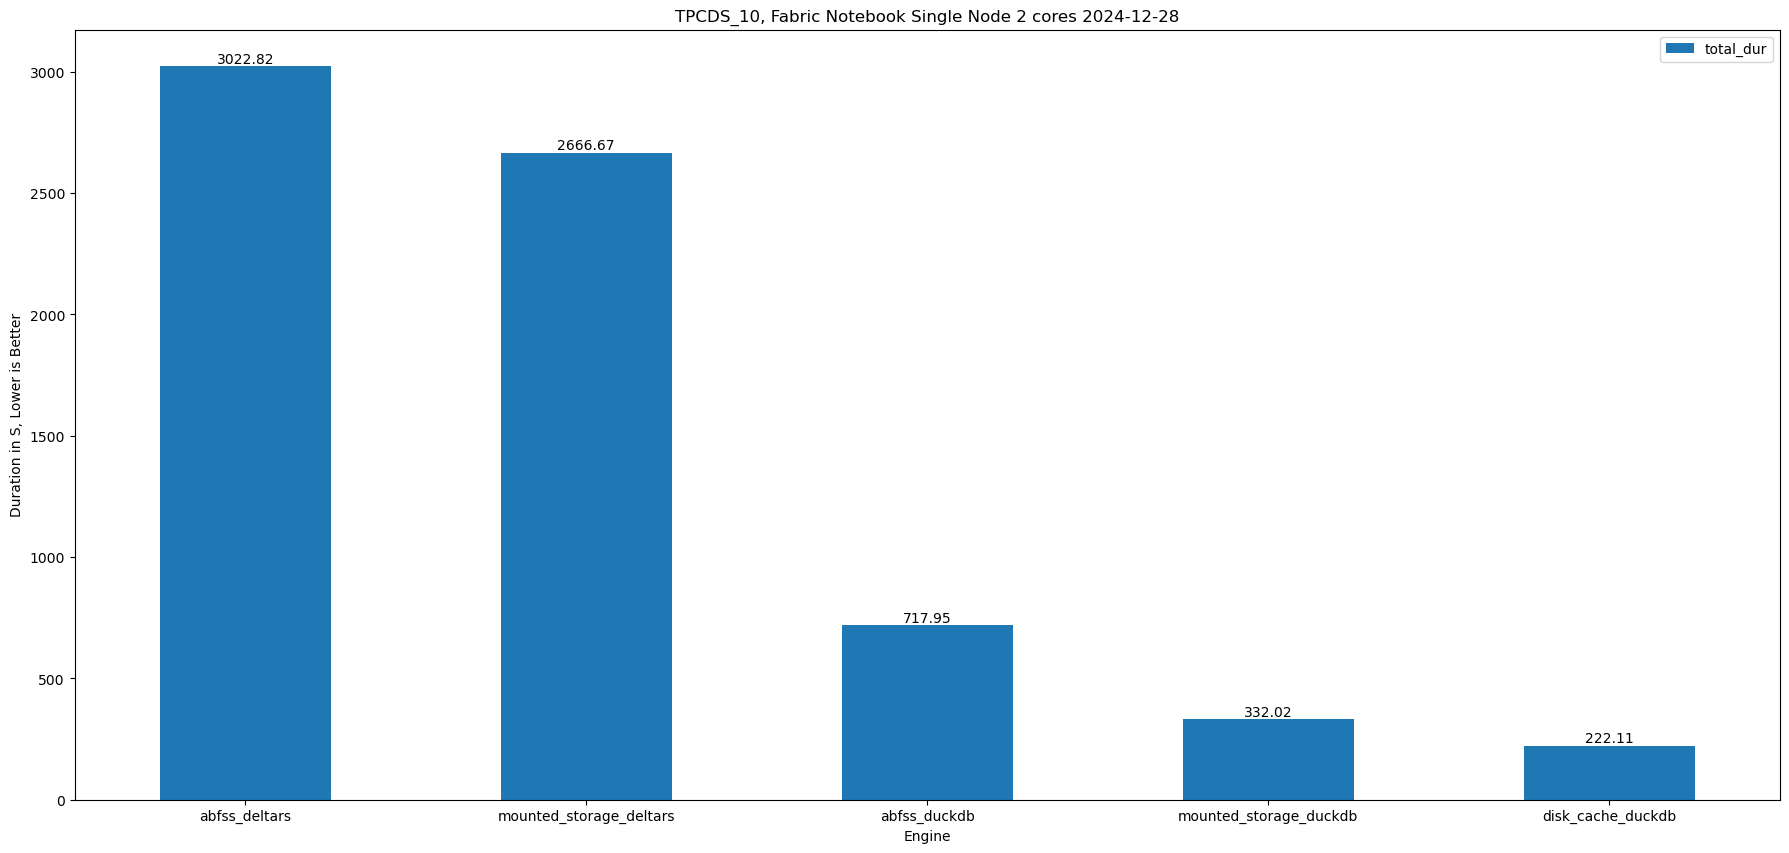

In [23]:
xx = duckdb.sql(" select Engine,total_dur from result order by total_dur desc ").df()
ax = xx.plot.bar(rot=0,x='Engine',title=f"TPCDS_{SF:02d}, Fabric Notebook Single Node {core} cores " + datetime.now().strftime('%Y-%m-%d'),ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

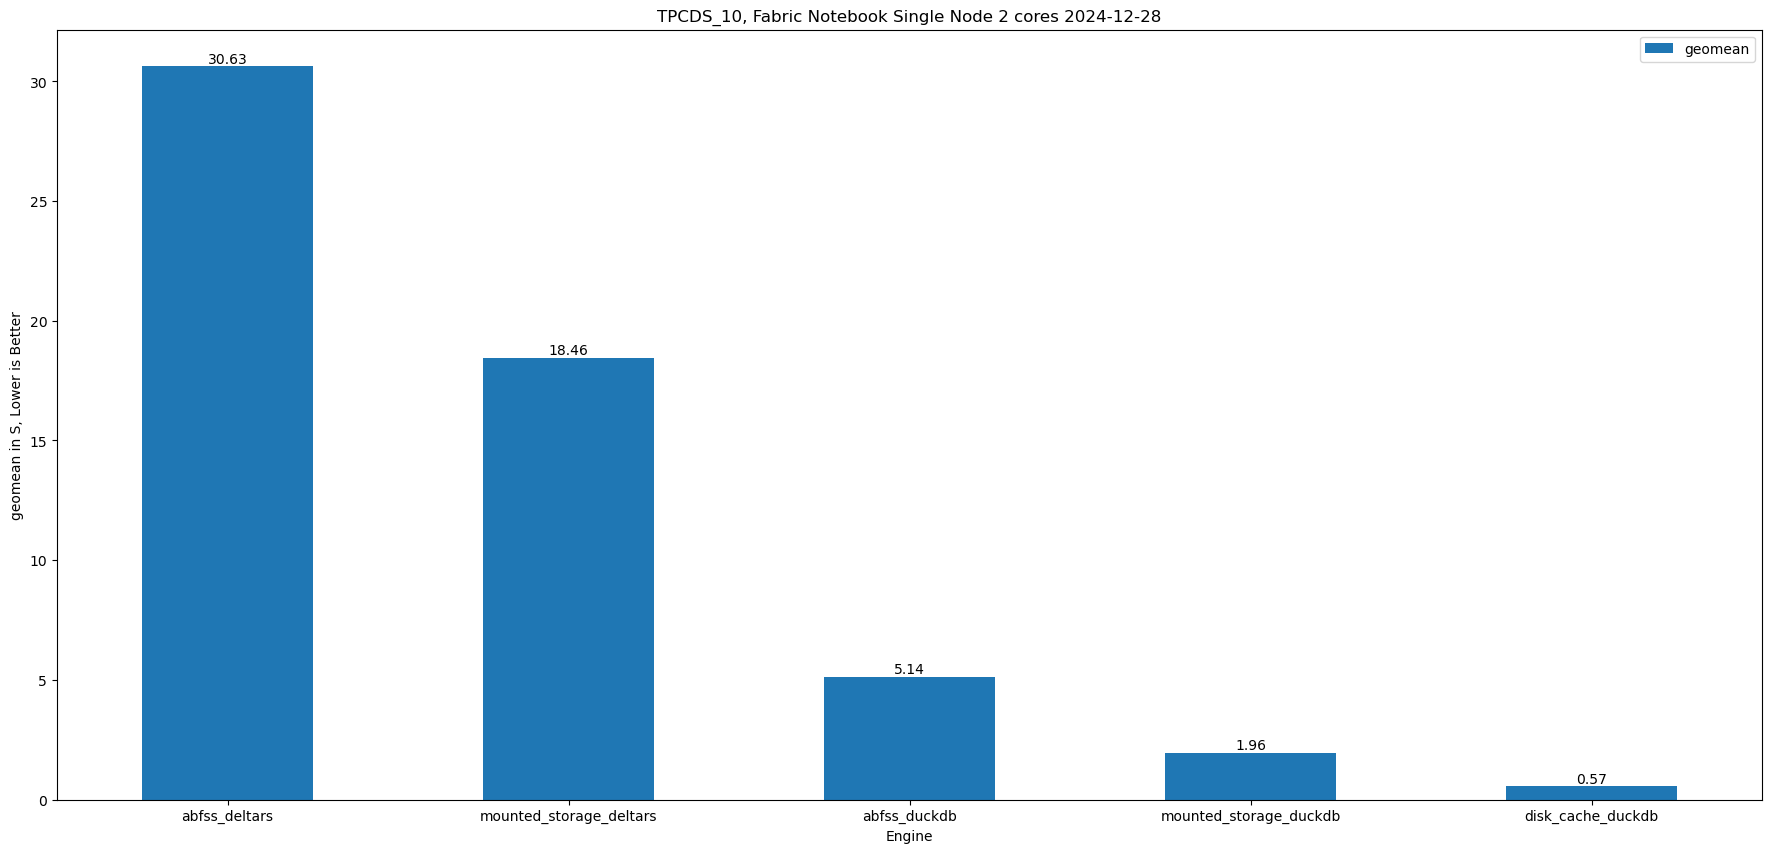

In [24]:
xx = duckdb.sql(" select Engine,geomean from result order by geomean desc ").df()
ax = xx.plot.bar(rot=0,x='Engine',title=f"TPCDS_{SF:02d}, Fabric Notebook Single Node {core} cores " + datetime.now().strftime('%Y-%m-%d'),ylabel='geomean in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

In [27]:
raw = duckdb.sql(f""" 
                       
                        pivot
                        (select Engine,test,sf,cpu,query,avg(dur) as dur
                            from delta_scan('{result_path_abfss}')
                            where sf   =  {SF} 
                            and   cpu  =  {core}
                            and   test = 'tpcds'
                            and   time > '2024-12-27'
                            group by all
                        )
                         on Engine using avg(round(dur,2))  order by query
            """).df()
display(raw)